# Parallel Algebraic Curves

This notebook creates a plot animation of an Algebraic Curve next to its dual in Parallel Coordinates. To use it, adjust the [important parameters](#Important) and run the notebook.

The Algebraic Curve considered is $\sum_{0<=i<=5} \text{ } A_i x_1^i + B_i x_2^i$, where A, B are the parameters defined below.

Requirements:
 - [imagemagick](https://www.imagemagick.org) to save the animation as a GIF.
 - [JSAnimation](https://github.com/jakevdp/JSAnimation) to embedd the animation with a comfortable player.


## Parameters

### Important

In [1]:
# Algebraic Curve
A = [-1, 0, 1, 0, 0, 0]
B = [ 0, 0, 1, 0, 0, 0]
# curve := sum_{ 0<= i <=5 }  A[i]*x1**i + B[i]*x2**i

# Parallel coordinate
D = 1 # Distance between X2 and X1 axis

# Output
SAVE_ANIMATION = False    # if True - save animation, otherwise - embedd in notebook
SAVE_AS        = 'curve'  # animation will be save as pwd/SAVE_AS.gif

# Dependencies
IMAGE_MAGEICK_ROOT = '<MY_PATH>/ImageMagick-7.0.7-Q16/'  # change to your ImageMagick path

### Esoteric

In [2]:
# Visualization
DATA_POINTS = 2000
POINTS_FROM = -4
POINTS_TO = 4
ONE_LINE = True # if False, the "dual line" subplot will present many lines at a time, not only a single one

# Figure Appearance
AXIS_PROPORTION = 0.8
AXIS_COLOR = '#696969'

# Enimation
MSEC_FRAME_DELAY = 30
FRAMES_PER_CHANGE = 16
FPS = 30

## Imports

In [3]:
%matplotlib inline
%pylab inline

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import display, Markdown, HTML

from sympy import symbols, diff, solve
import numpy as np

from datetime import datetime
from os.path import join
import os

# setup ImageMagic, with credit to @Sebastiaan at https://stackoverflow.com/questions/23417487/saving-a-matplotlib-animation-with-imagemagick-and-without-ffmpeg-or-mencoder/29564473
os.environ["MAGICK_HOME"] = join(IMAGE_MAGEICK_ROOT, 'modules', 'coders')
rc('animation', convert_path=unicode(join(IMAGE_MAGEICK_ROOT, 'magick.exe')))

Populating the interactive namespace from numpy and matplotlib


## Define the Algebraic Curve and its Dual in Parallel Coordinates

In [4]:
# implict definition of an algebraic curve 
t1, t2 = symbols('t1 t2', real=True)
F = A[0] + A[1]*t1**1 + A[2]*t1**2 + A[3]*t1**3 + A[4]*t1**4 + A[5]*t1**5 + \
    B[0] + B[1]*t2**1 + B[2]*t2**2 + B[3]*t2**3 + B[4]*t2**4 + B[5]*t2**5
print('Algabraic Curve to plot: %s' % F)

# define f:x1->x2 such that F(x1,f(x1)) = 0
solutions_x2_by_x1 = solve(F, t2)
f = lambda x1: [v for v in [v.evalf(subs={t1:x1}) for v in solutions_x2_by_x1] if v.is_real]

# dual lines in parallel coordinate
dual = lambda x1, x2, x: np.column_stack((np.ones(x1.shape[0]) * x, (x * (x2 - x1))/D + x1))

# dual-point translation (euclid R^2 -> parallel R^2)
def phi(x1, x2, d=D):
    dF_dx1 = diff(F.subs({t2:x2,})).subs({t1:x1})
    dF_dx2 = diff(F.subs({t1:x1,})).subs({t2:x2})
    
    phi_y = (x1*dF_dx1 + x2*dF_dx2) / (dF_dx1 + dF_dx2)
    phi_x = (d*dF_dx2) / (dF_dx1 + dF_dx2)
    
    return (phi_x, phi_y)
vec_phi = np.vectorize(phi)

# Interweave a nan after every pair of v elements
# used to plot multiple lines, instead of a single connected set on lines
def interweave_nans(v):
    assert v.shape[1] == 2
    
    c = np.empty(int(v.shape[0] * (3.0 / 2)))
    c[0::3] = v[0::2, 0]
    c[1::3] = v[0::2, 1]
    c[2::3] = np.nan
    
    return c

Algabraic Curve to plot: t1**2 + t2**2 - 1


## Sample Points on the Curve, and Calculate their Duals

In [5]:
# fix X1 to infer X2 by {F=0}
init_X1 = np.linspace(POINTS_FROM, POINTS_TO, DATA_POINTS)

# generate points for algebraic curve
X1, X2 = [], []
clock = datetime.now()
for i in range(init_X1.shape[0]):
    x2s = f(init_X1[i])
    X1.extend([init_X1[i],] * len(x2s))
    X2.extend(x2s)
X1, X2 = np.array(X1) ,np.array(X2)
print('Calculated %d points on the Algebraic Curve in %d sc.' % (DATA_POINTS, (datetime.now() - clock).seconds))

# generates dual lines for the algebraic curve, in parallel coordinates
clock = datetime.now()
L_from, L_to = dual(X1, X2, POINTS_FROM - 1), dual(X1, X2, POINTS_TO + 1)
L_x, L_y = np.column_stack((L_from[:, 0], L_to[:, 0])), np.column_stack((L_from[:, 1], L_to[:, 1]))
L_x_nans, L_y_nans = interweave_nans(L_x), interweave_nans(L_y)  # used if ONE_LINE = False
print('Calculated %d dual lines of the Algebraic Curve, projcted into parallel coordinates, in %d sc.' % 
      (DATA_POINTS, (datetime.now() - clock).seconds))

# generate points for dual algebraic curve
clock = datetime.now()
X, Y = vec_phi(X1, X2)
print('Calculated %d points on the dual in parallel coordinates of the Algebraic Curve in %d sc.' % 
      (DATA_POINTS, (datetime.now() - clock).seconds))

Calculated 2000 points on the Algebraic Curve in 2 sc.
Calculated 2000 dual lines of the Algebraic Curve, projcted into parallel coordinates, in 0 sc.
Calculated 2000 points on the dual in parallel coordinates of the Algebraic Curve in 1 sc.


## Generate Animation

### Figure Appearance

In [6]:
# calculate Axis size from AXIS_PROPORTION and POINTS_FROM, POINTS_TO
body_proportion = AXIS_PROPORTION * 0.9
head_proportion = AXIS_PROPORTION * 0.1
axis_range = [(POINTS_FROM - 1) * body_proportion, (POINTS_TO + 1) * body_proportion]
axis_size = axis_range[1] - axis_range[0]
axis_head_size = axis_size * (((body_proportion + head_proportion) / body_proportion) - 1)
axis_label_loc = (axis_size / 2)

arrow_kwargs = dict(
    color=AXIS_COLOR, 
    length_includes_head=True,
    head_width=axis_head_size * 0.2, 
    head_length=axis_head_size, 
    fc='k', ec='k')

def define_subplot(fig, *args):
    ax = fig.add_subplot(*args)
    ax.set_xlim([POINTS_FROM - 1, POINTS_TO + 1])
    ax.set_ylim([POINTS_FROM - 1, POINTS_TO + 1])
    ax.grid(linestyle='-')
    ticks = np.arange(POINTS_FROM - 1, POINTS_TO + 1, 1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    
    return ax

# figure
fig = plt.figure(figsize=(15,8))

# algebraic curve subplot
ax1 = define_subplot(fig, 131)
ax1.arrow(x=0, y=axis_range[0], dx=0, dy=axis_size, **arrow_kwargs)
ax1.arrow(y=0, x=axis_range[0], dy=0, dx=axis_size, **arrow_kwargs)
ax1.text(0.1, axis_label_loc, 'X1')
ax1.text(axis_label_loc, 0.1, 'X2')
ax1.set_title('Algebraic Curve in Euclidean R^2')
ln1, = ax1.plot([], [], 'b.', animated=True)

# dual lines subplot
ax2 = define_subplot(fig, 132)
ax2.arrow(x=0, y=axis_range[0], dx=0, dy=axis_size, **arrow_kwargs)
ax2.arrow(x=1, y=axis_range[0], dx=0, dy=axis_size, **arrow_kwargs)
ax2.arrow(y=0, x=axis_range[0], dy=0, dx=axis_size, **arrow_kwargs)
ax2.text(0.1, axis_label_loc, 'Y,X1')
ax2.text(1.1, axis_label_loc, 'X2')
ax2.text(axis_label_loc, 0.1, 'Y')
ax2.set_title('Dual Lines in Parallel Coordinates, \nfor points on the Algebraic Curve')
ln2, = ax2.plot([], [], 'b--', animated=True)

# dual curve subplot
ax3 = define_subplot(fig, 133)
ax3.arrow(x=0, y=axis_range[0], dx=0, dy=axis_size, **arrow_kwargs)
ax3.arrow(x=1, y=axis_range[0], dx=0, dy=axis_size, **arrow_kwargs)
ax3.arrow(y=0, x=axis_range[0], dy=0, dx=axis_size, **arrow_kwargs)
ax3.text(0.1, axis_label_loc, 'Y,X1')
ax3.text(1.1, axis_label_loc, 'X2')
ax3.text(axis_label_loc, 0.1, 'X')
ax3.set_title('Envelope of Dual Lines \nin Parallel Coordinates')
ln3, = ax3.plot([], [], 'b.', animated=True)

# unified object
ln = [ln1, ln2, ln3]
plt.close(fig)

### Animation


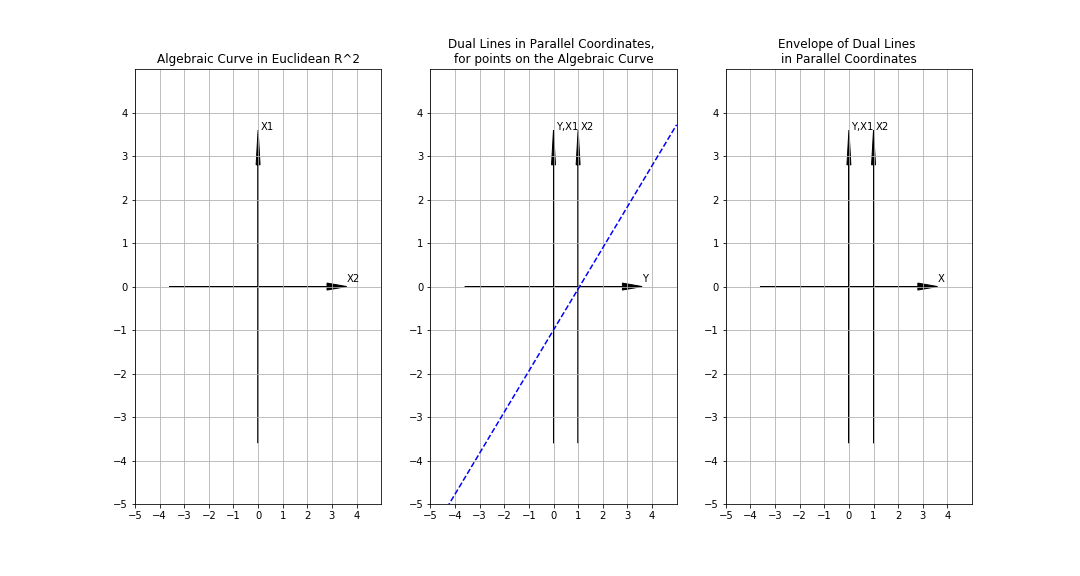
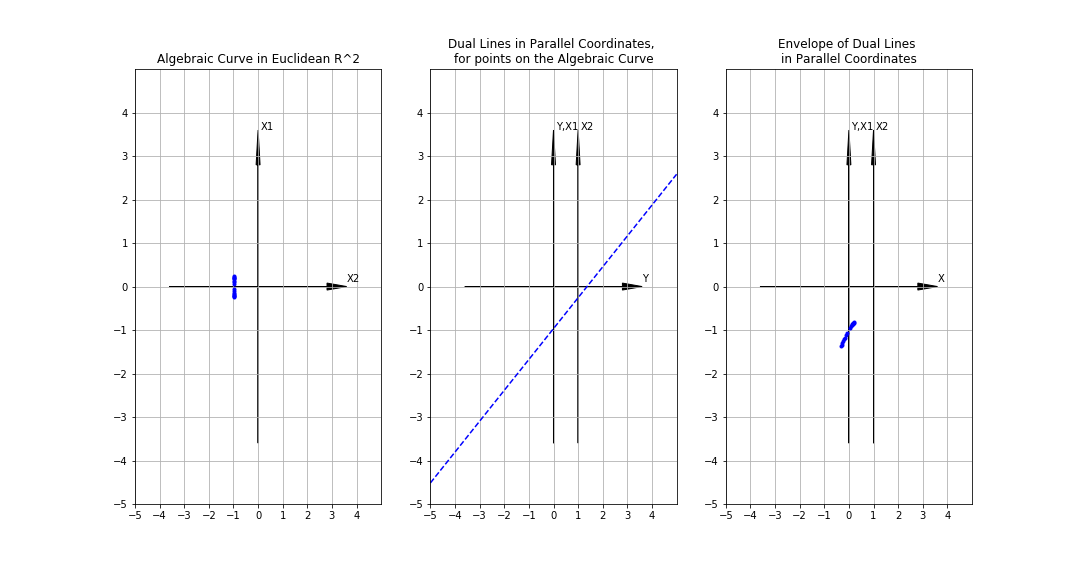
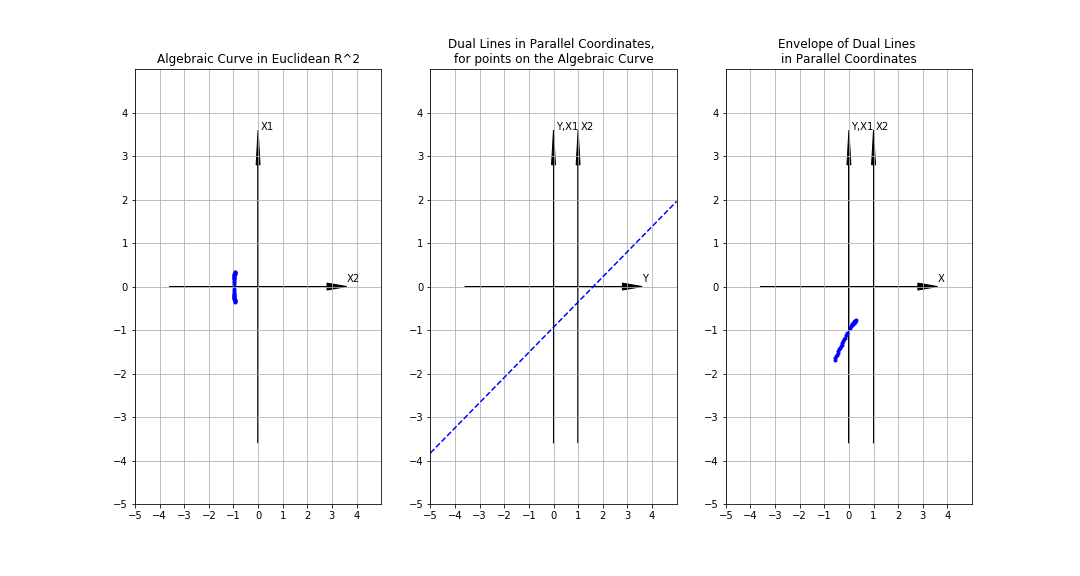
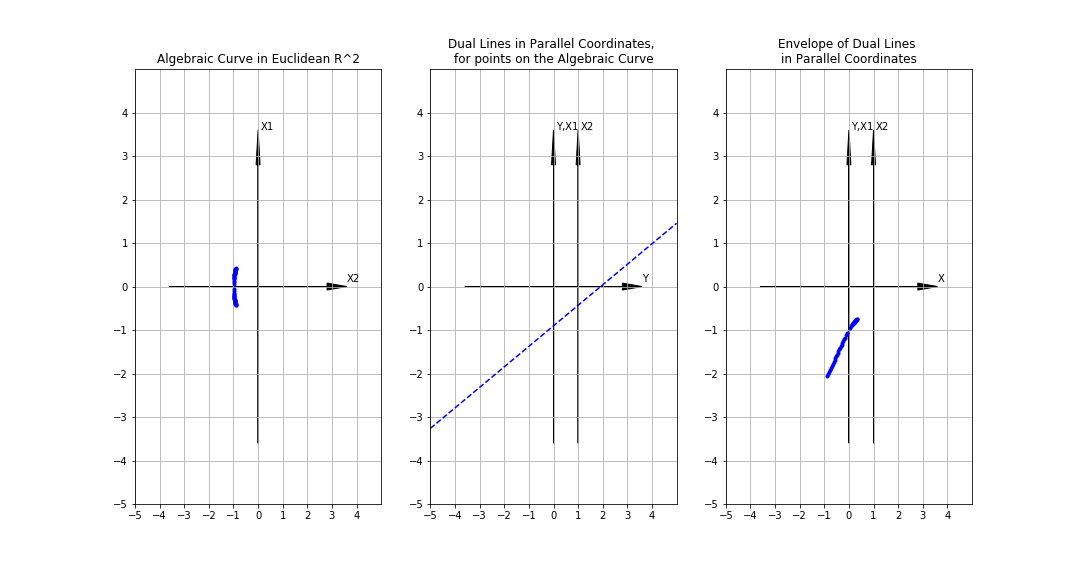
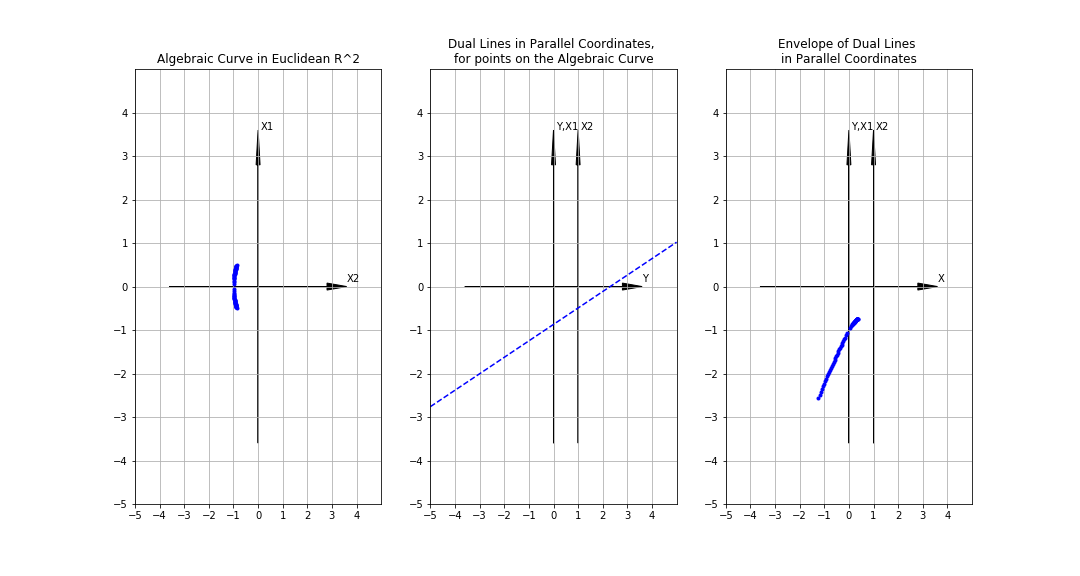
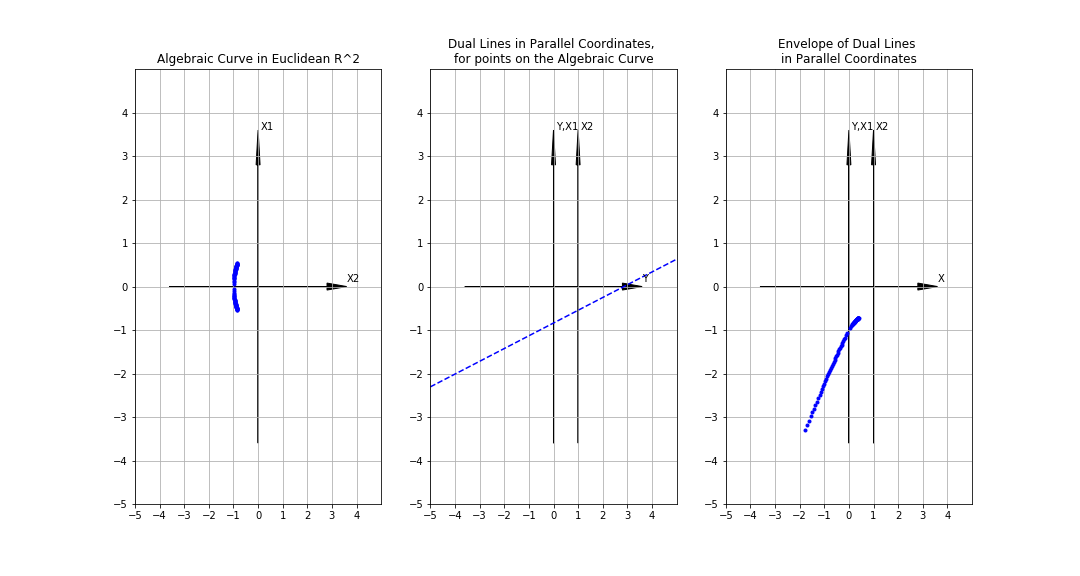
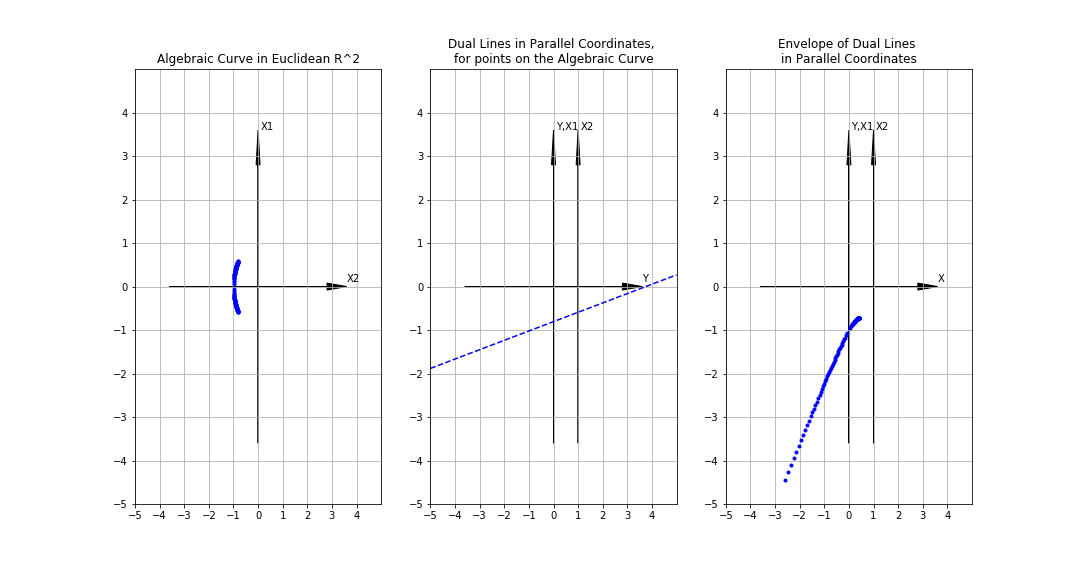
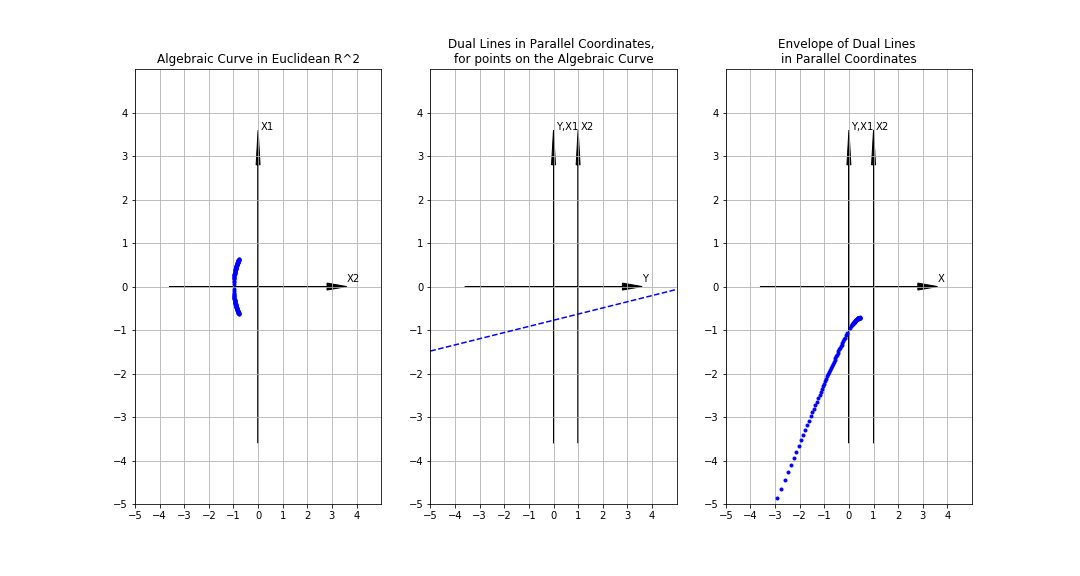
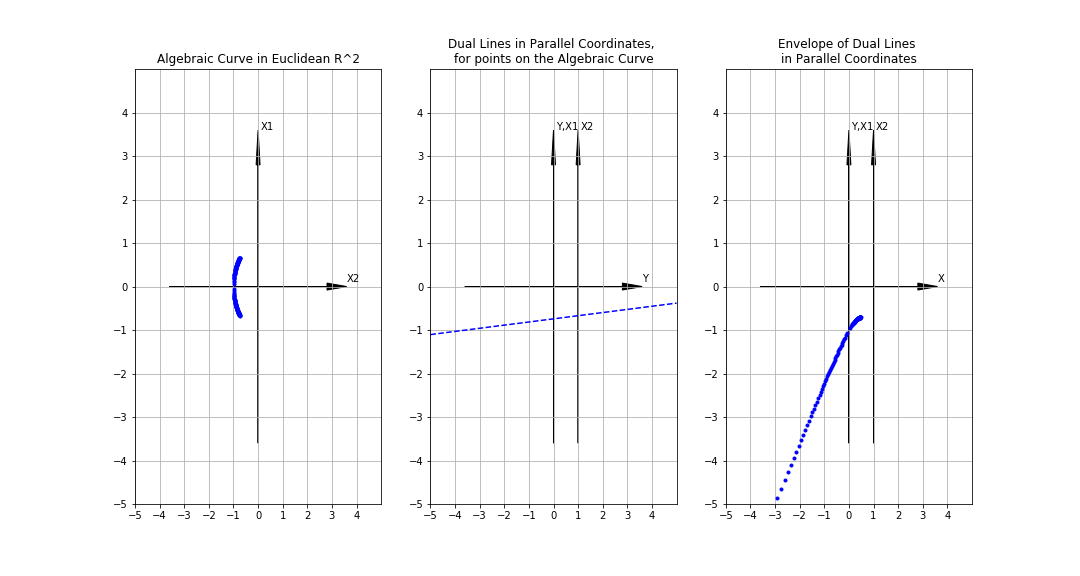
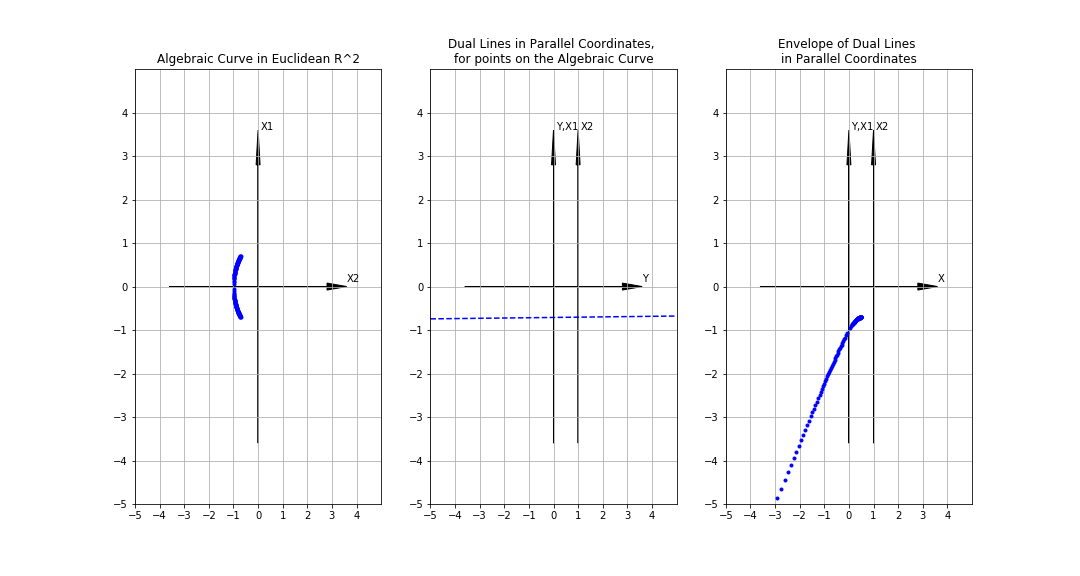
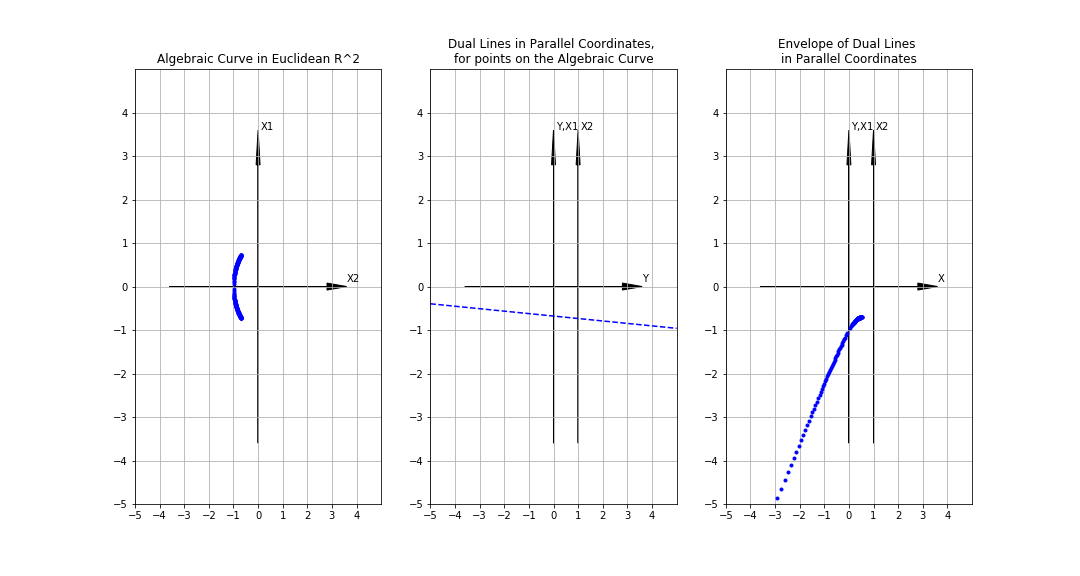
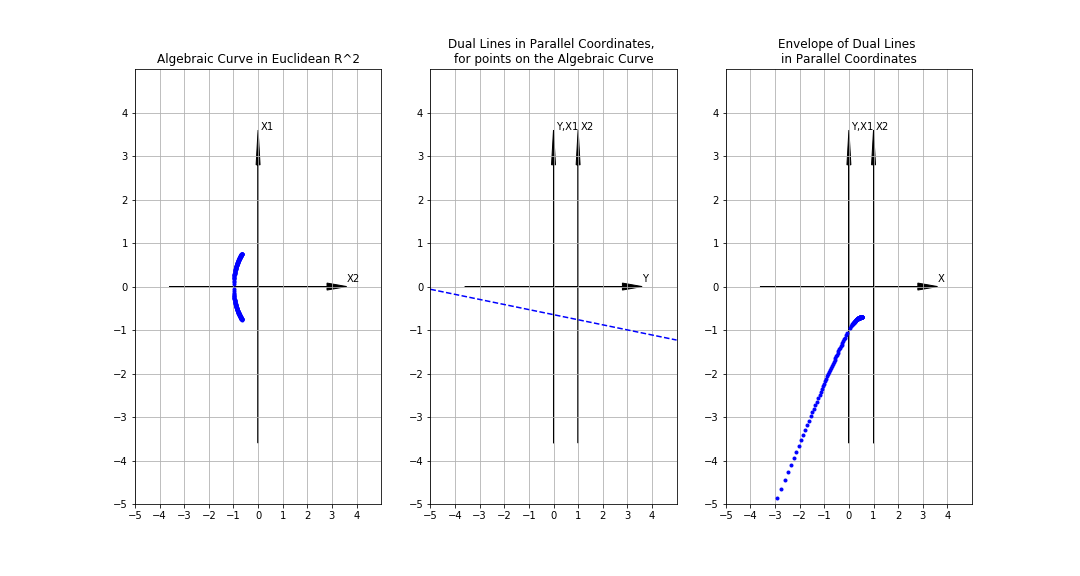
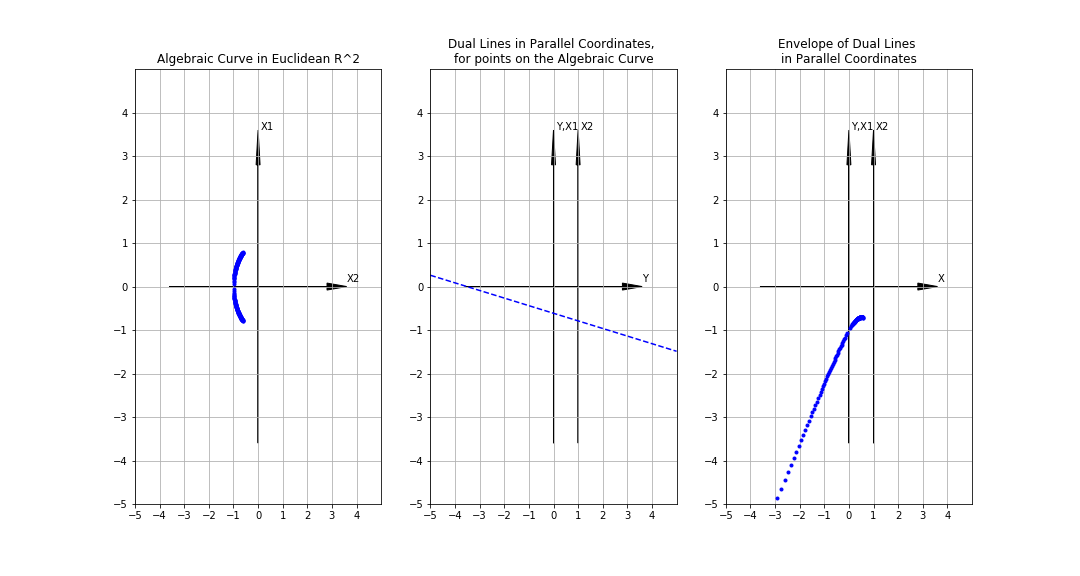
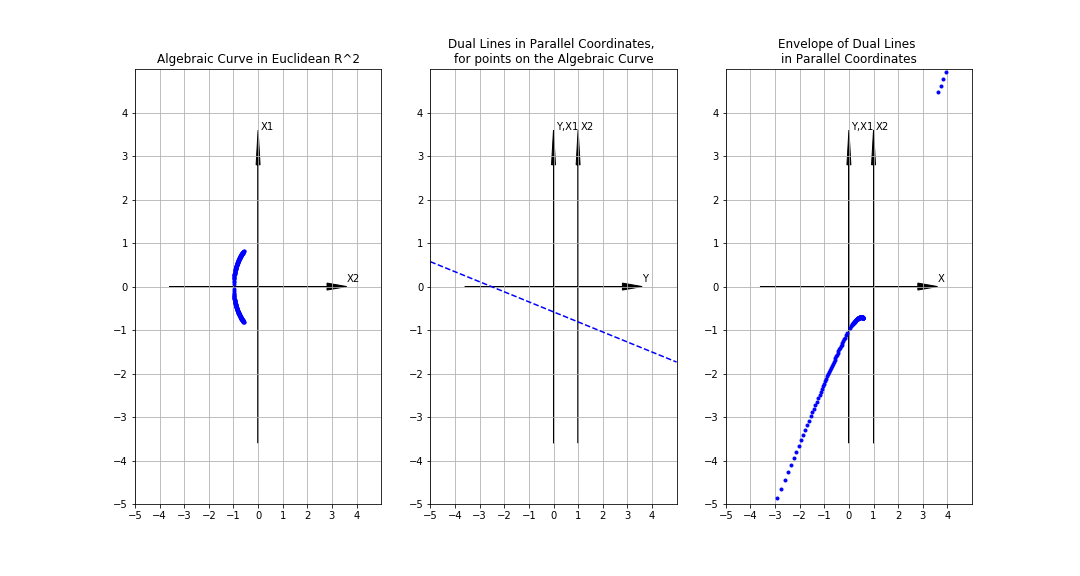
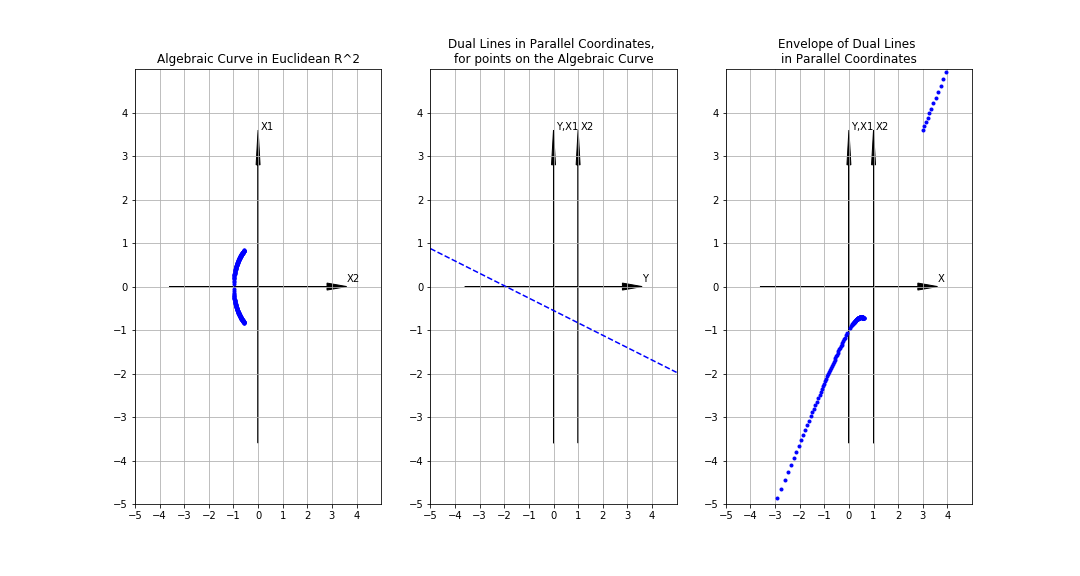
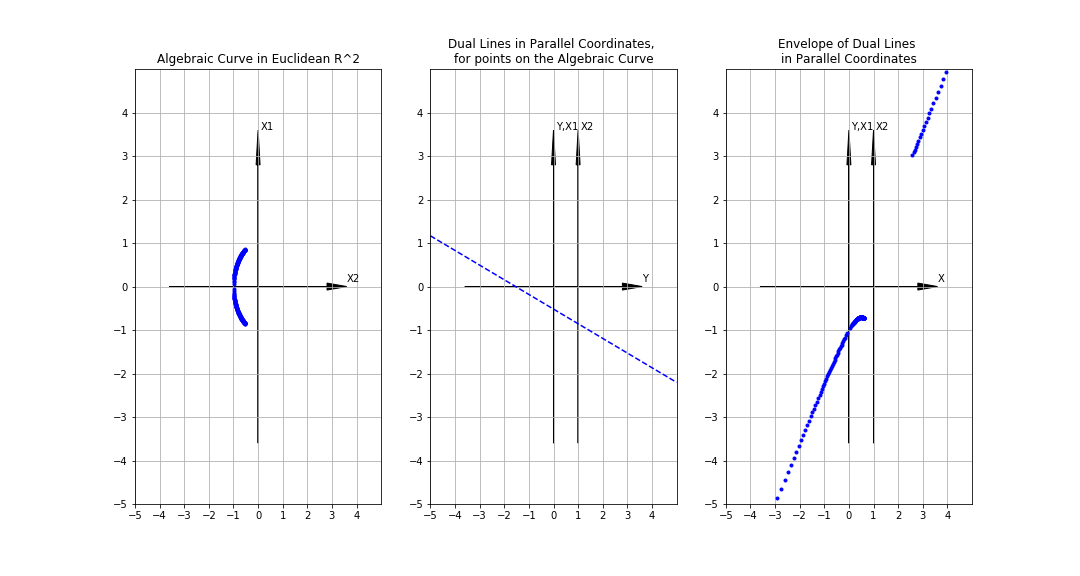
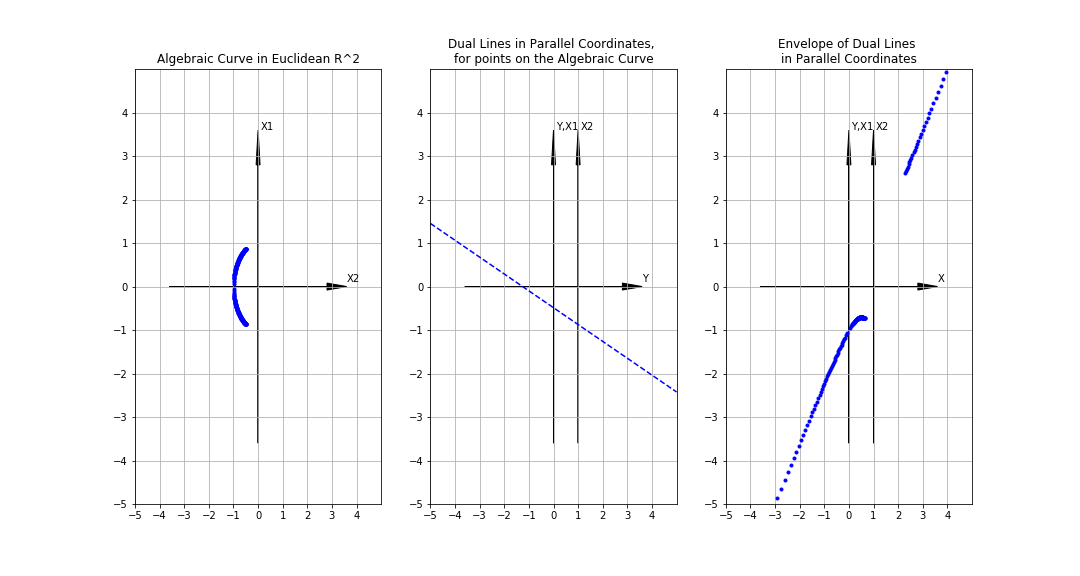
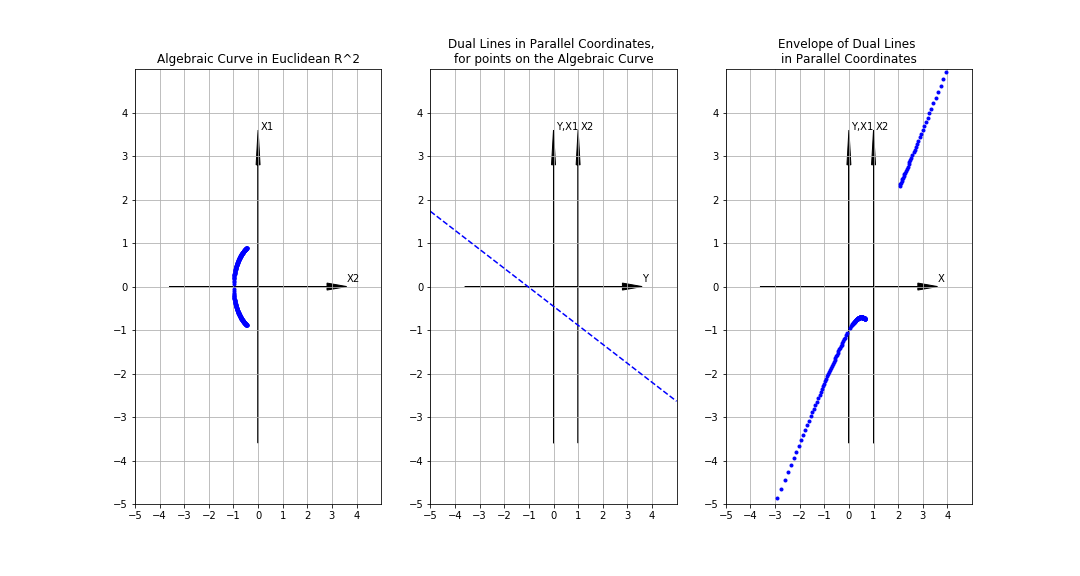
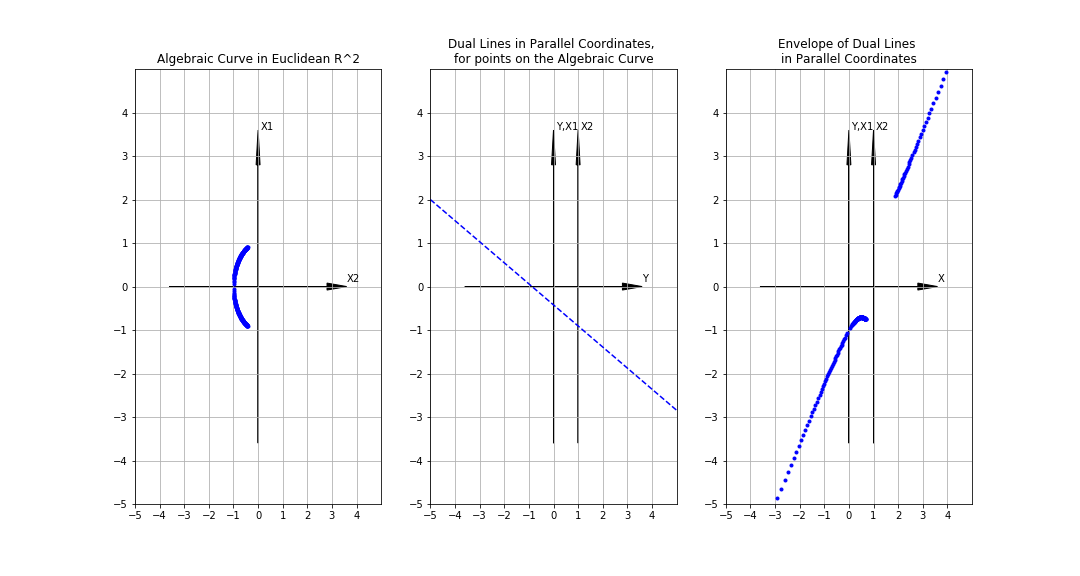
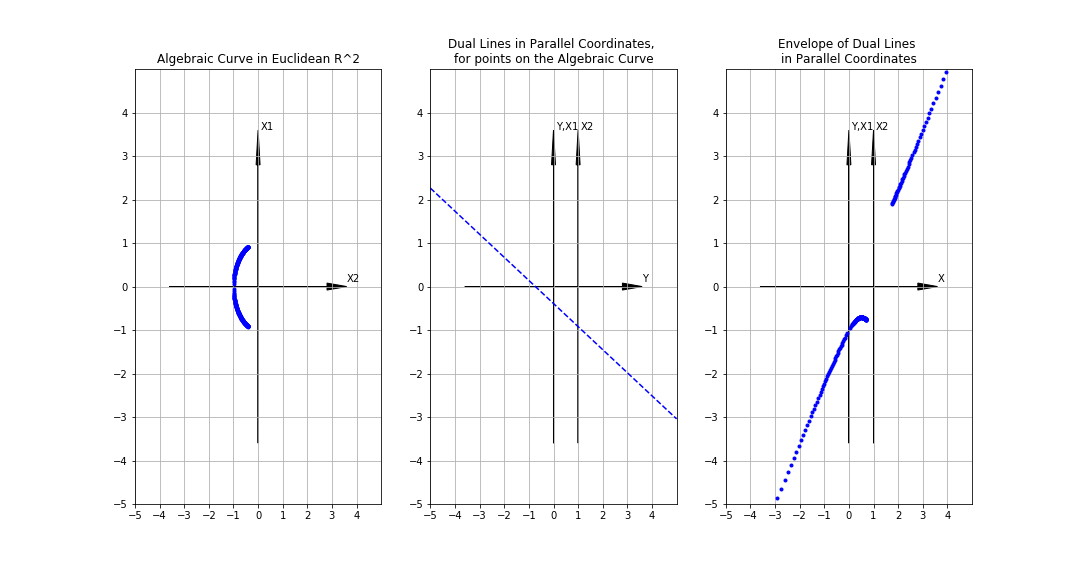
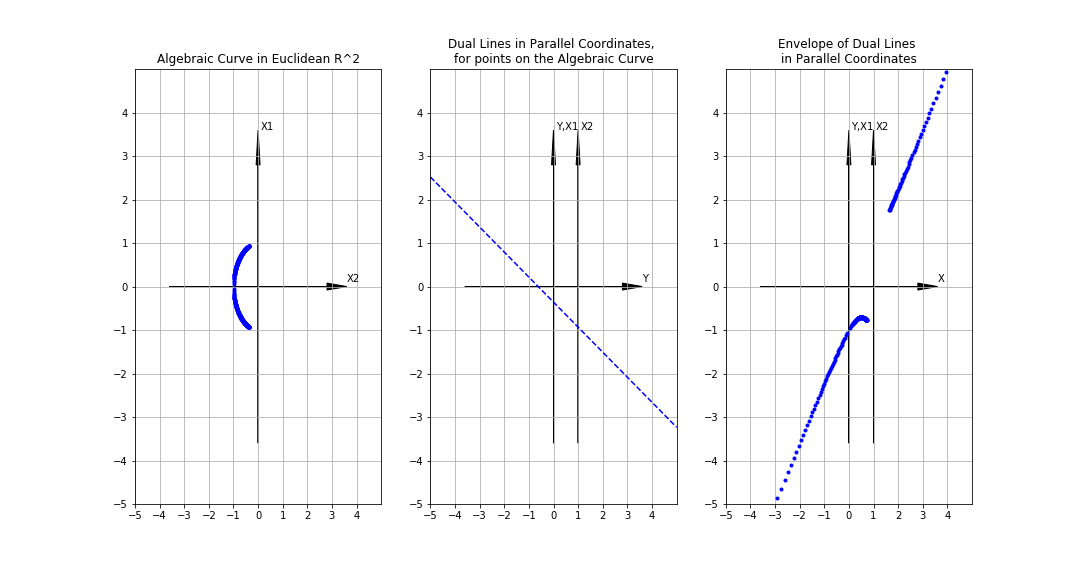
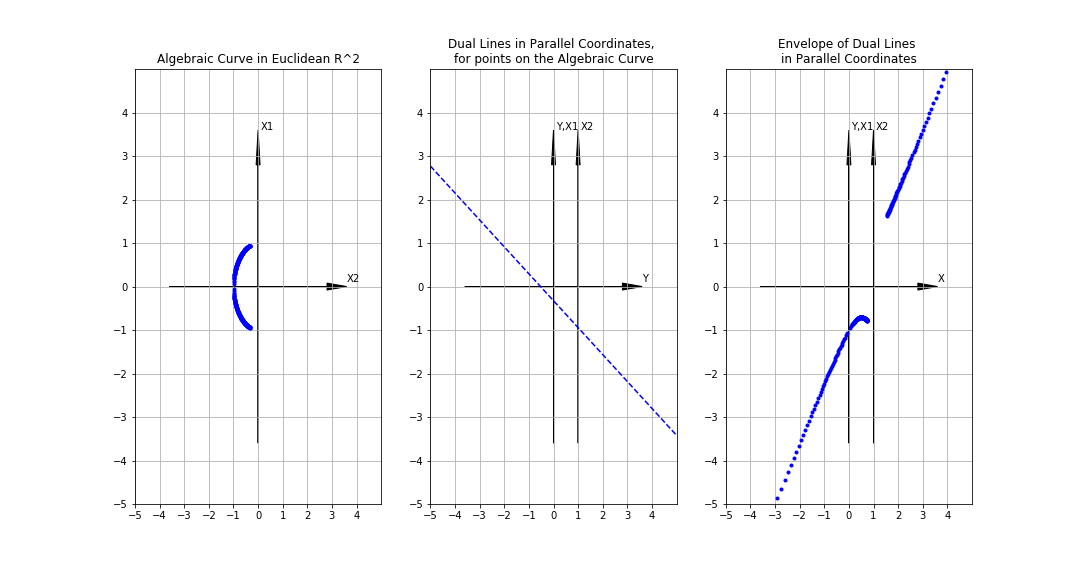
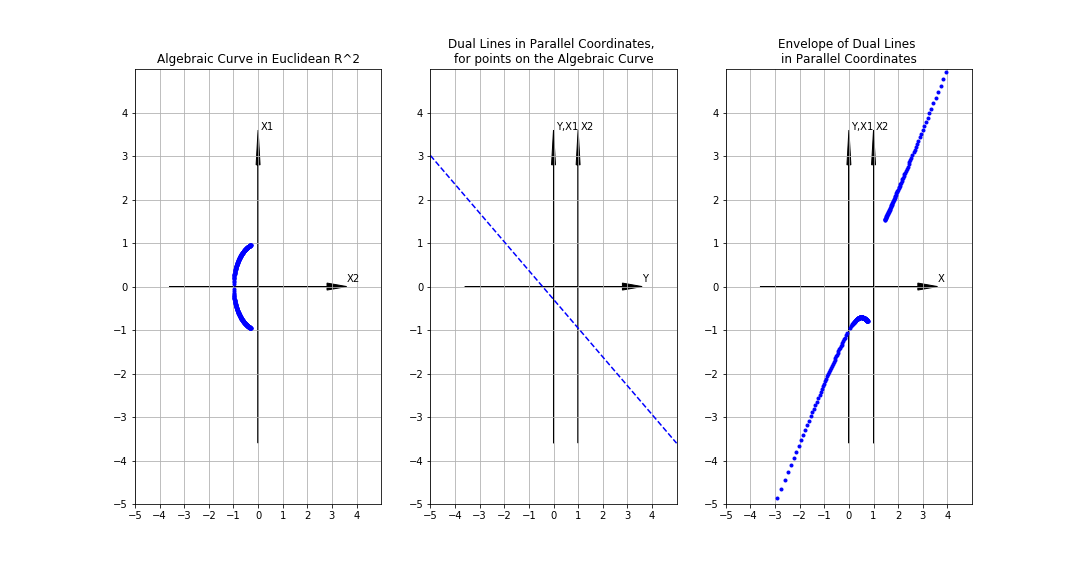
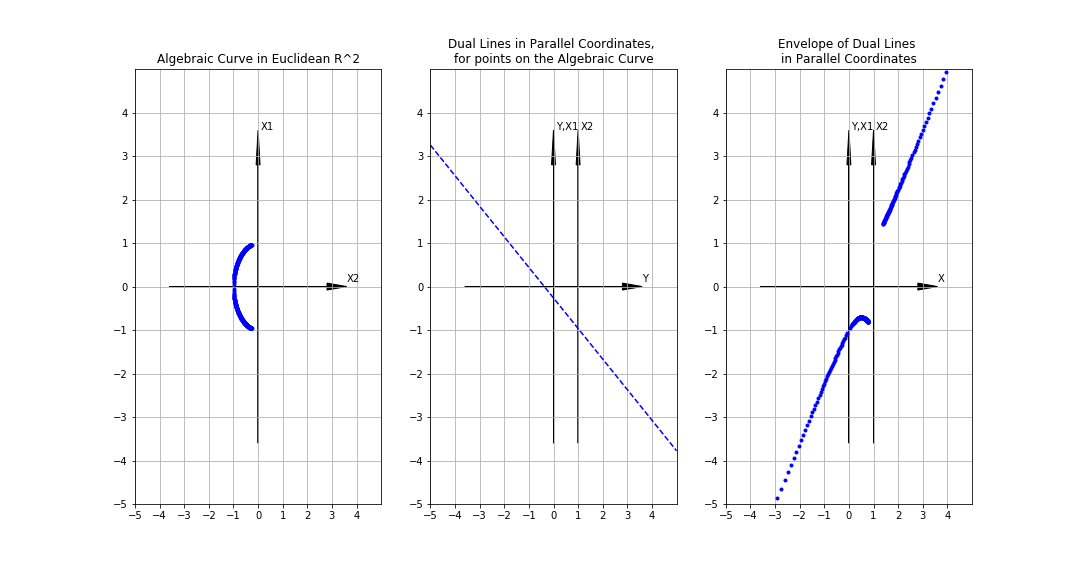
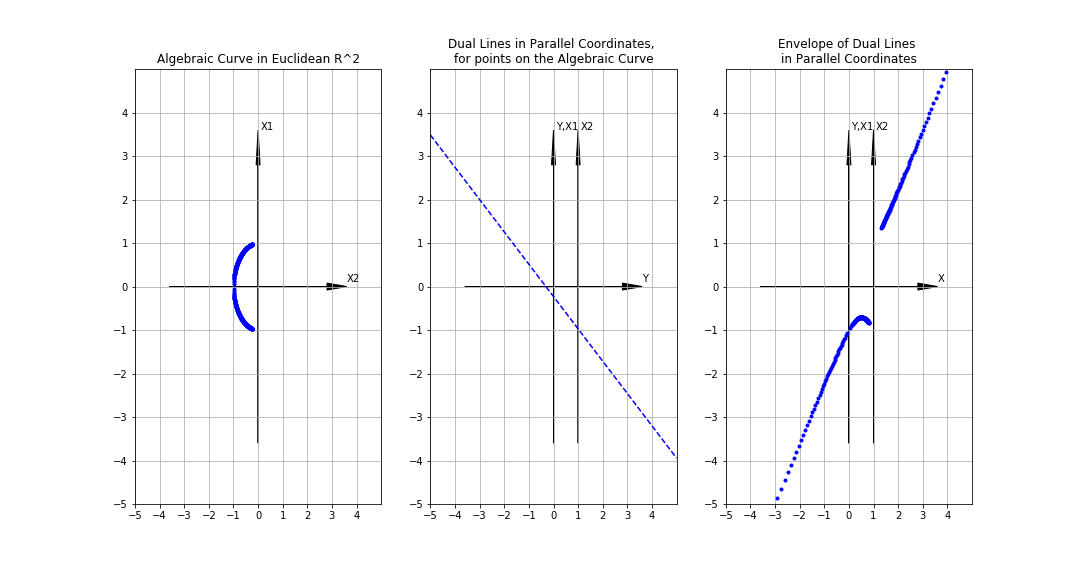
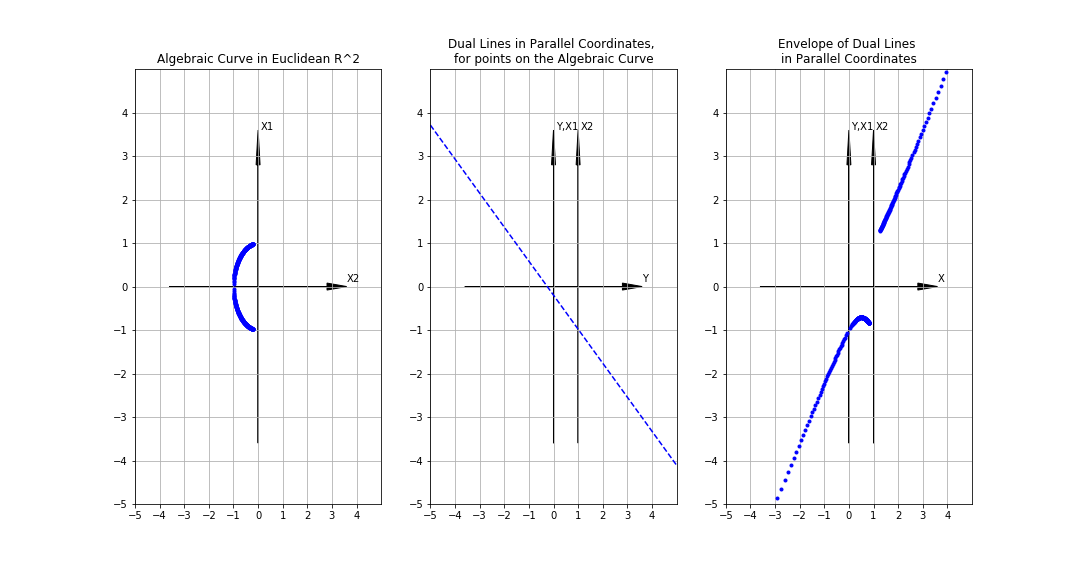
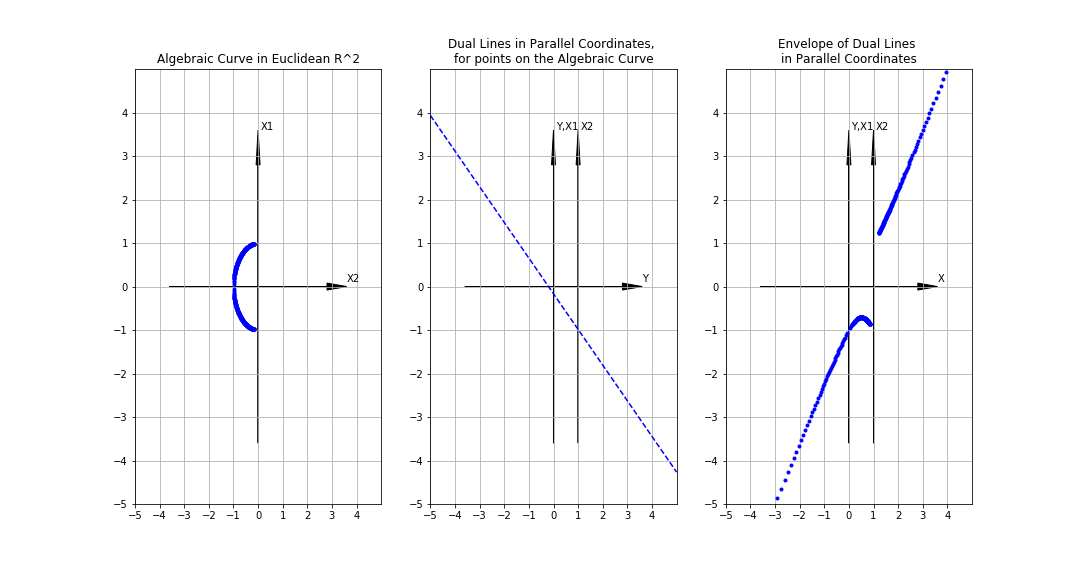
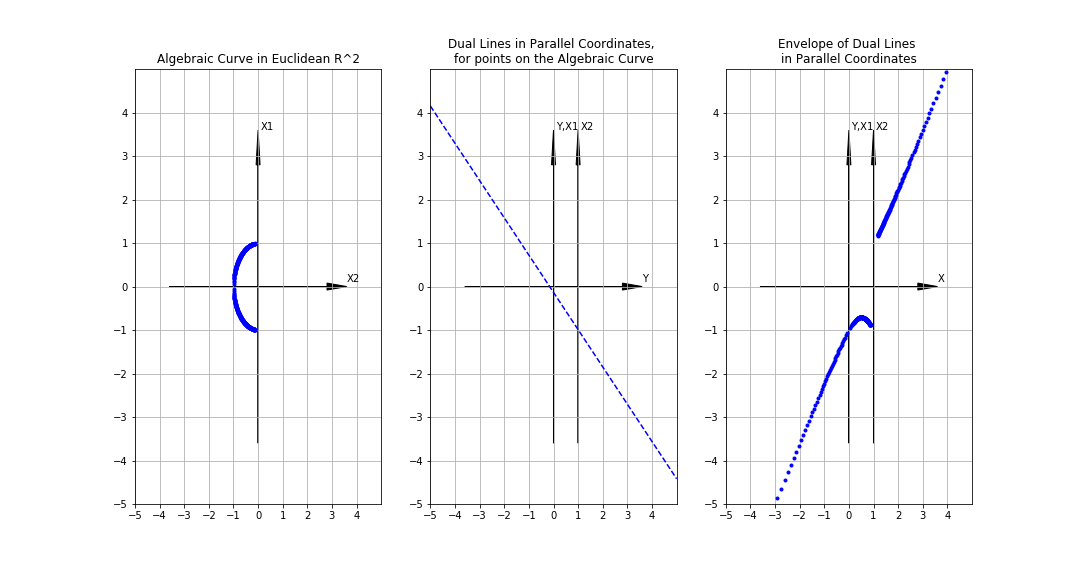
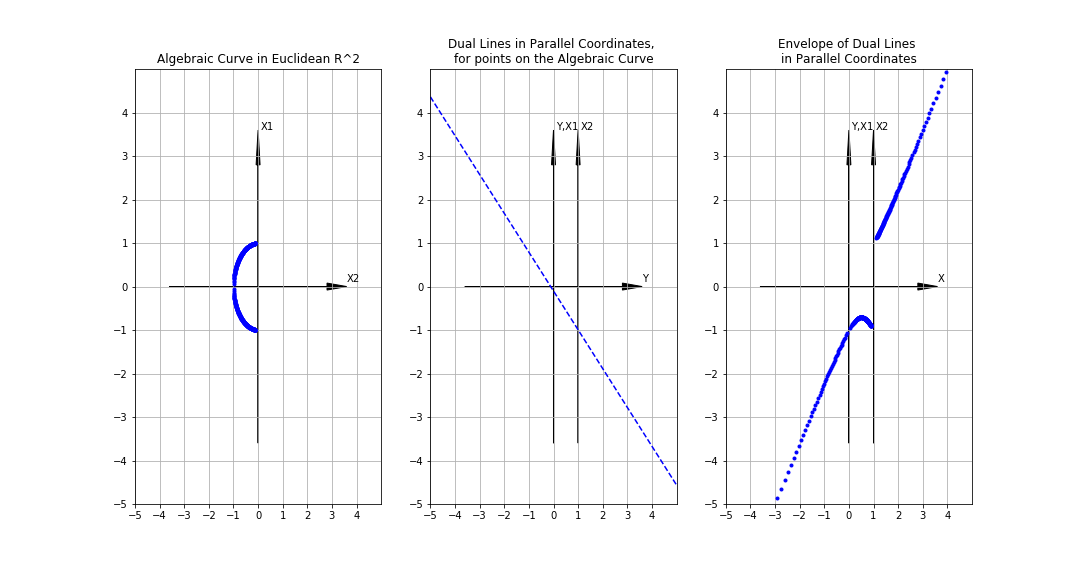
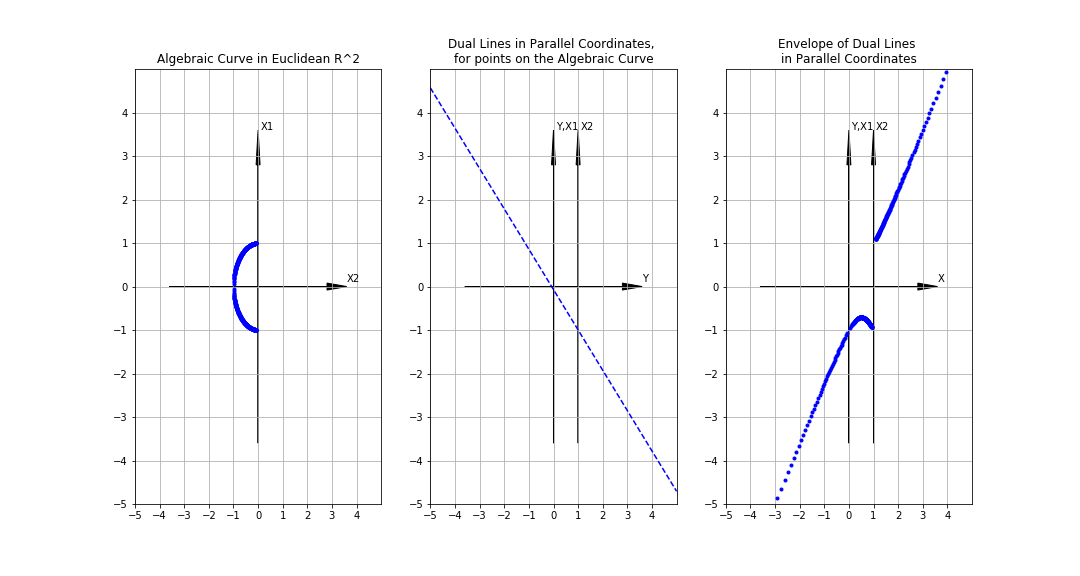
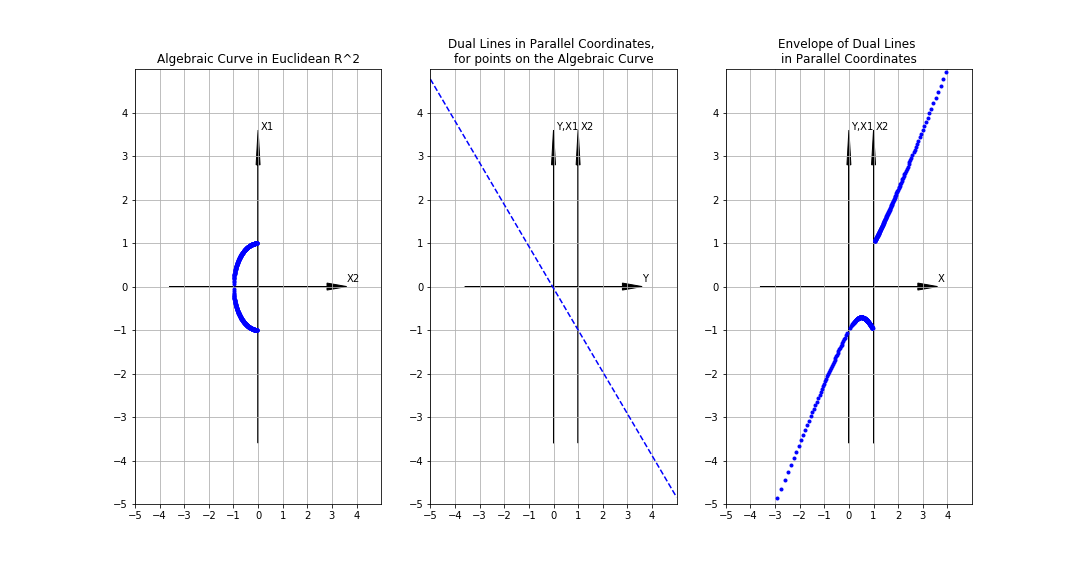
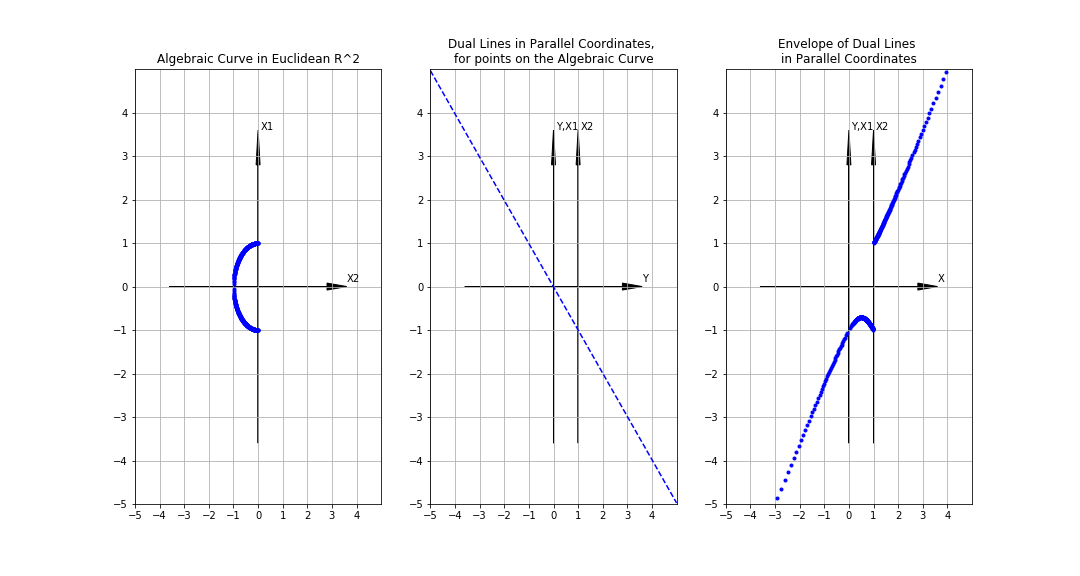
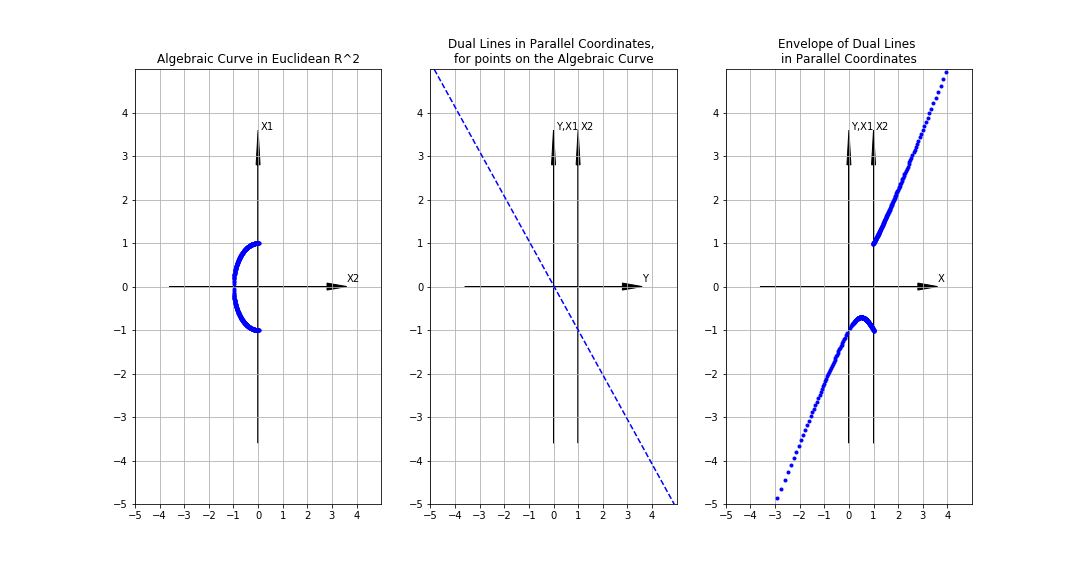
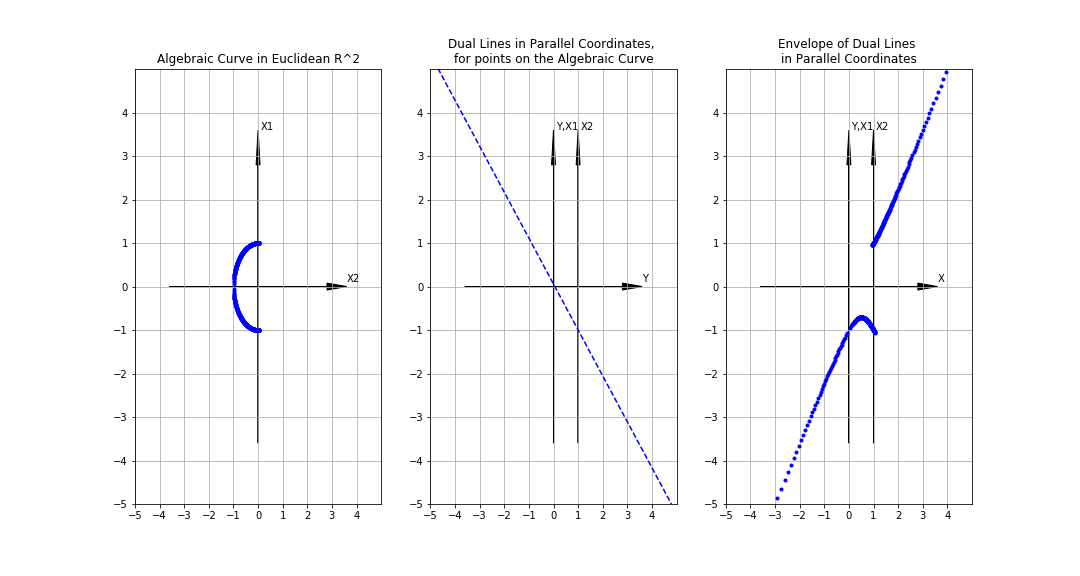
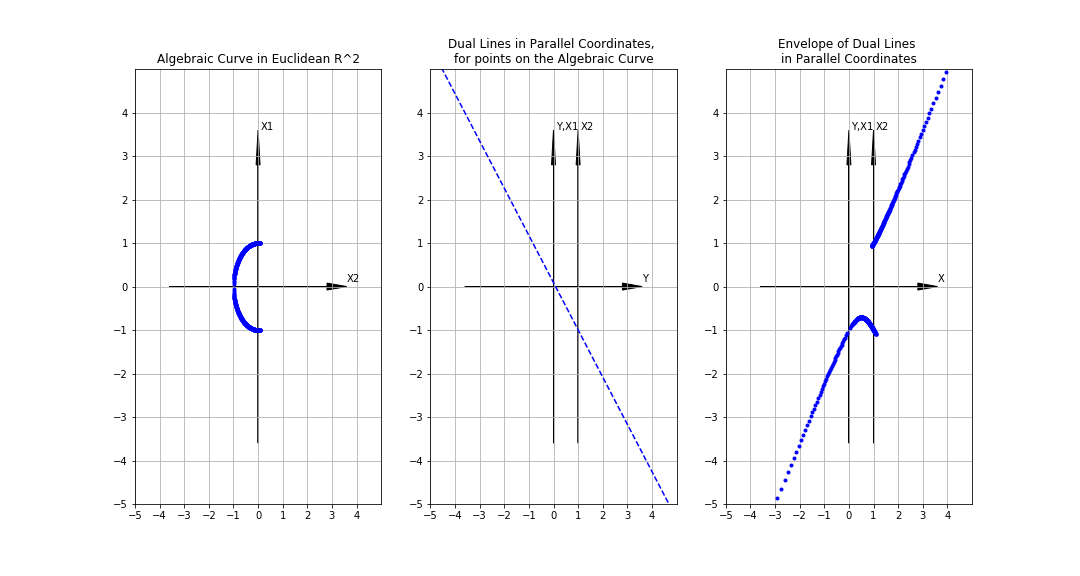
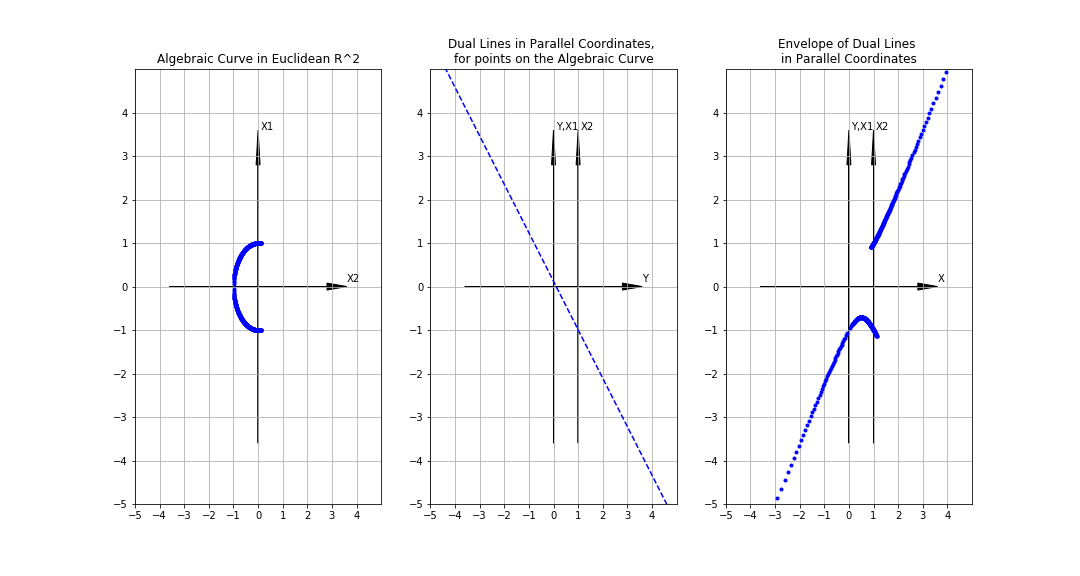
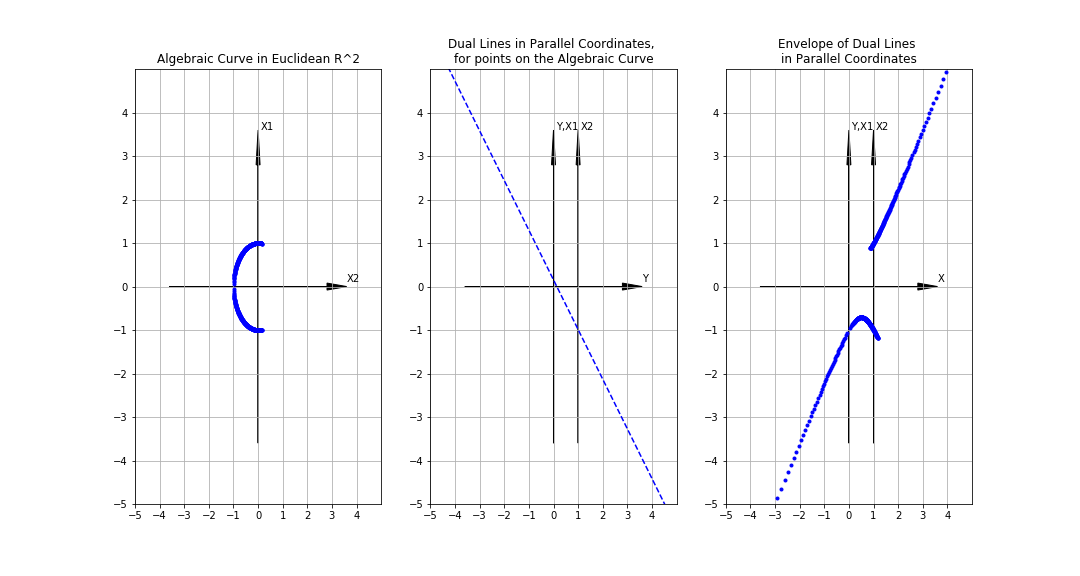
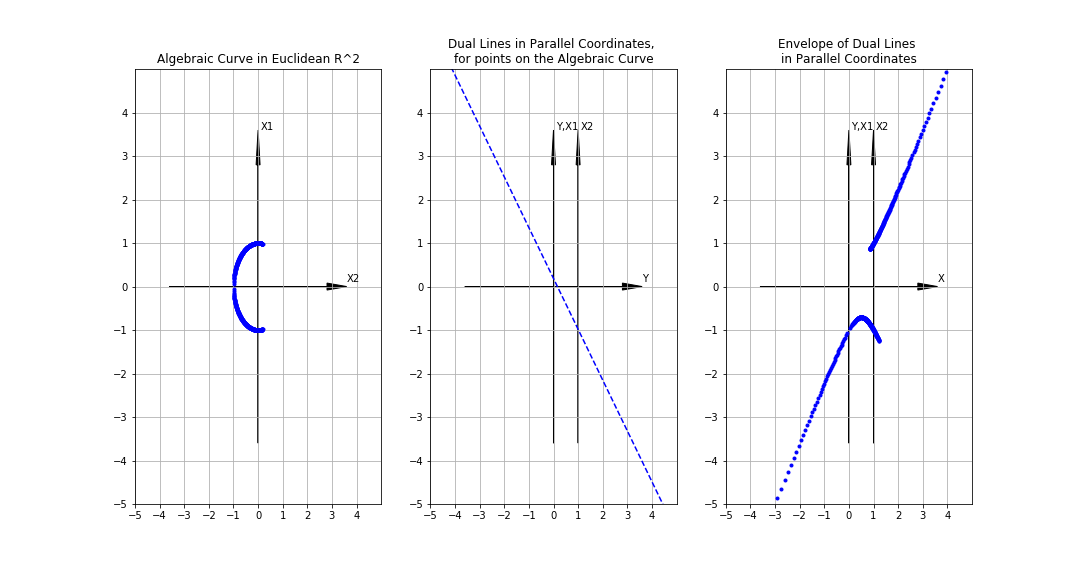
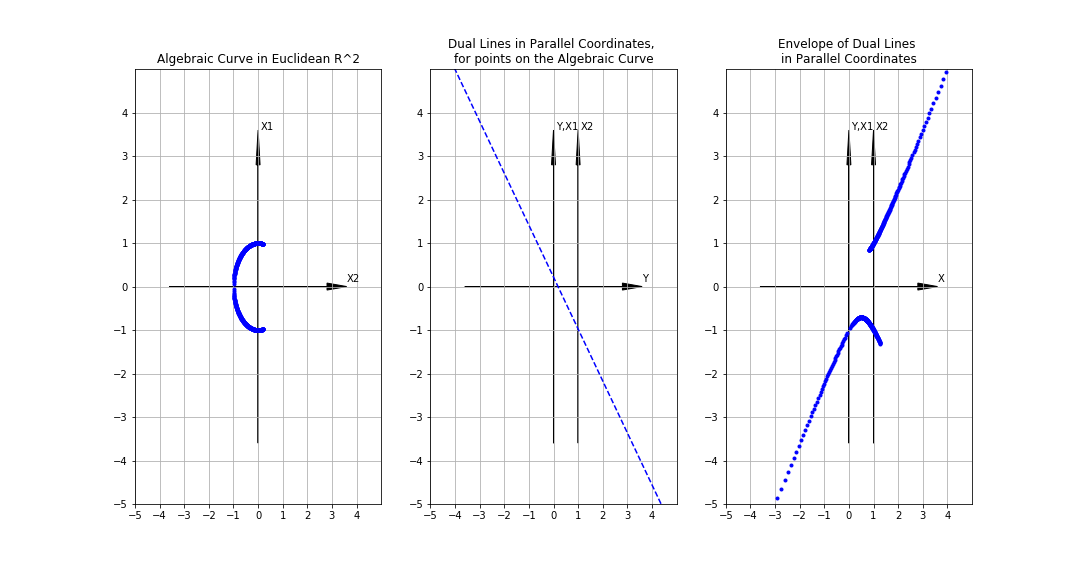
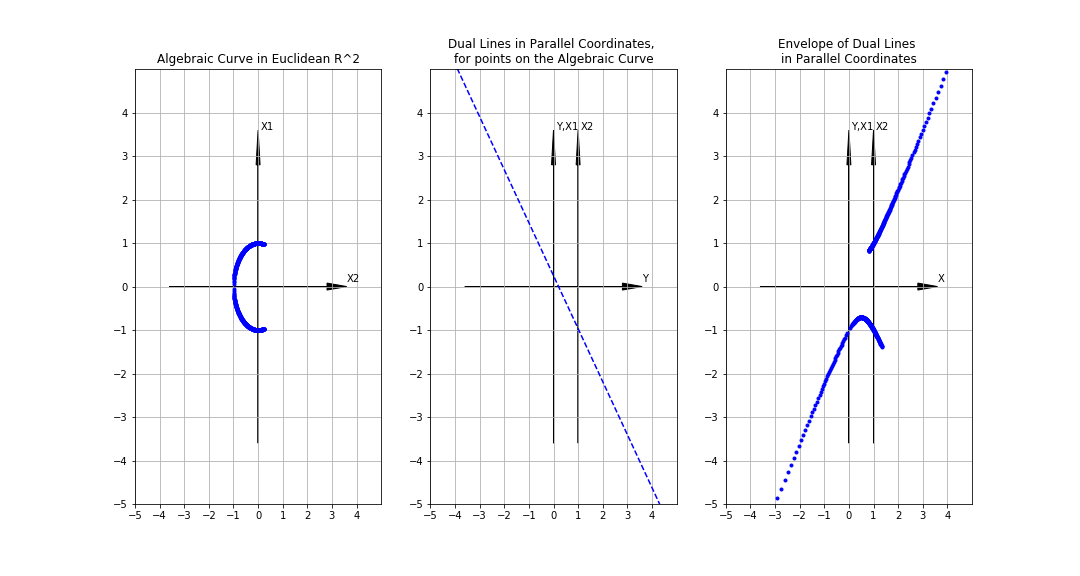
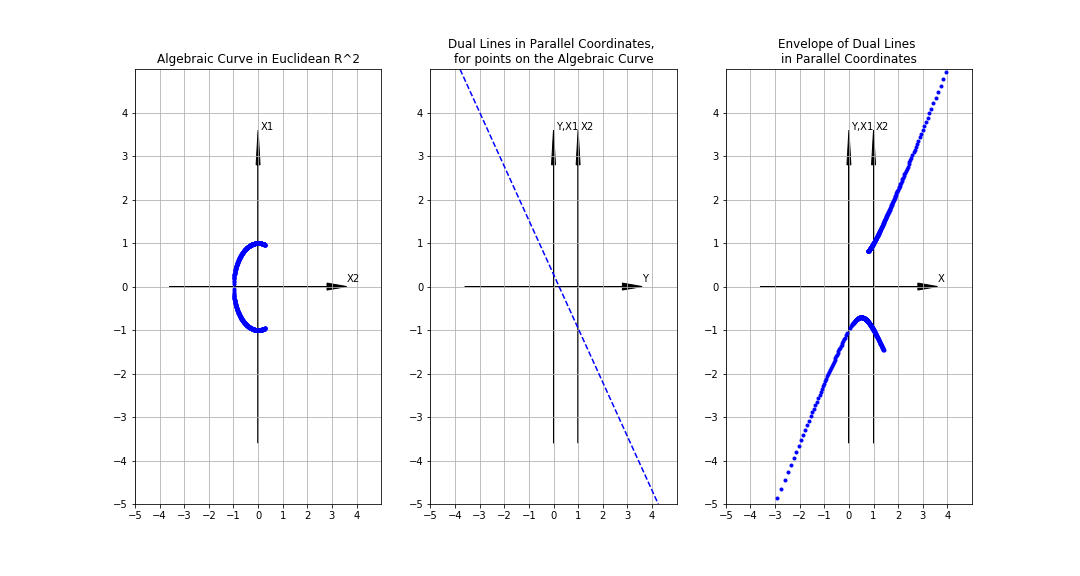
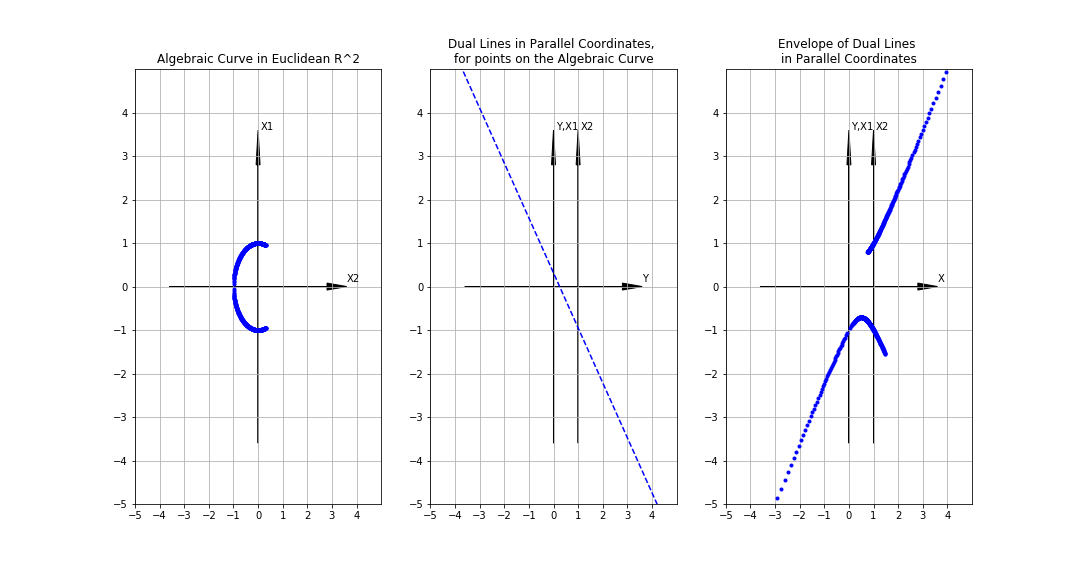
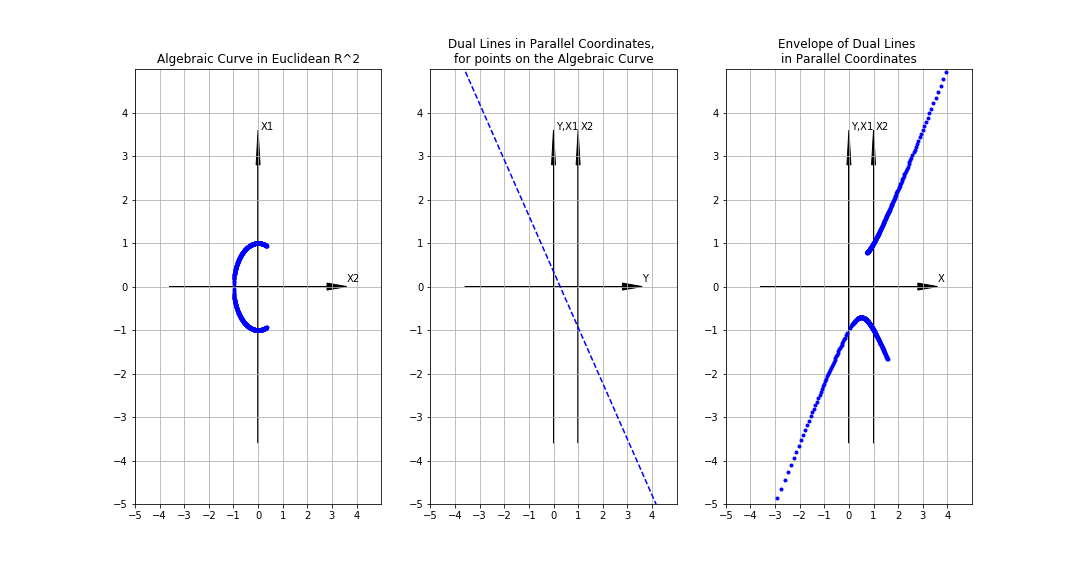
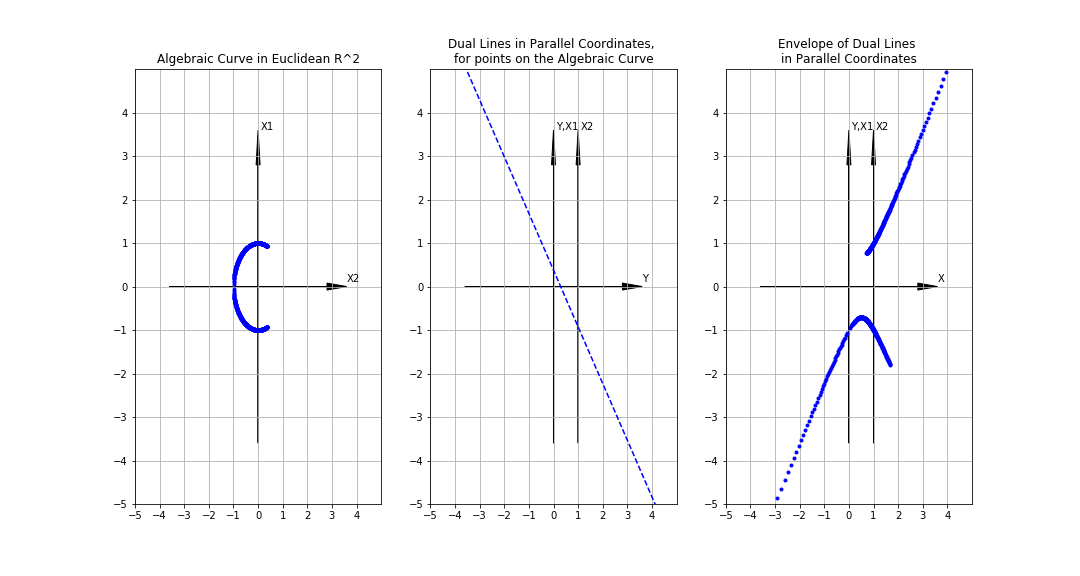
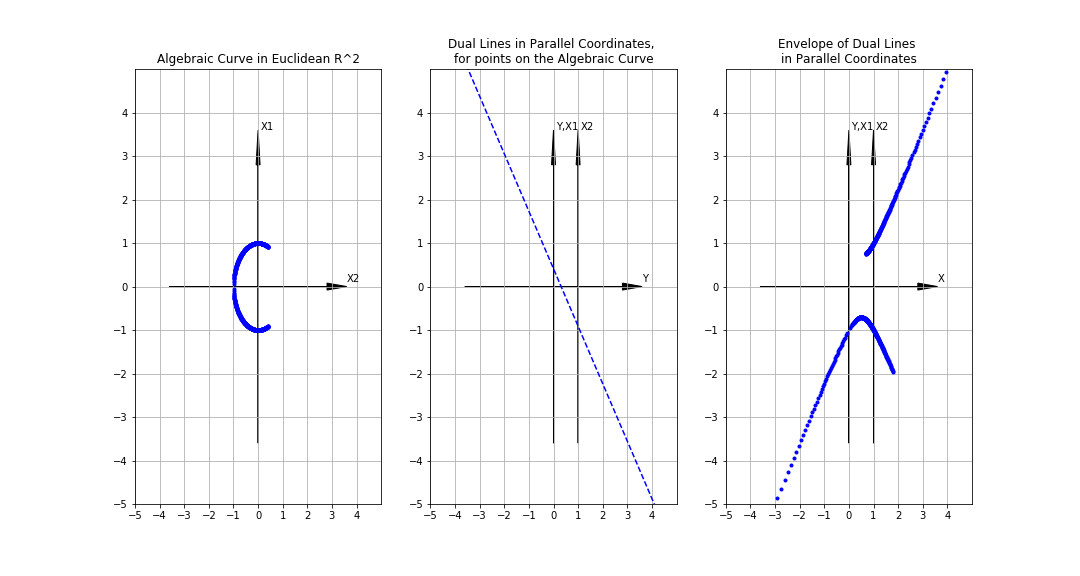
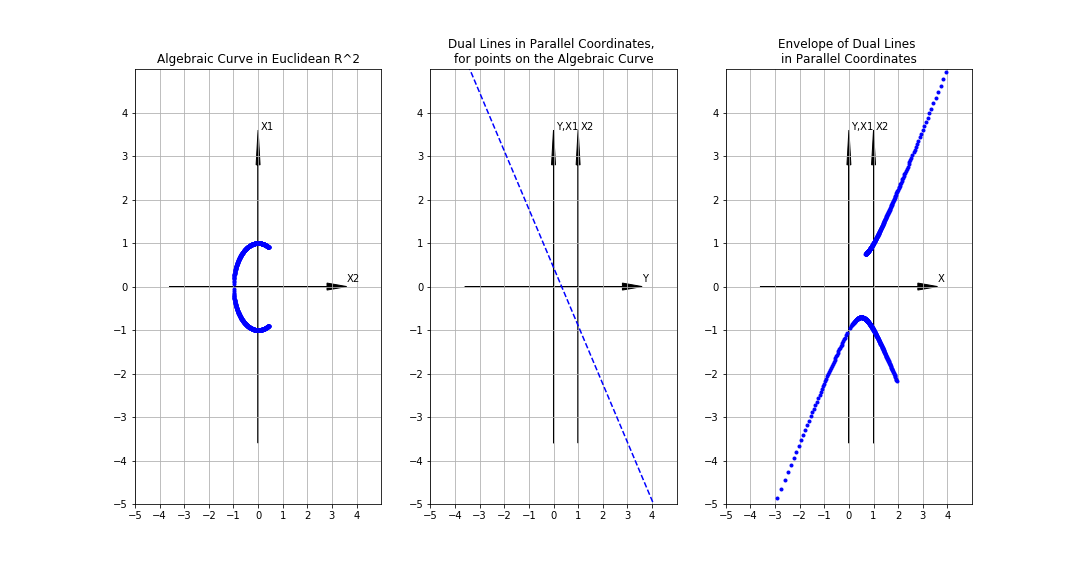
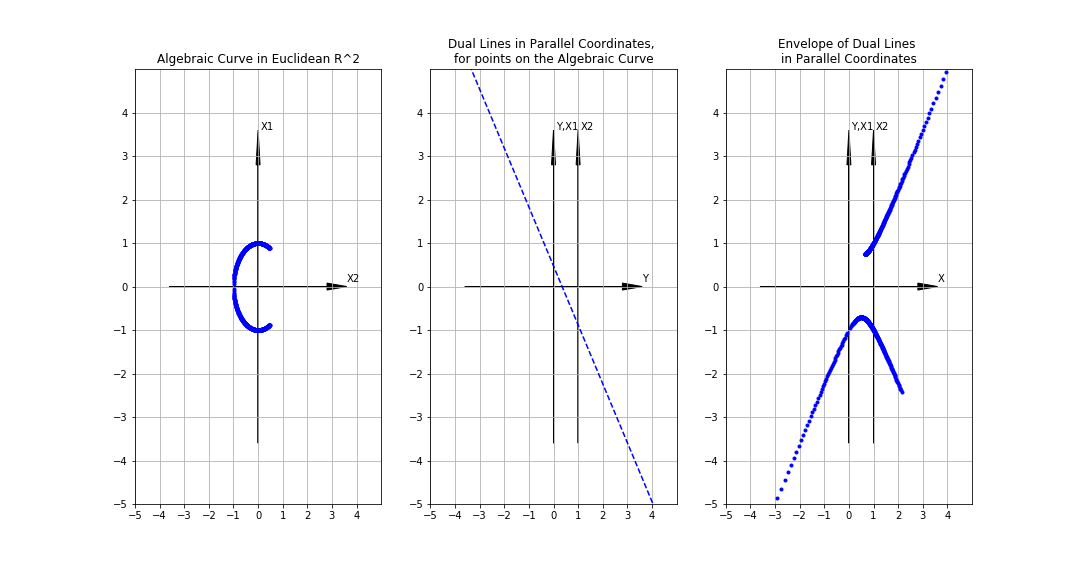
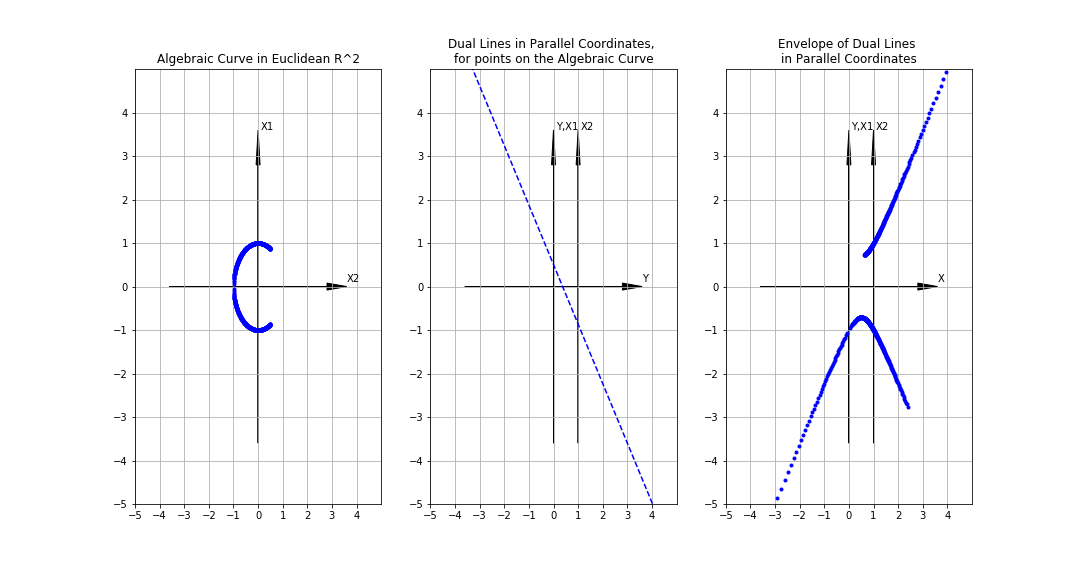
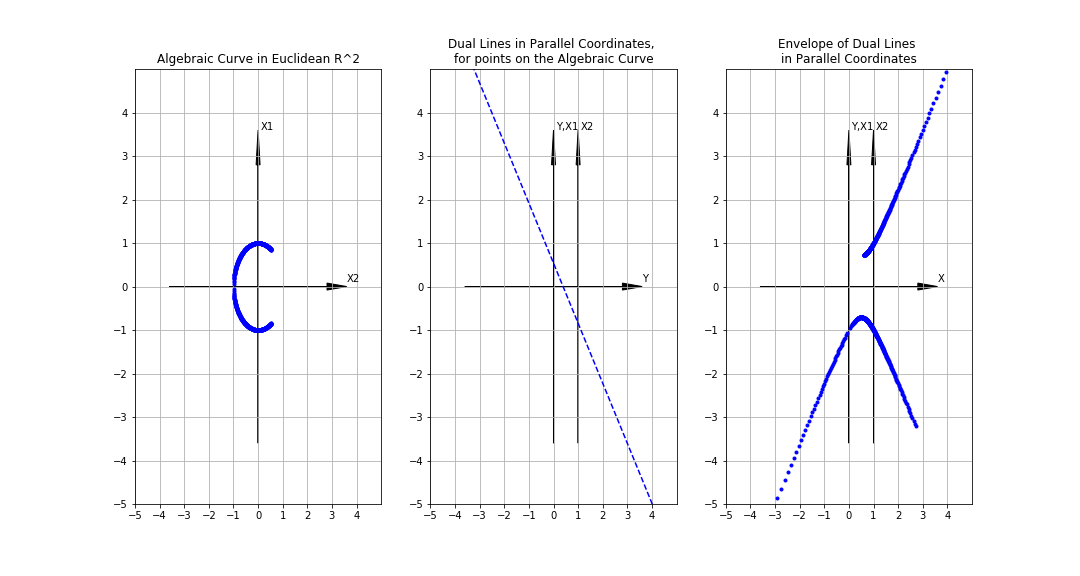
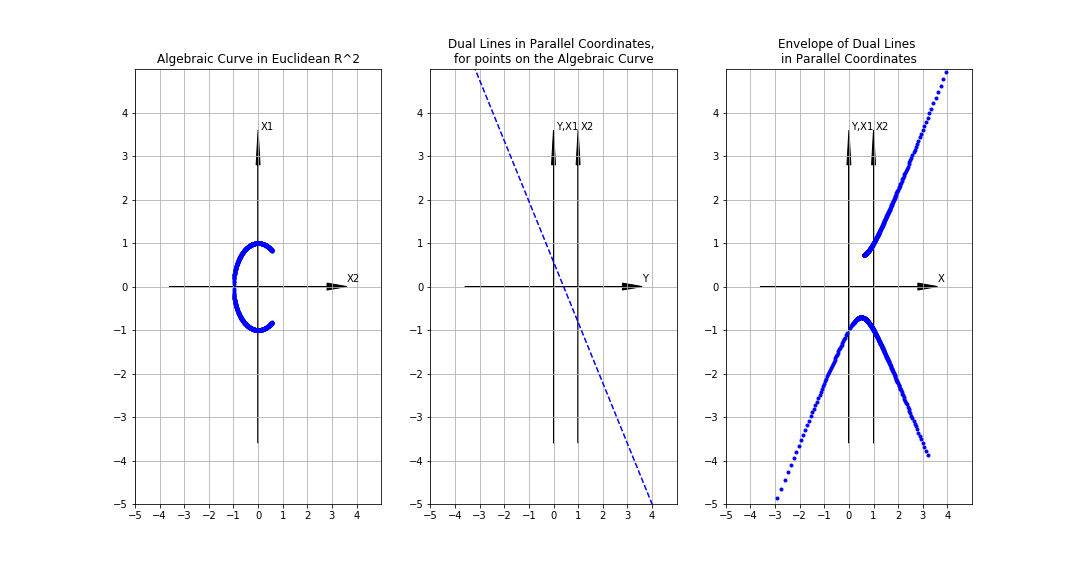
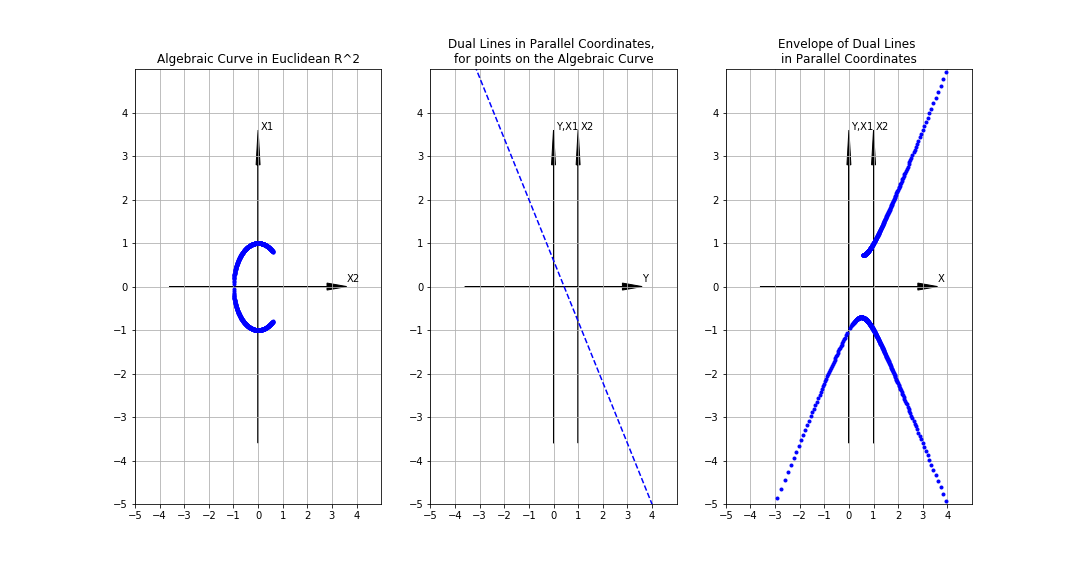
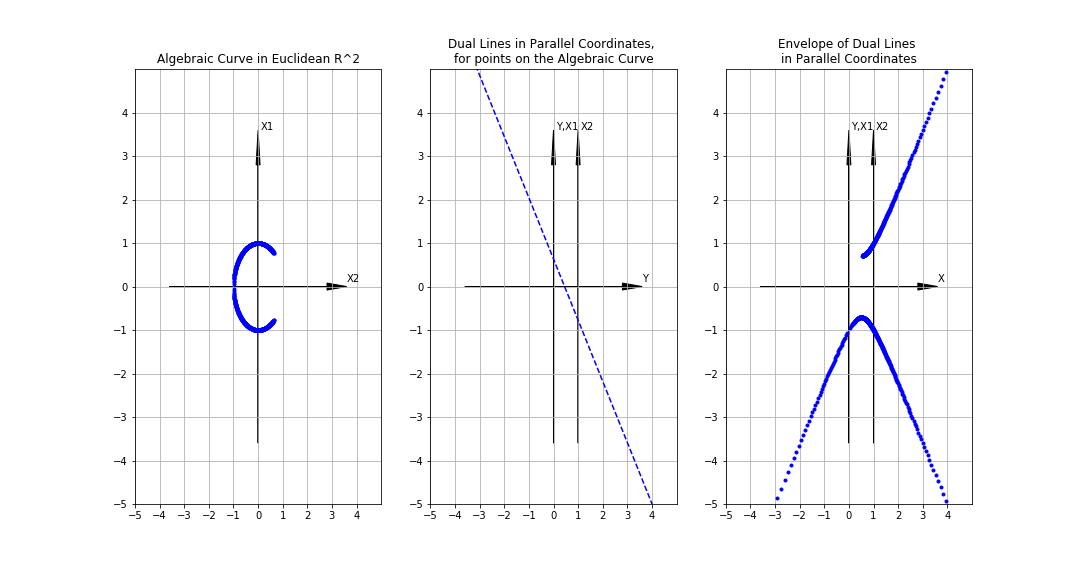
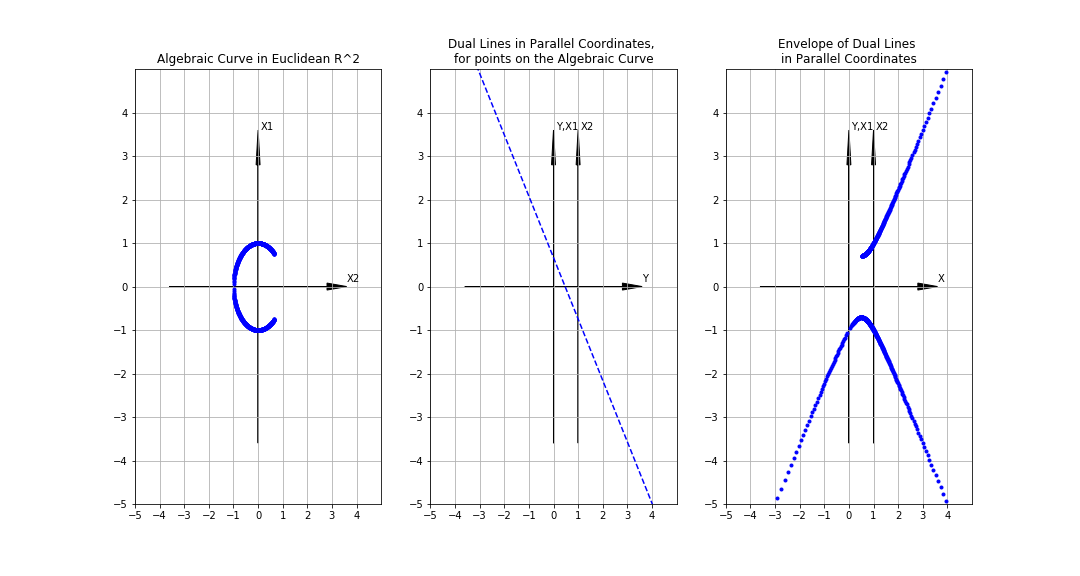
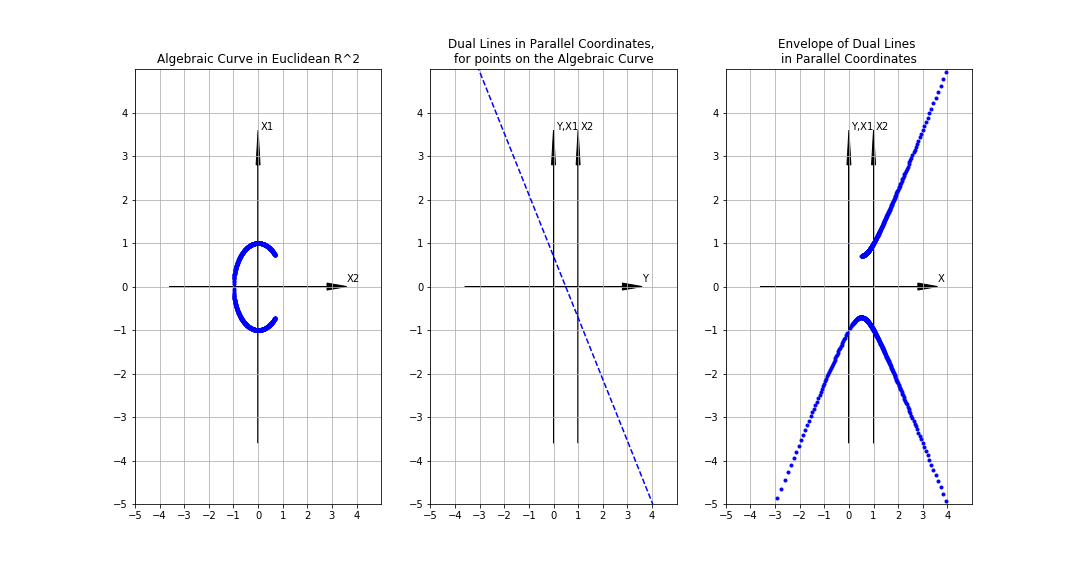
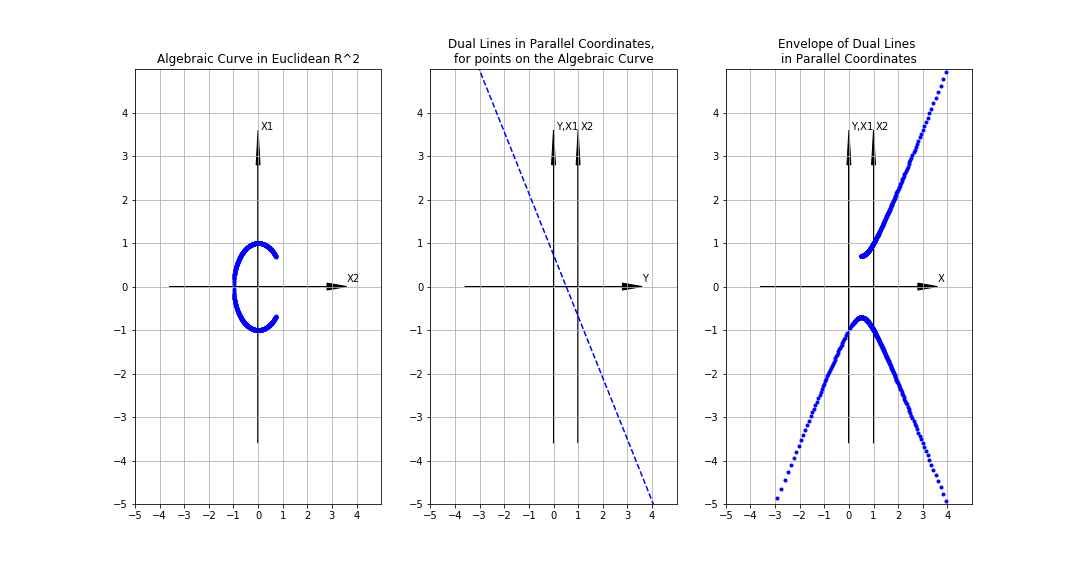
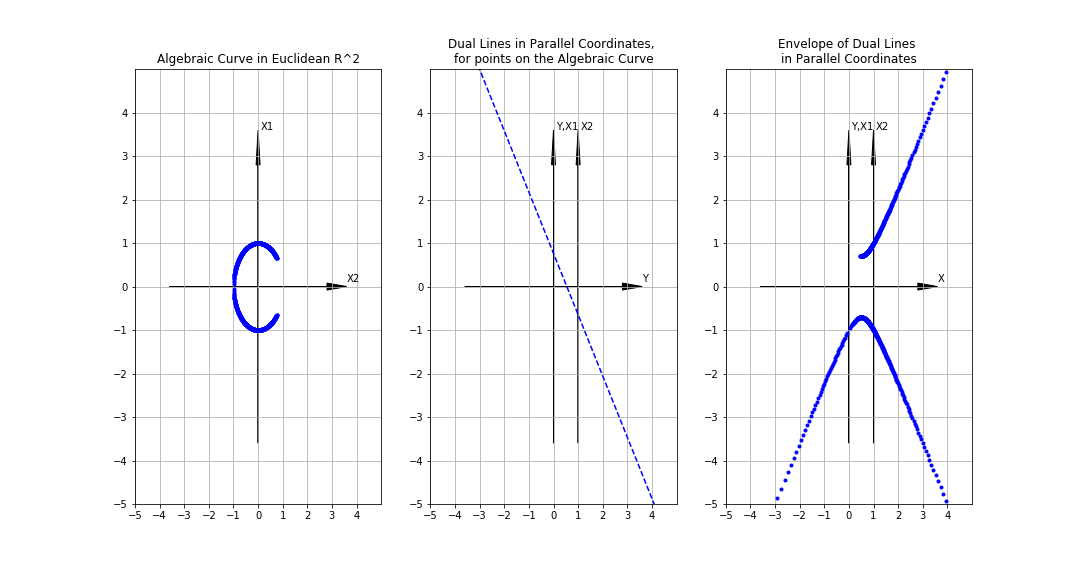
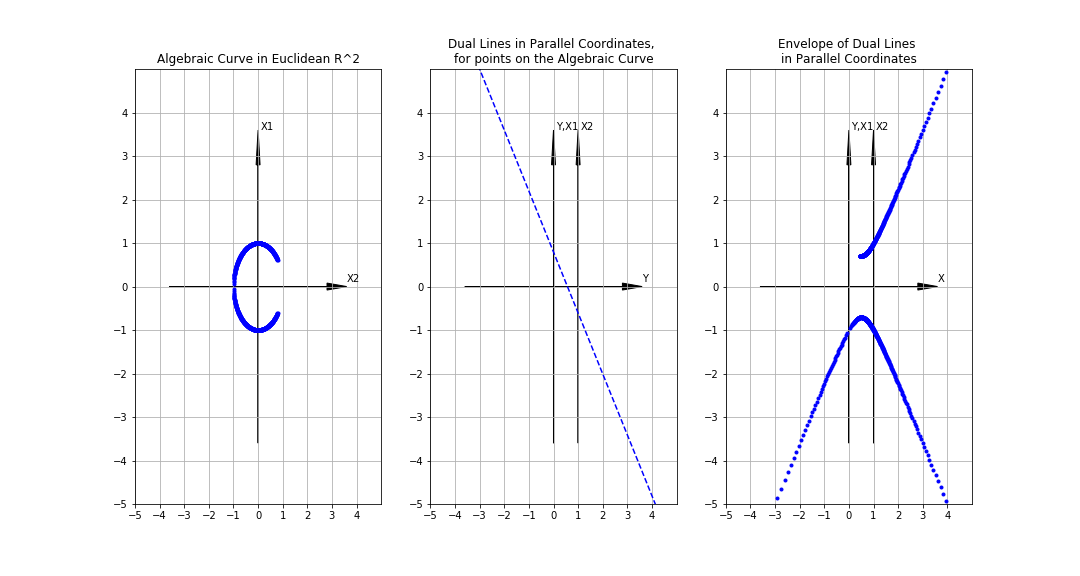
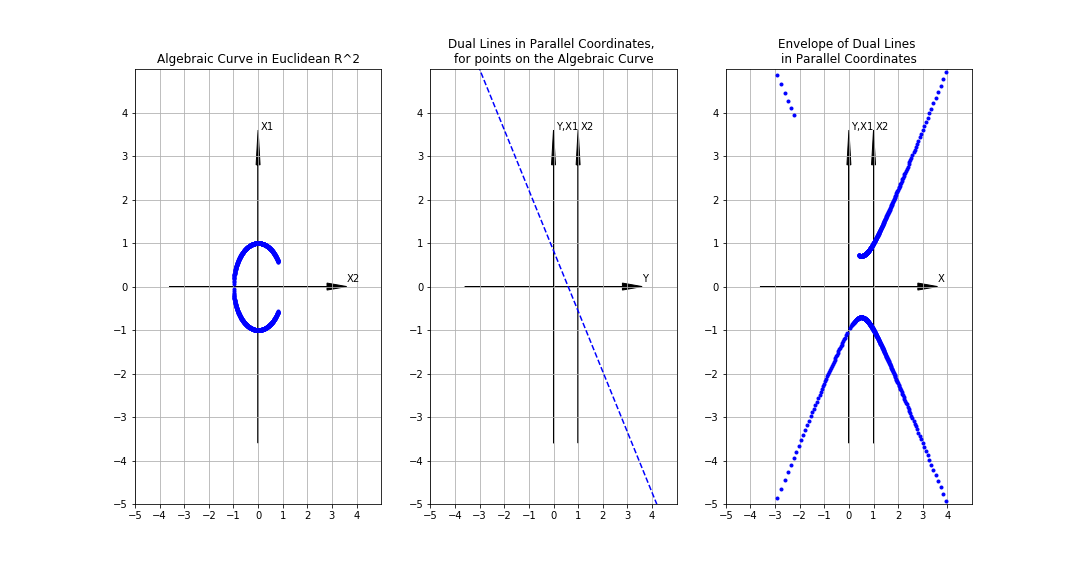
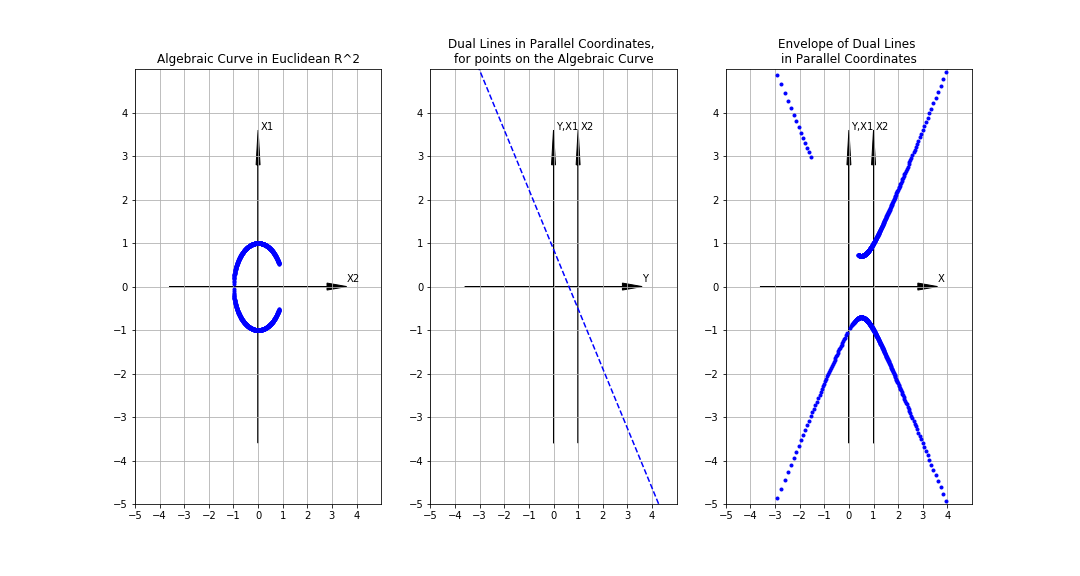
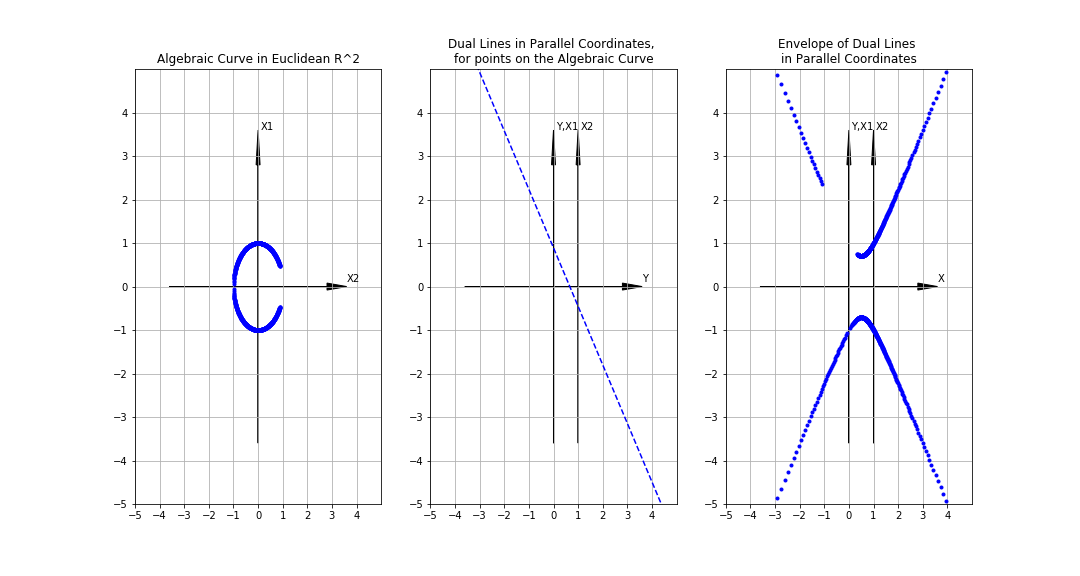
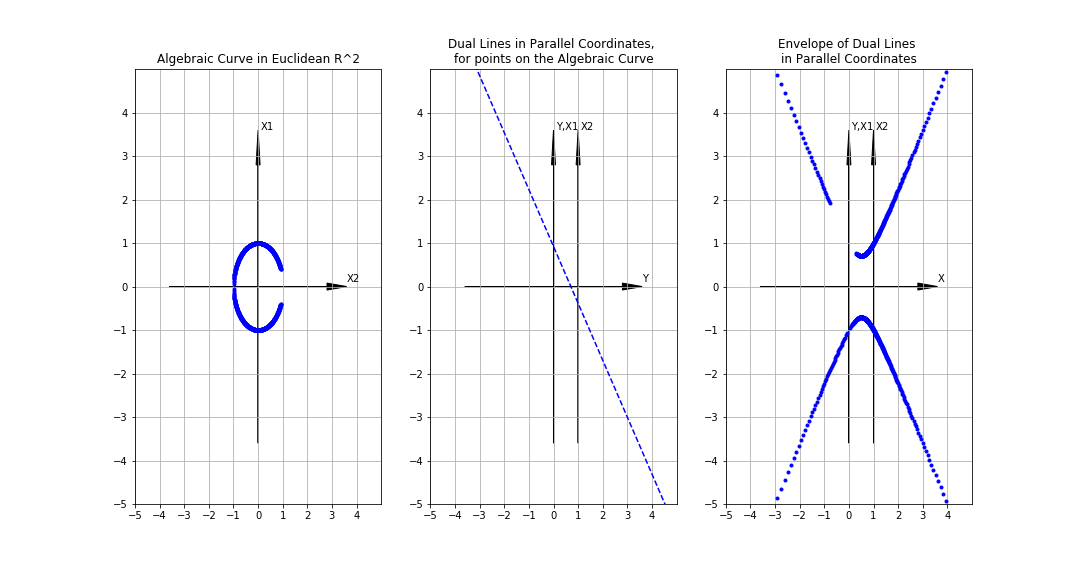
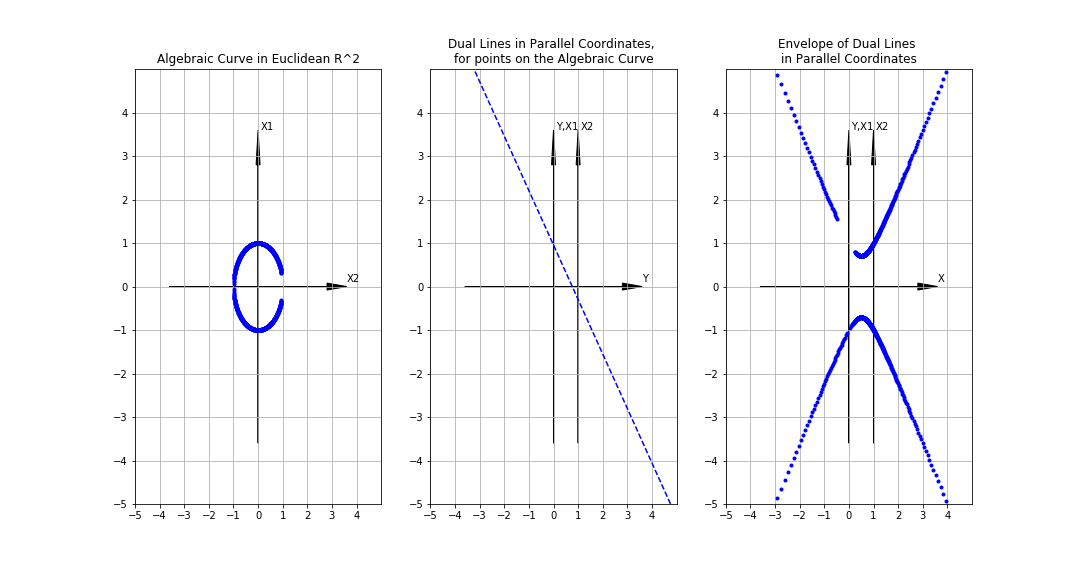
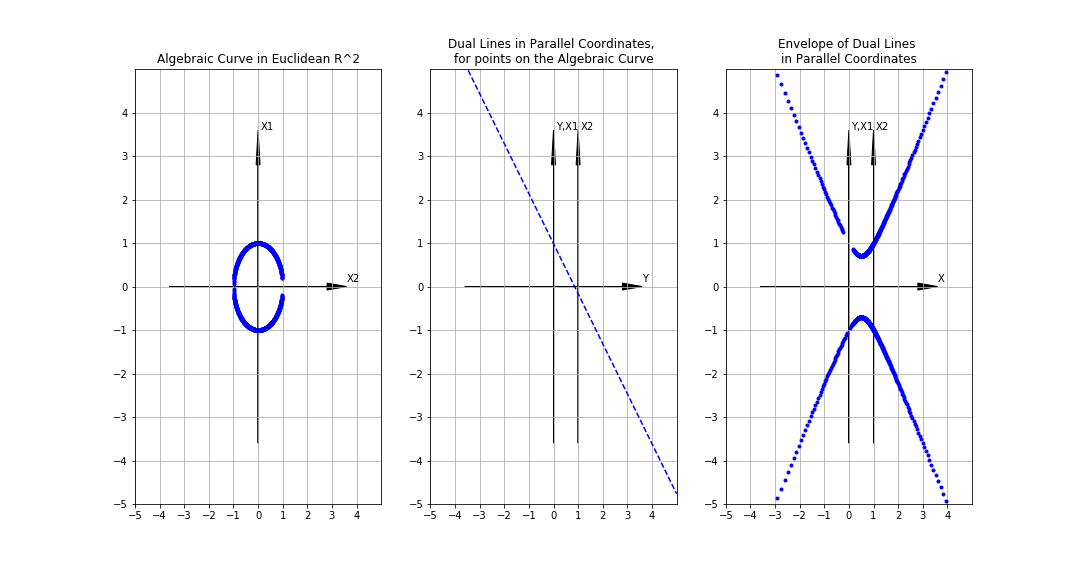
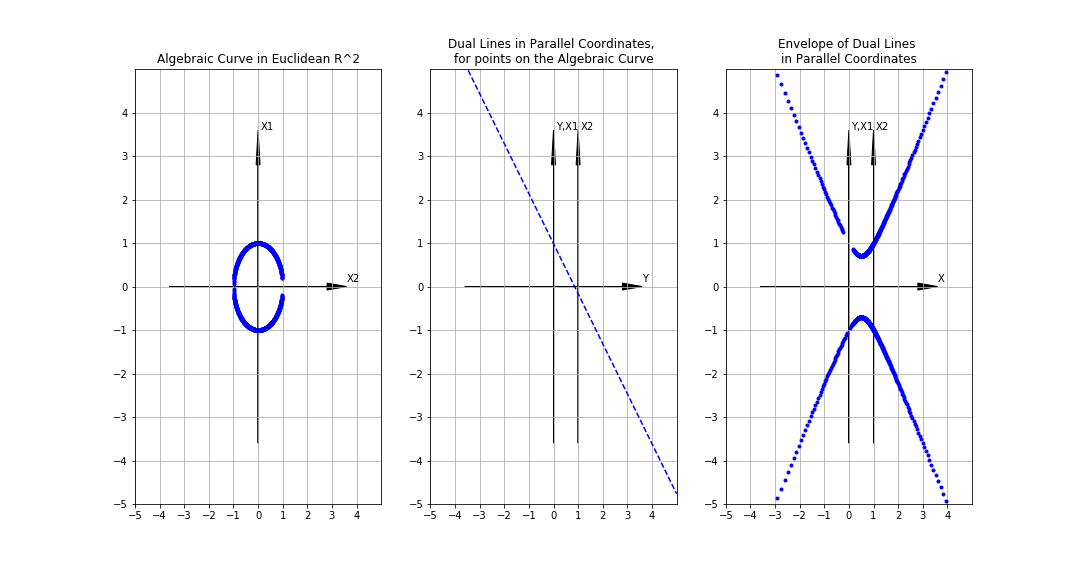
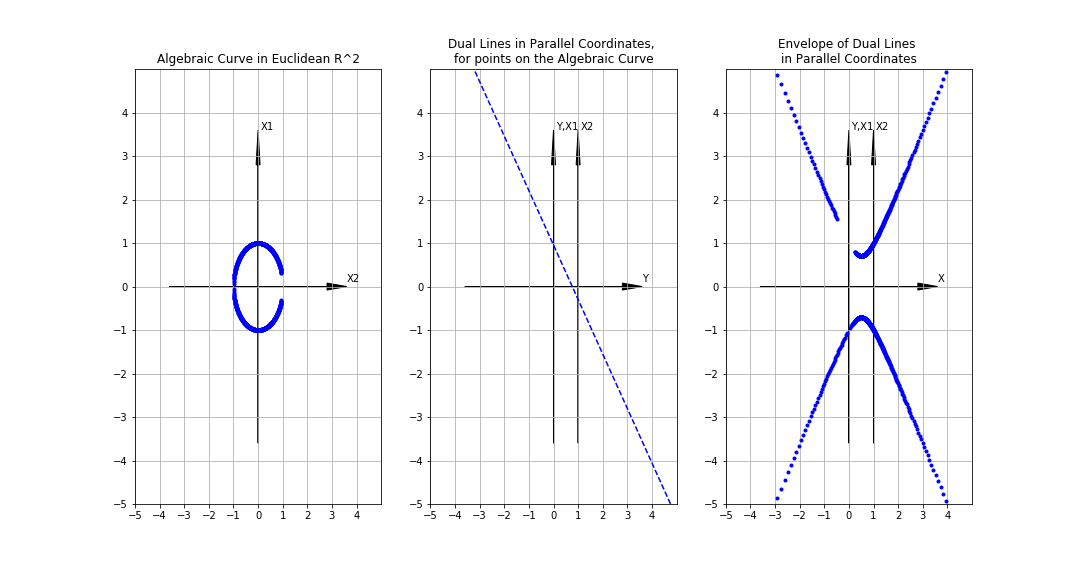
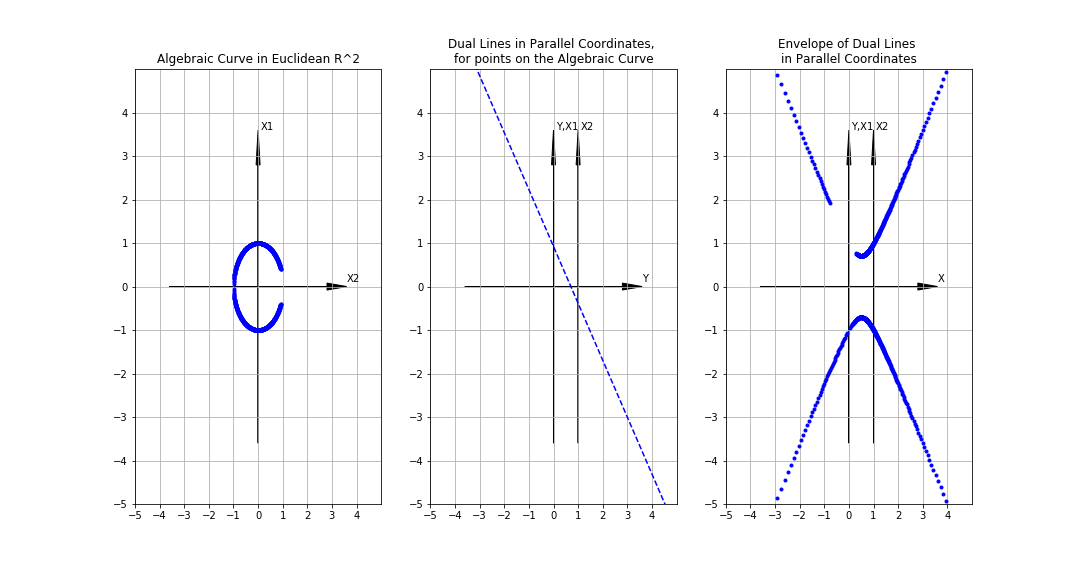
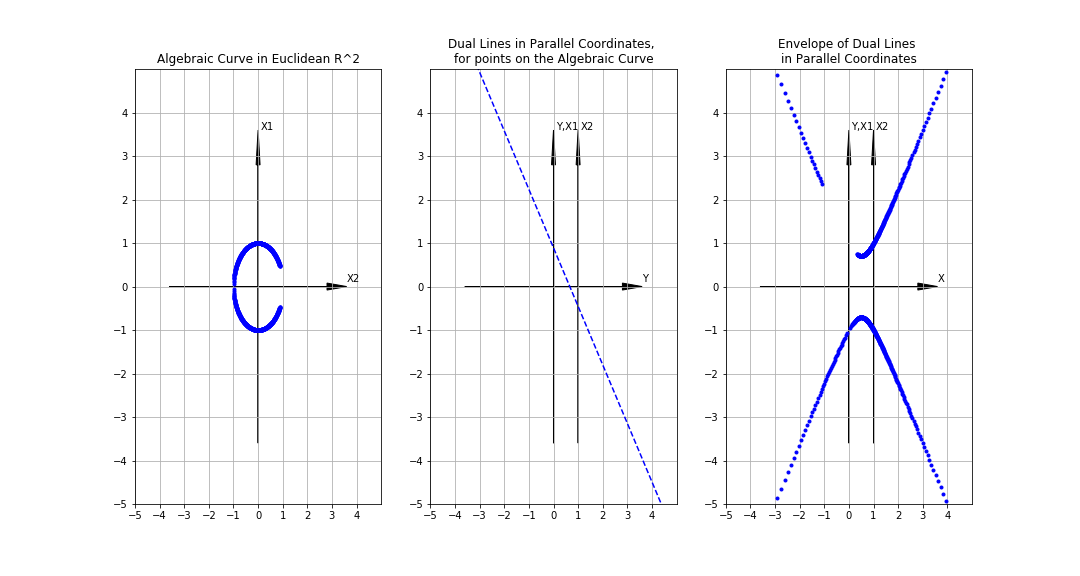
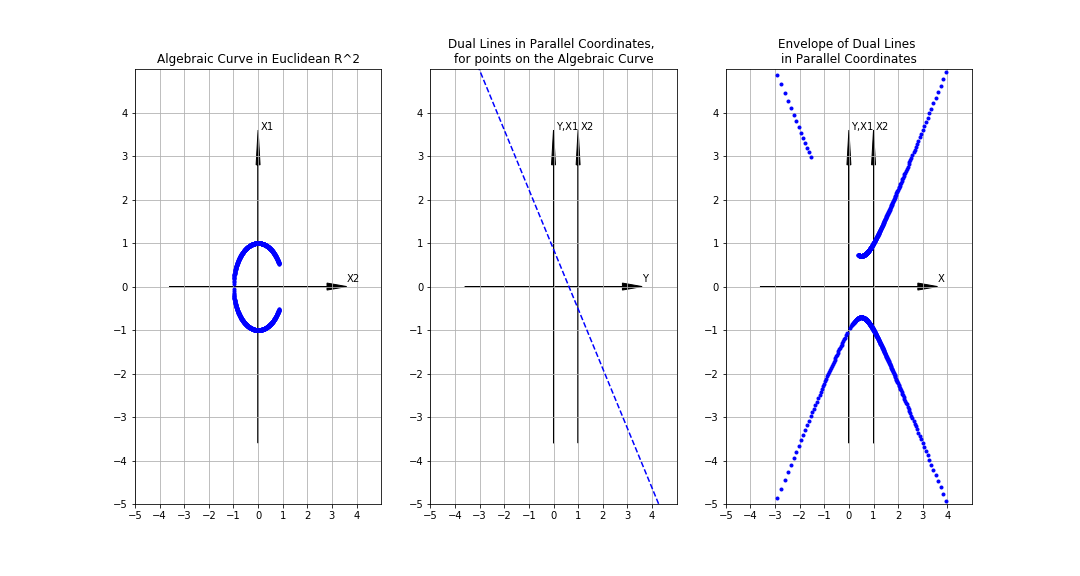
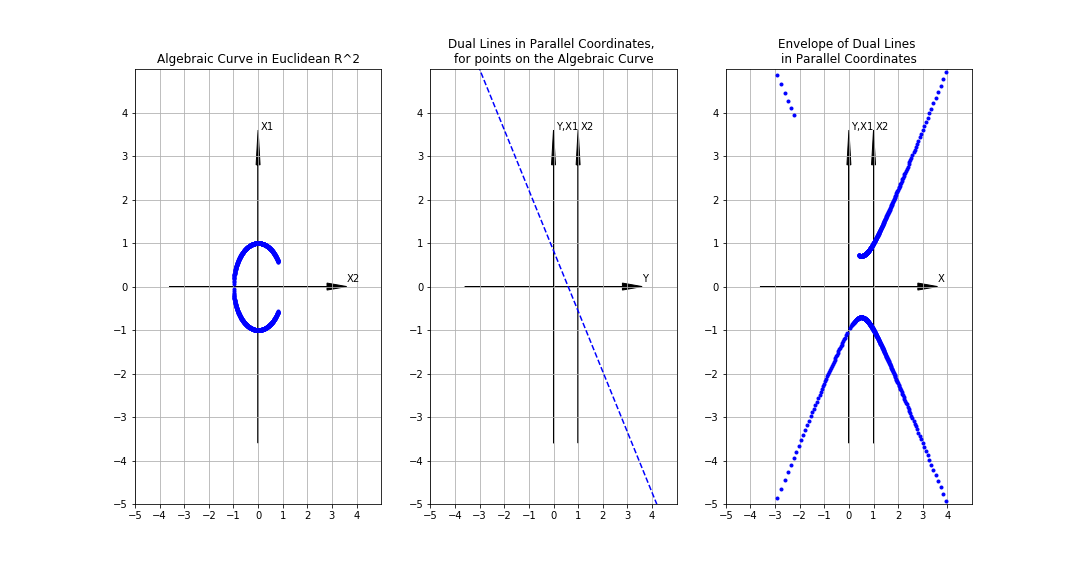
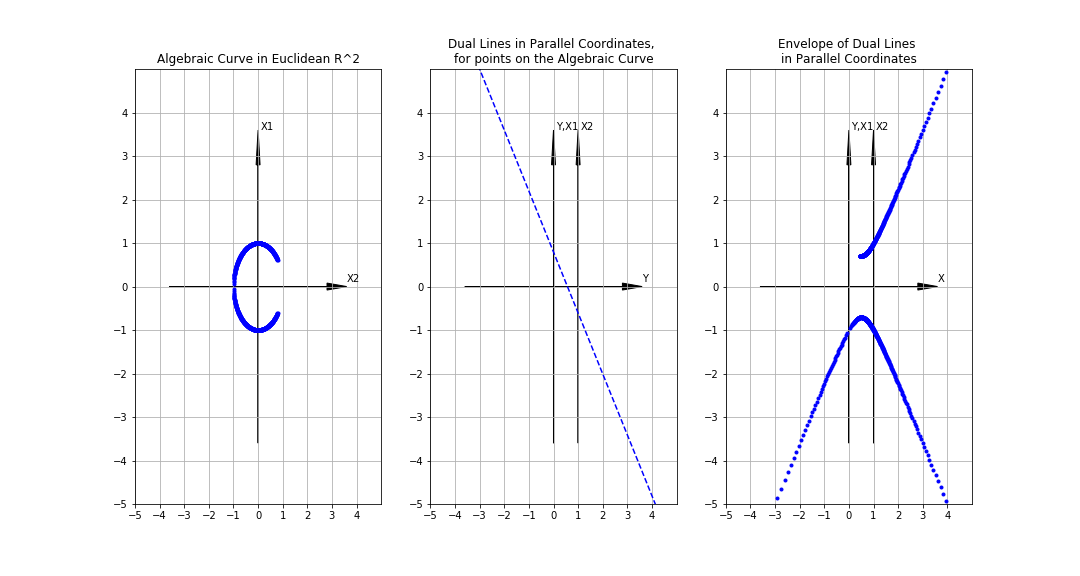
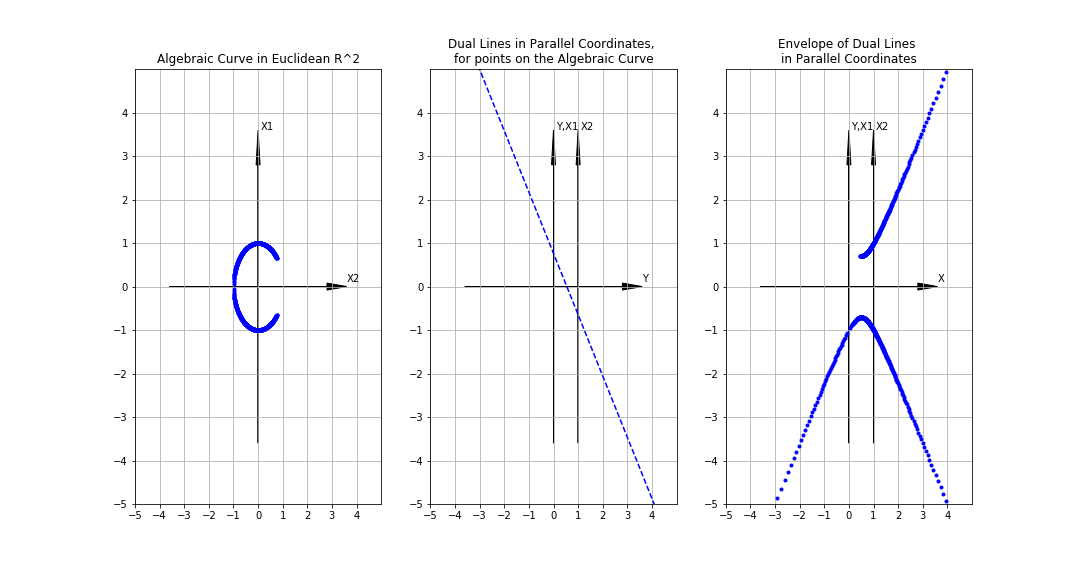
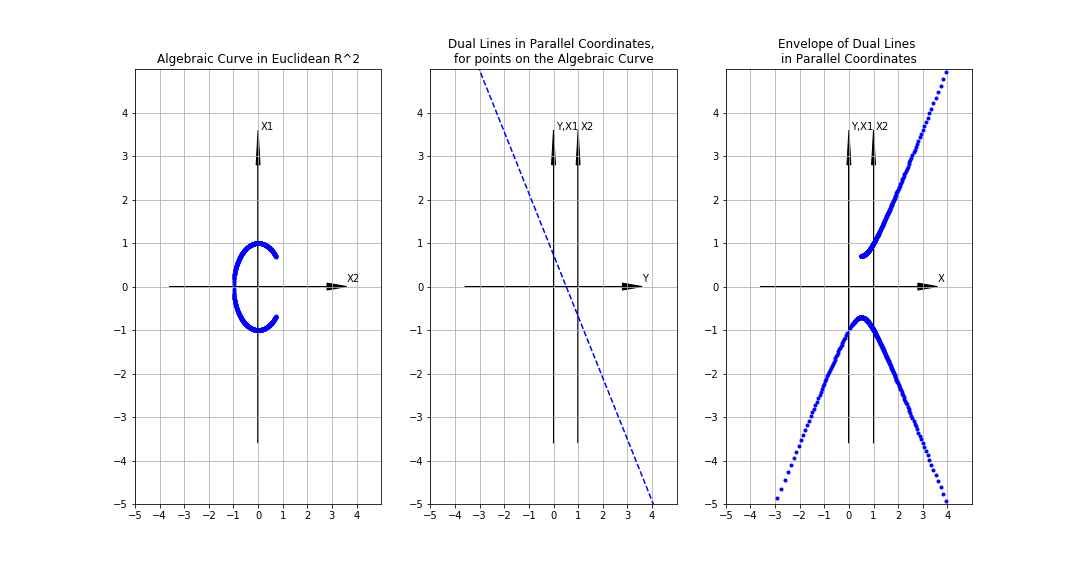
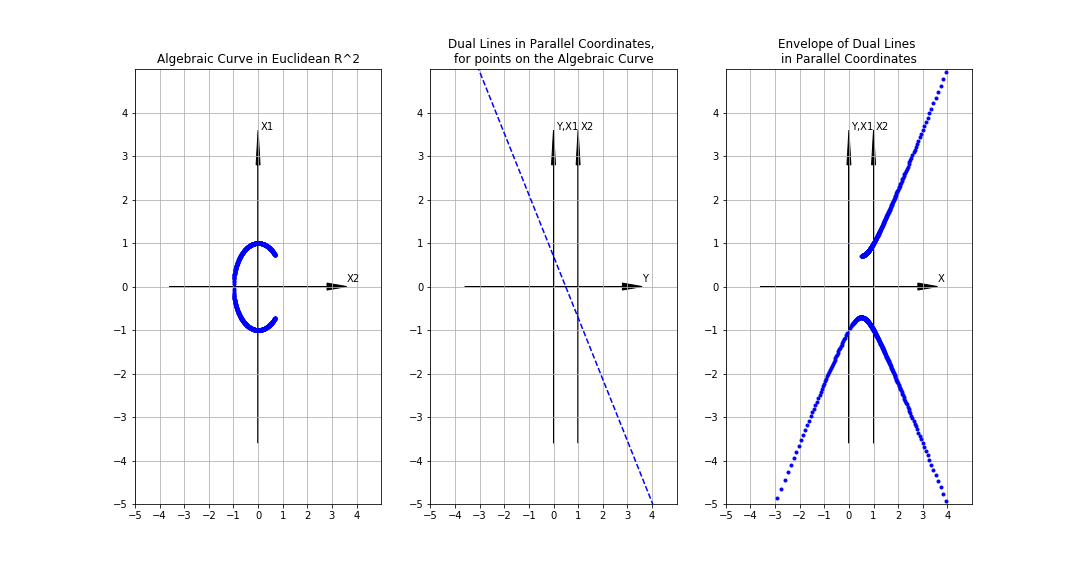
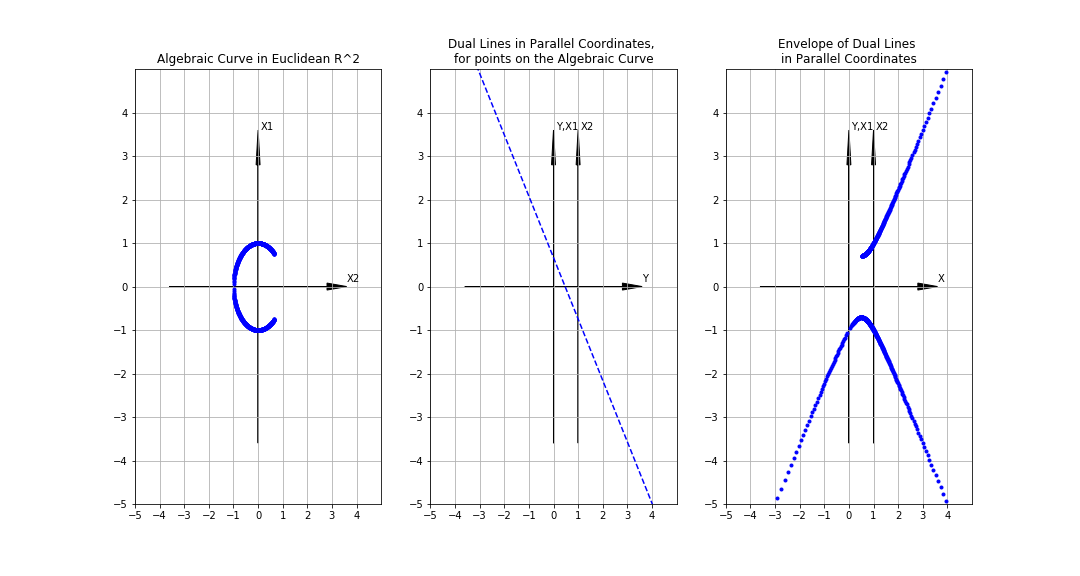
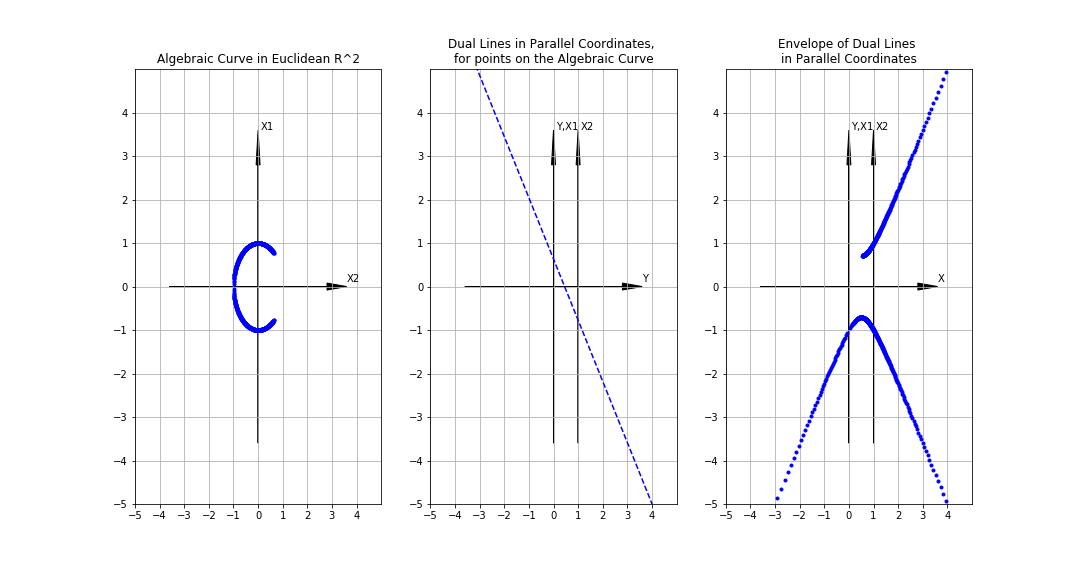
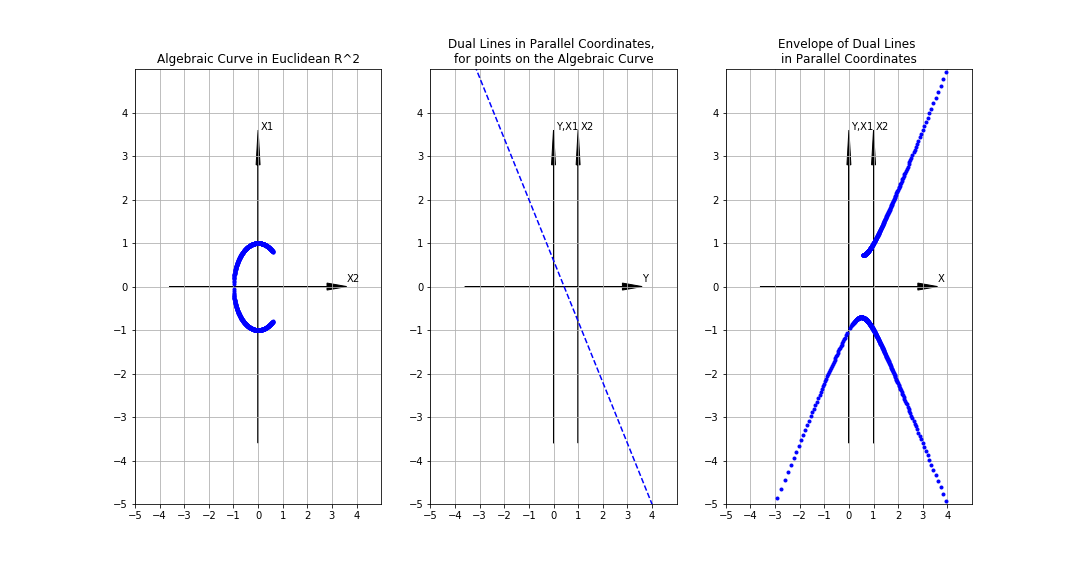
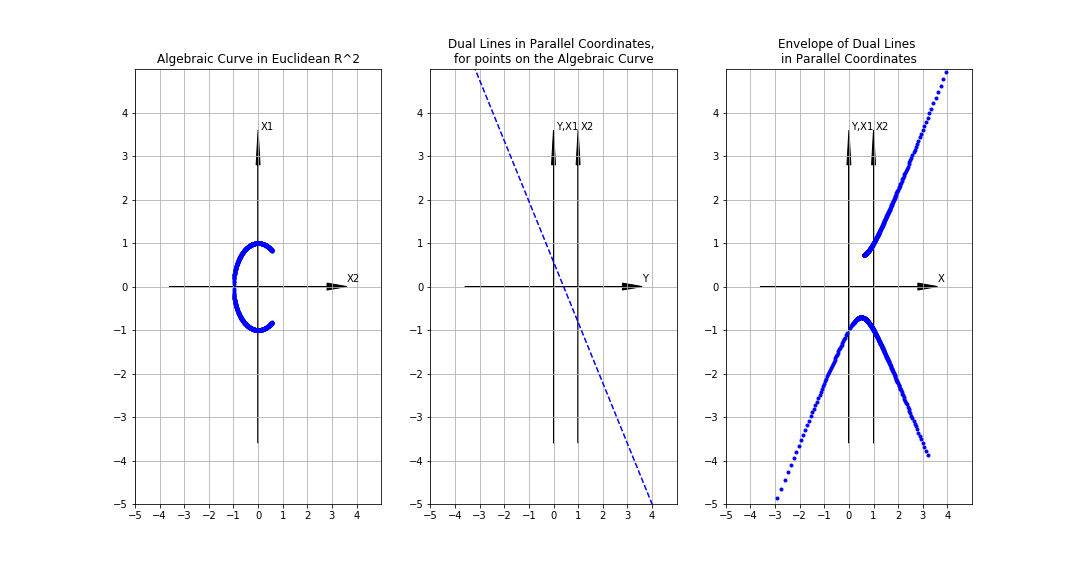
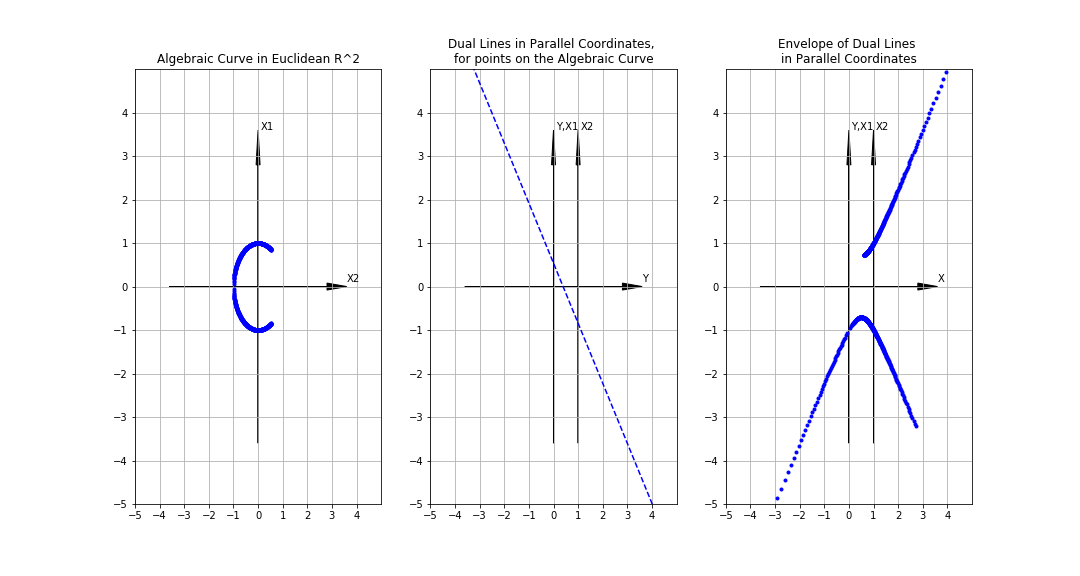
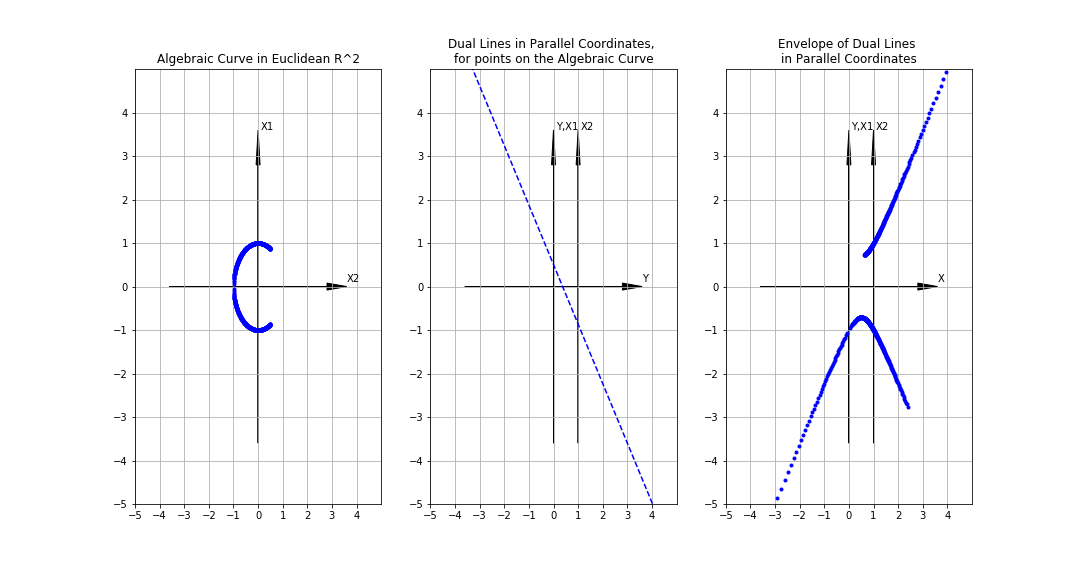
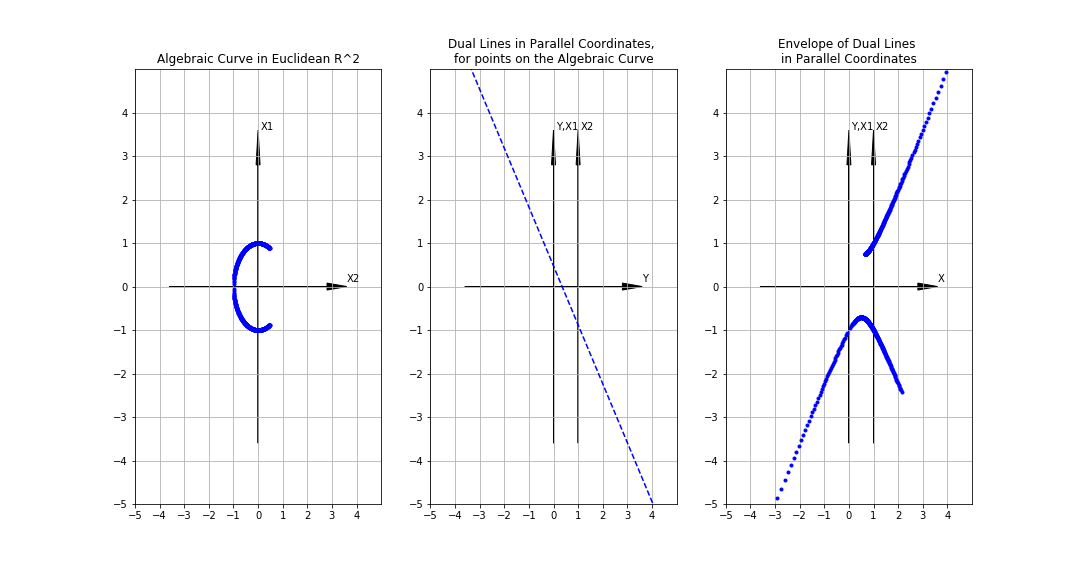
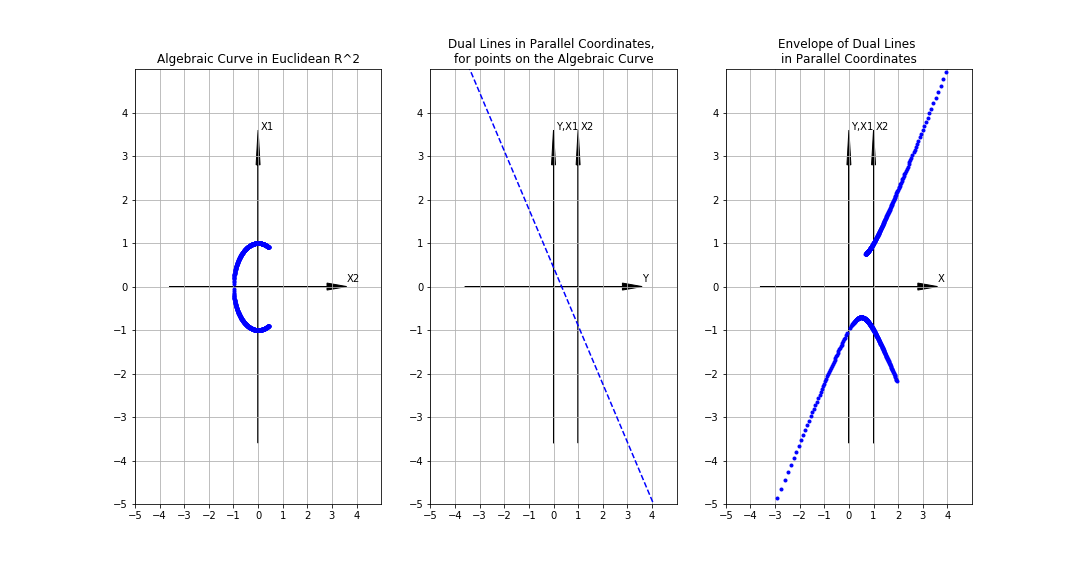
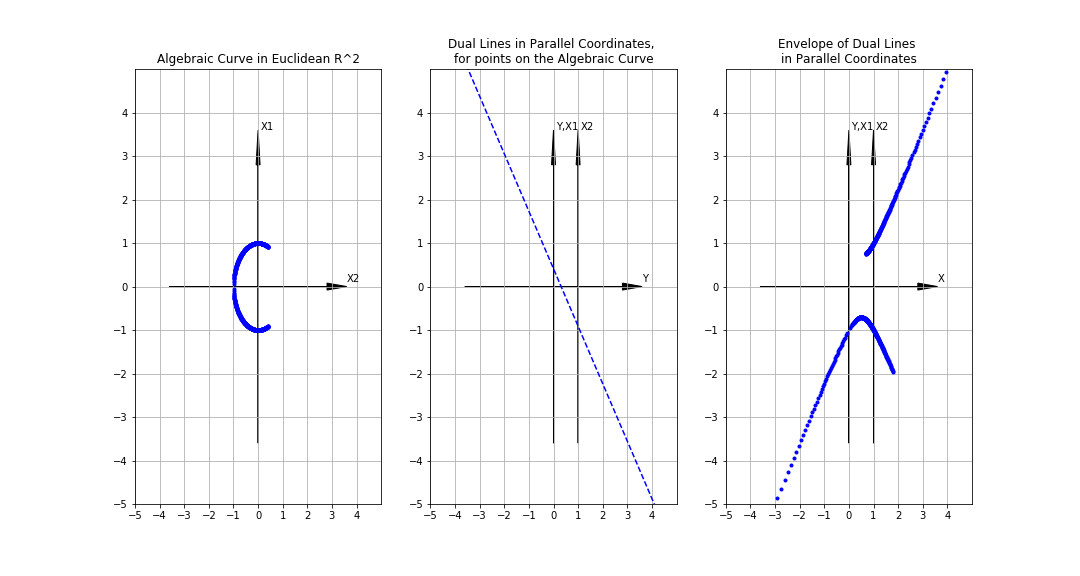
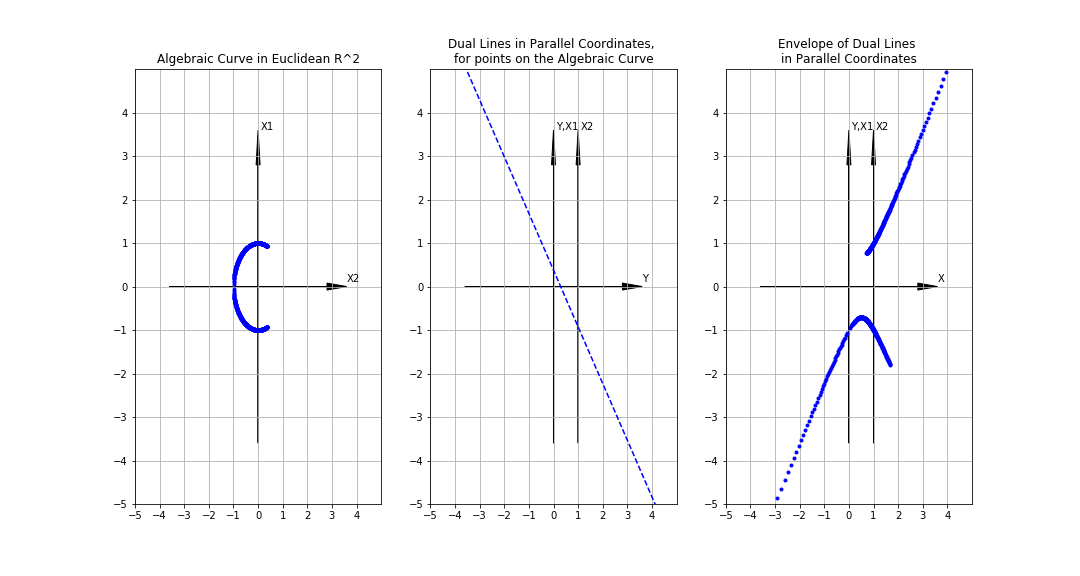
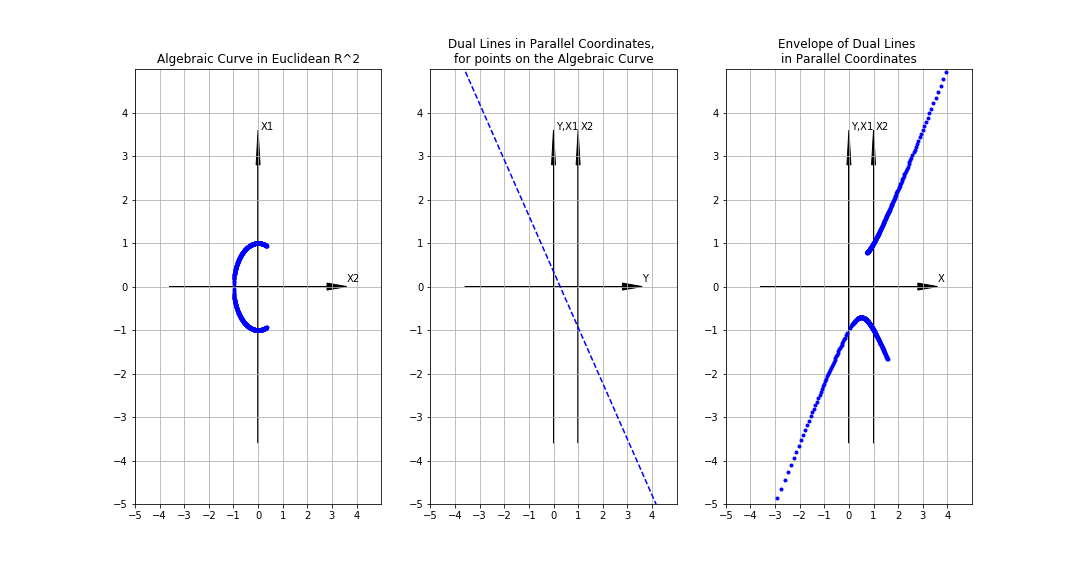
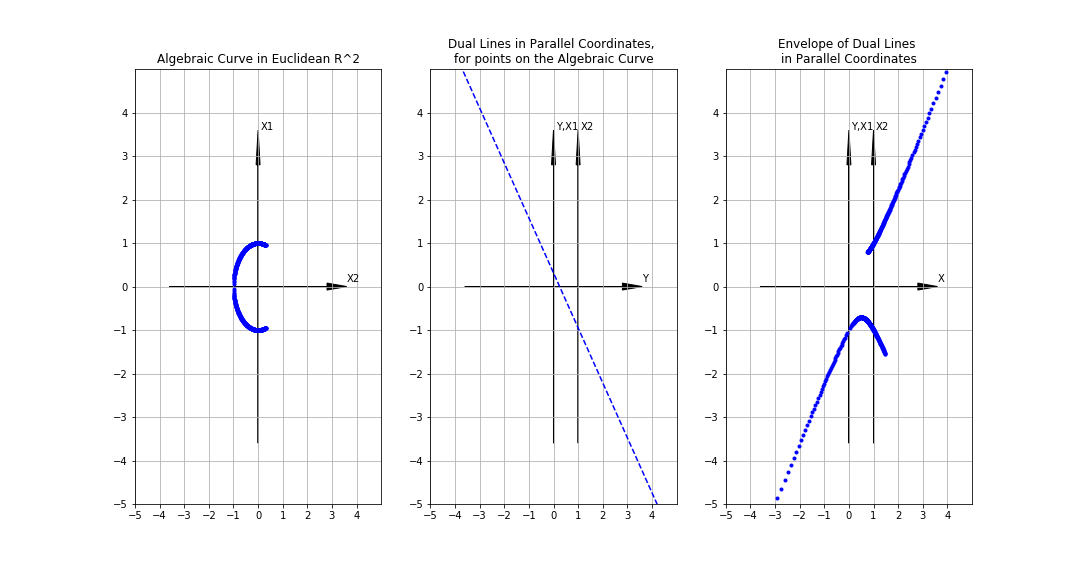
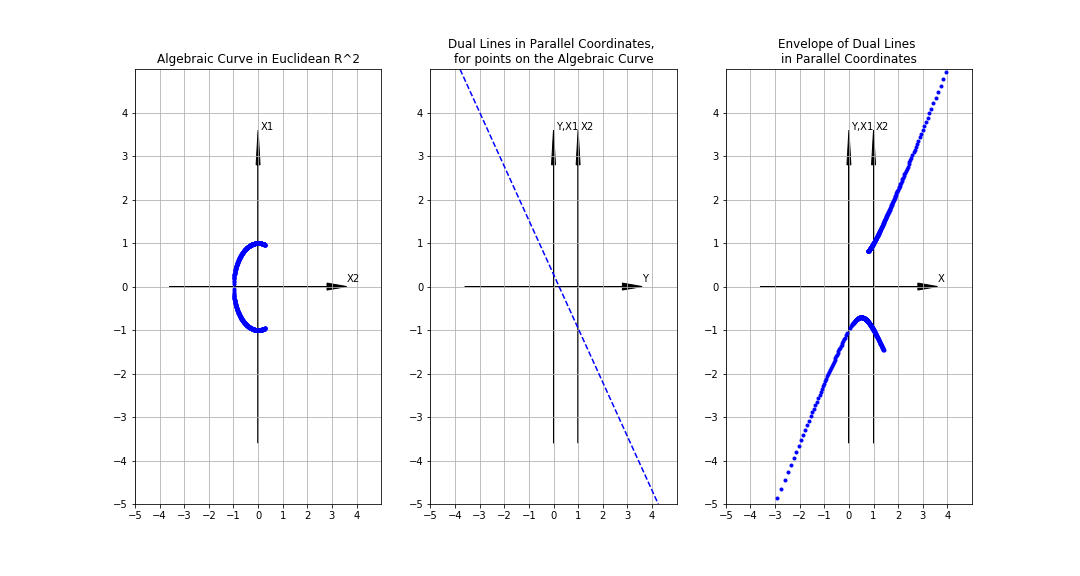
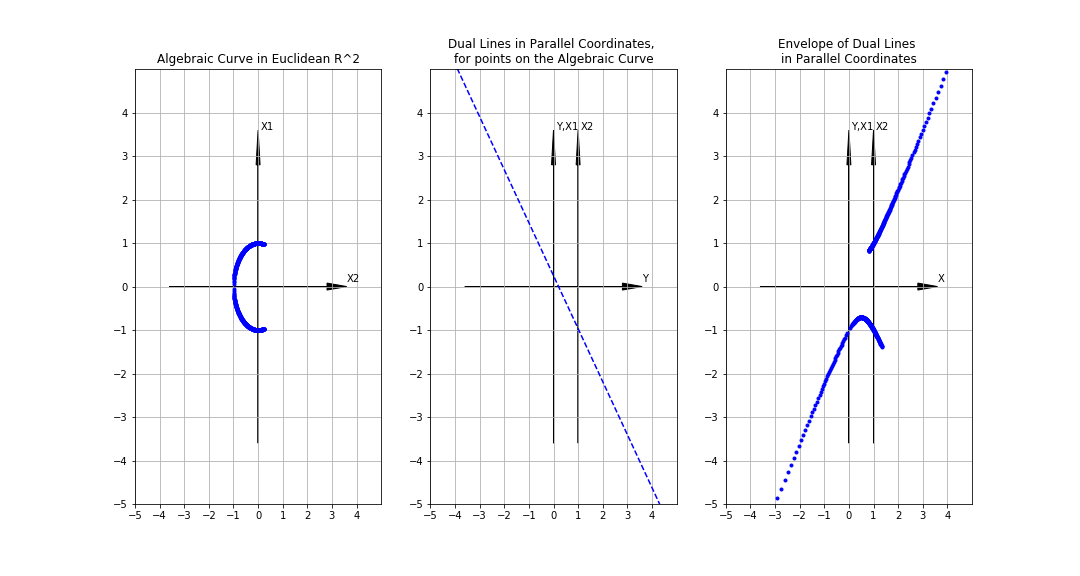
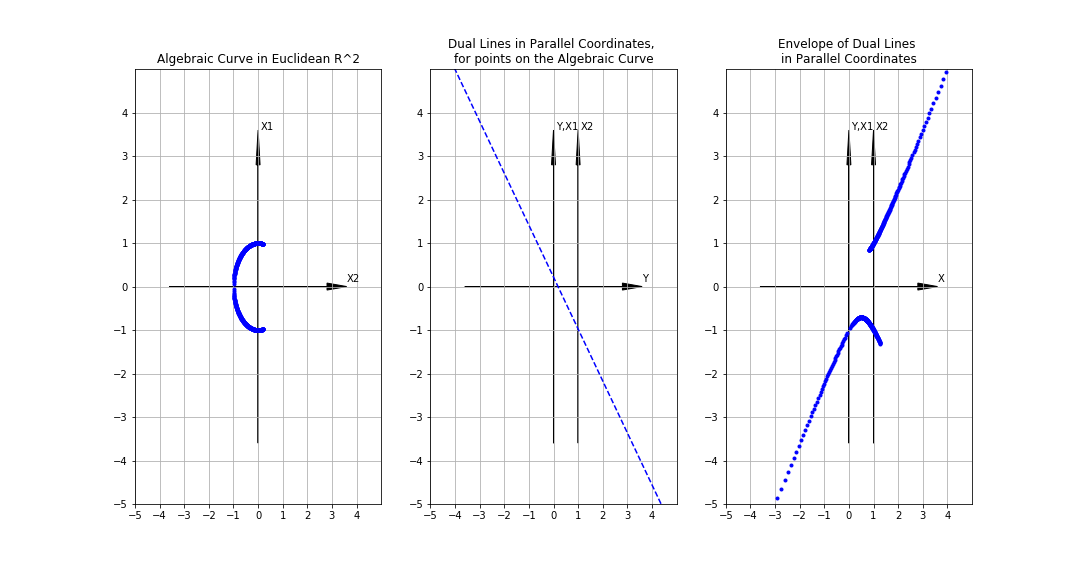
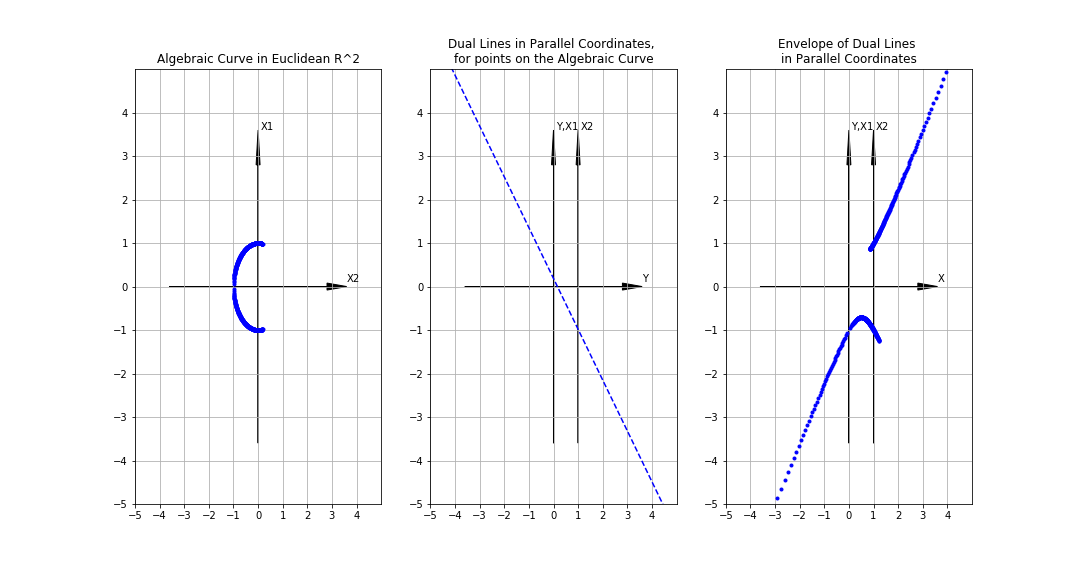
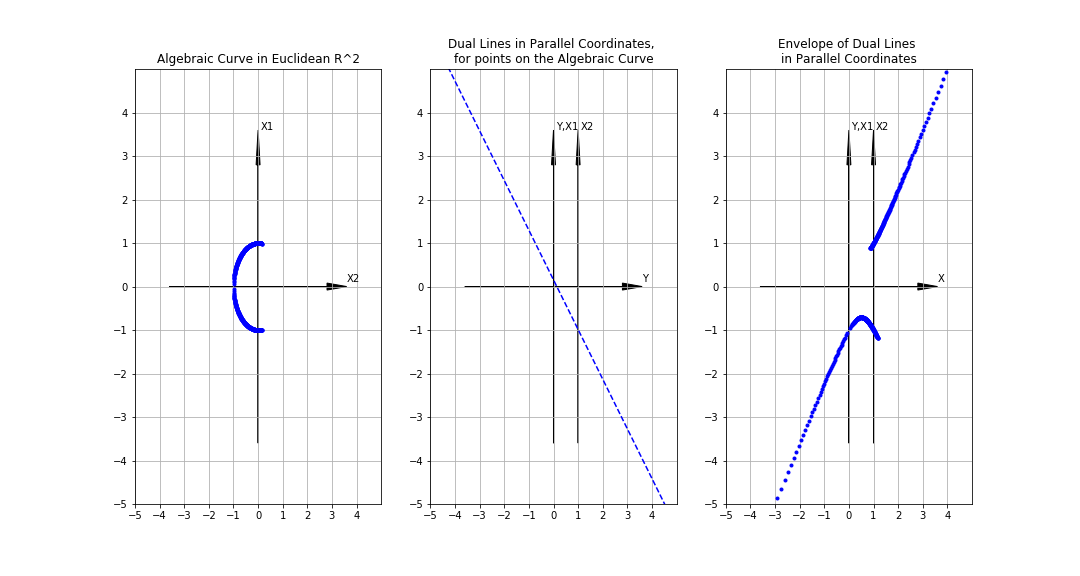
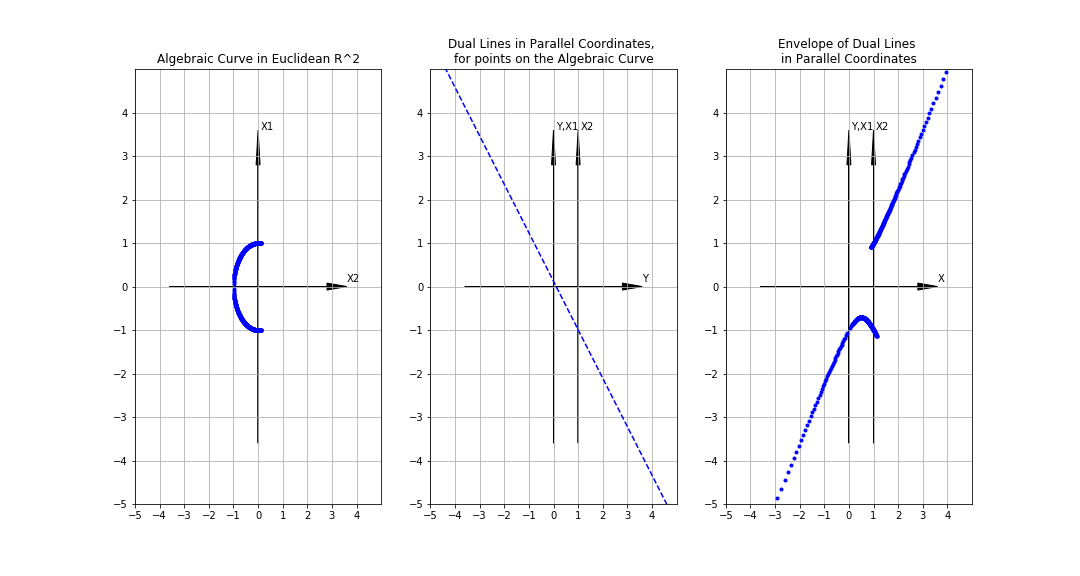
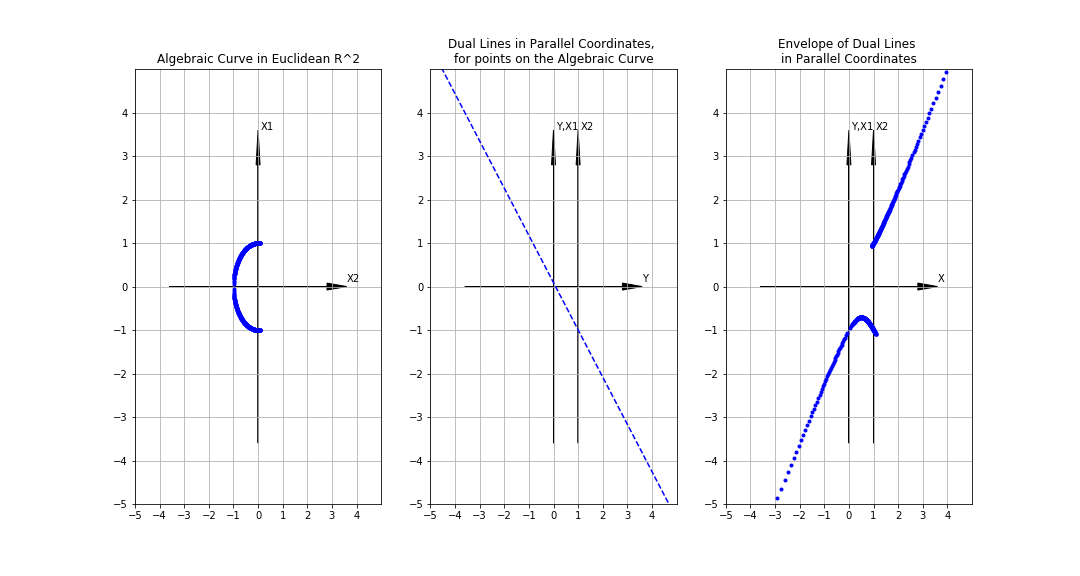
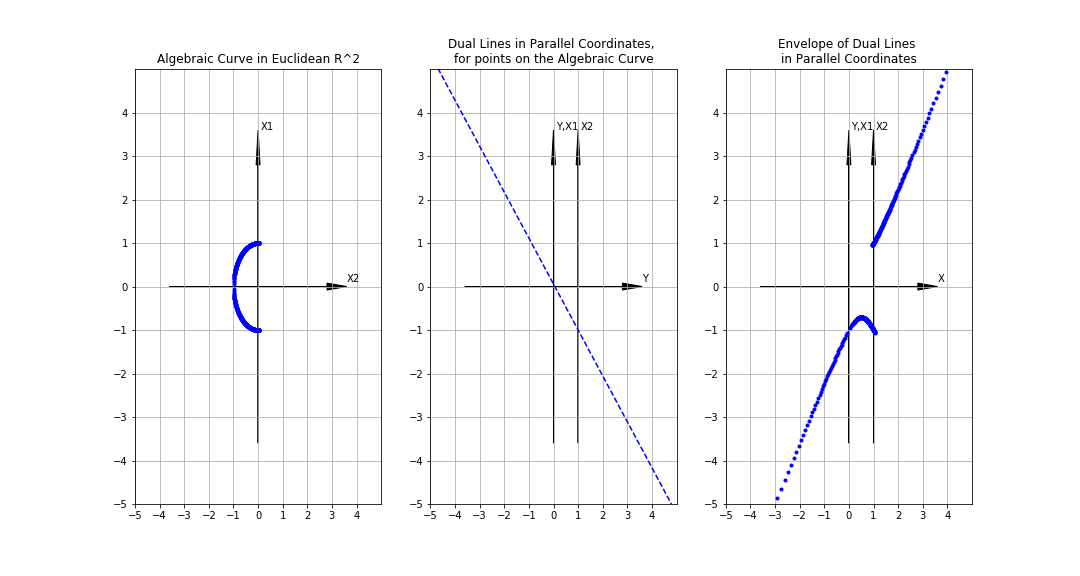
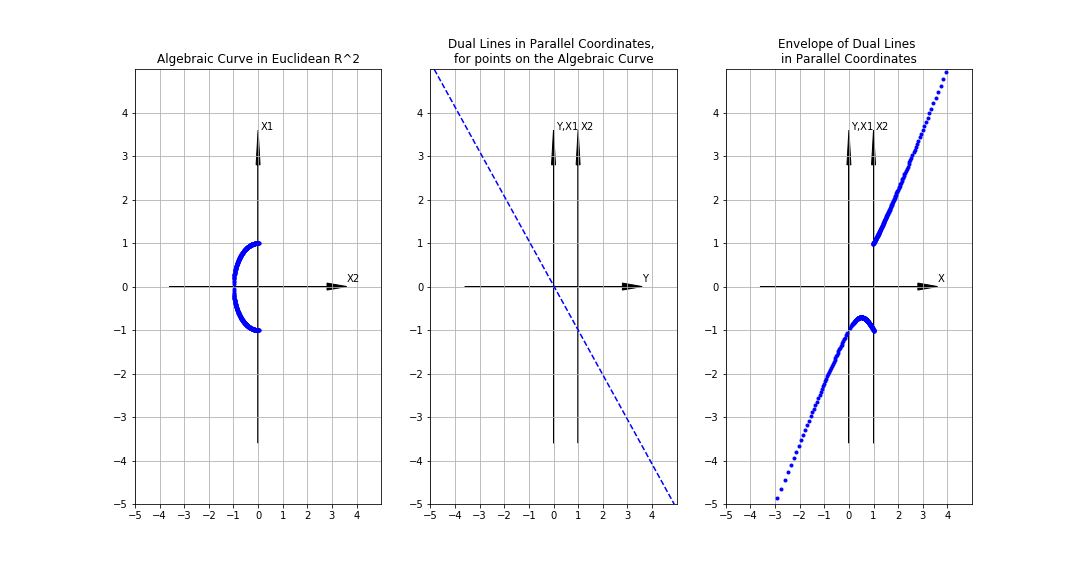
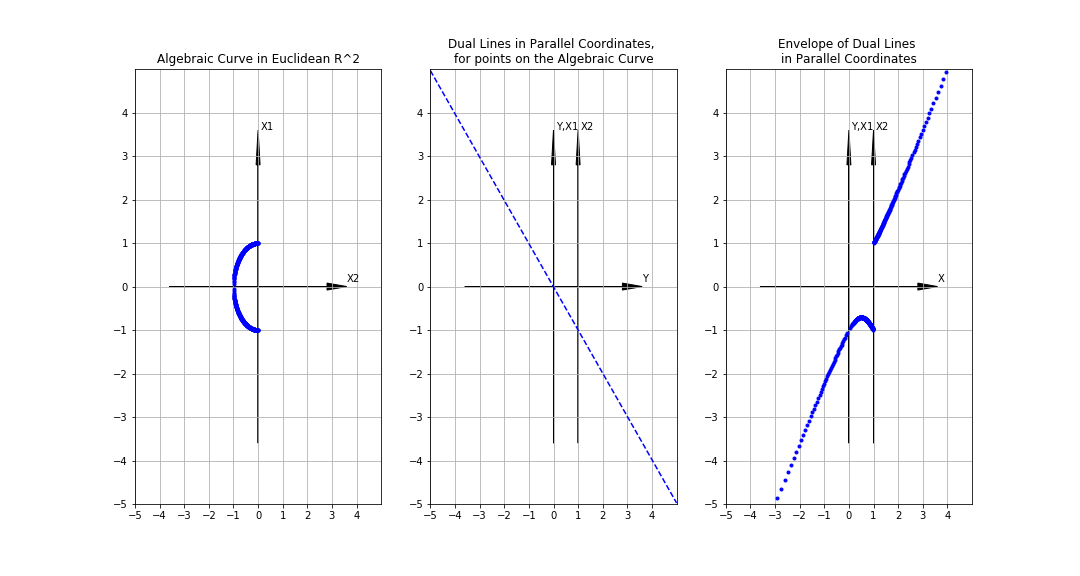
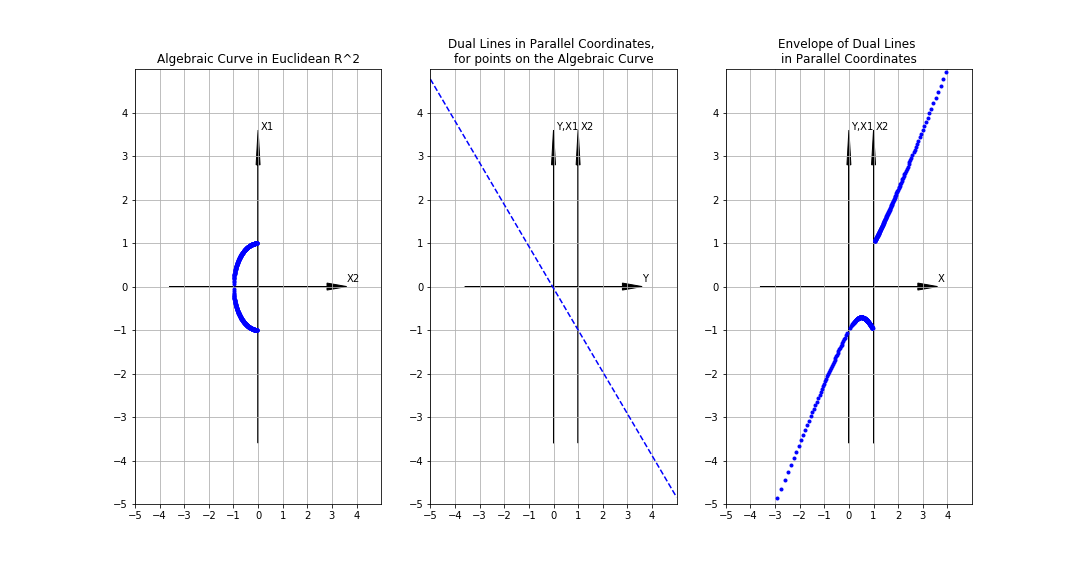
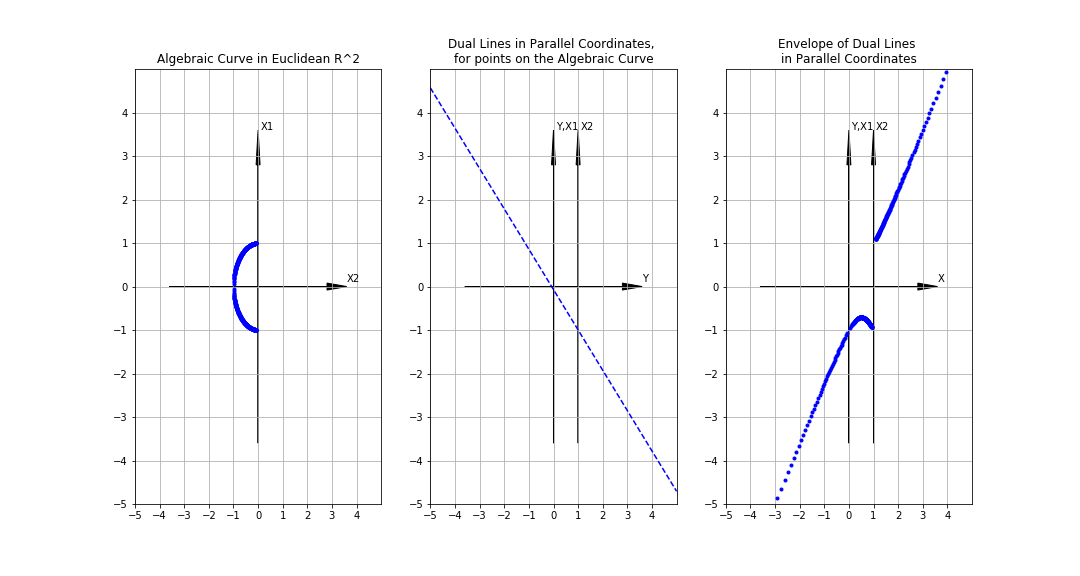
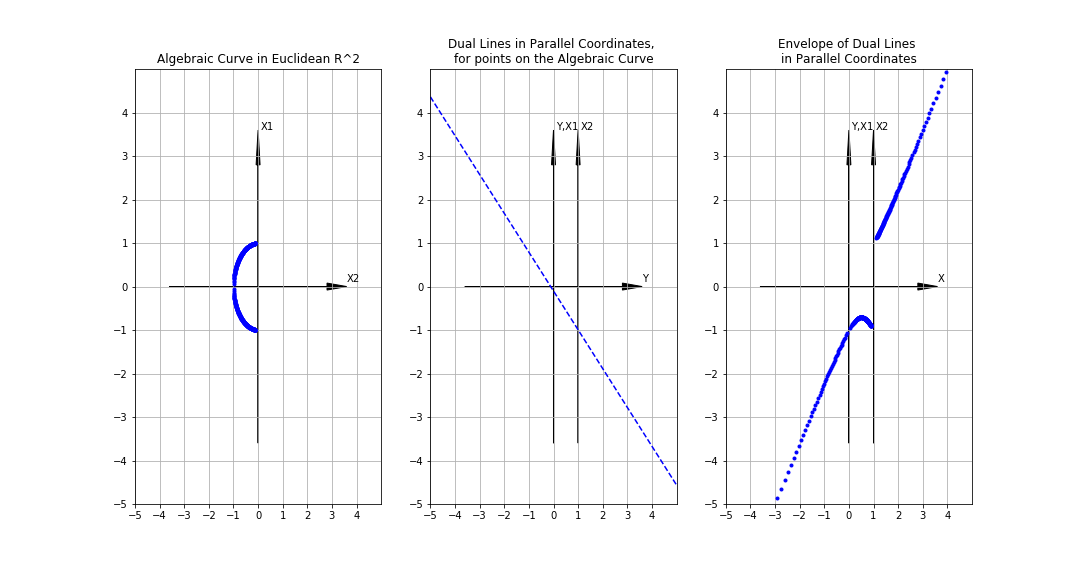
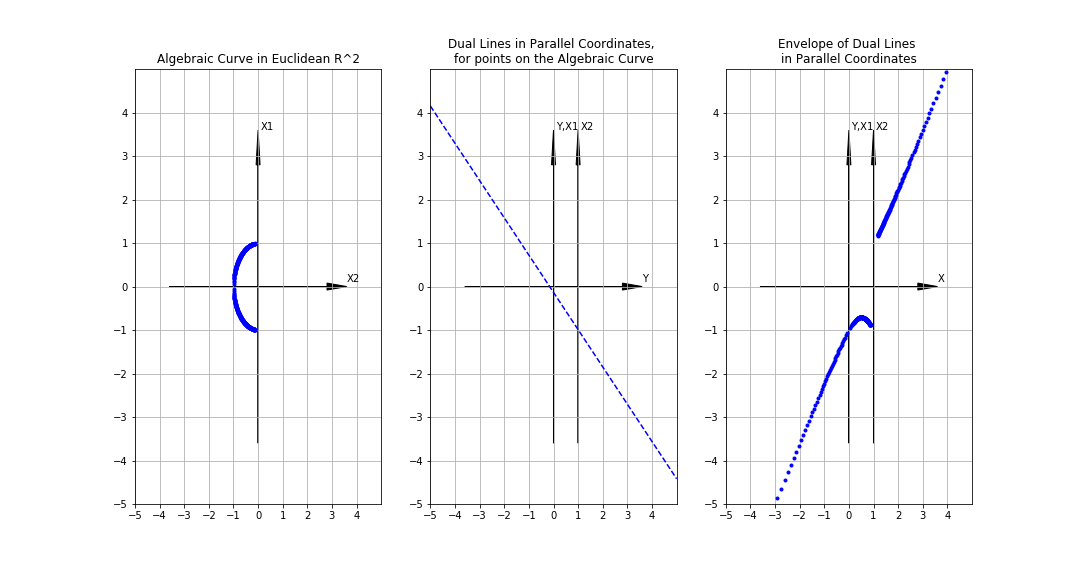
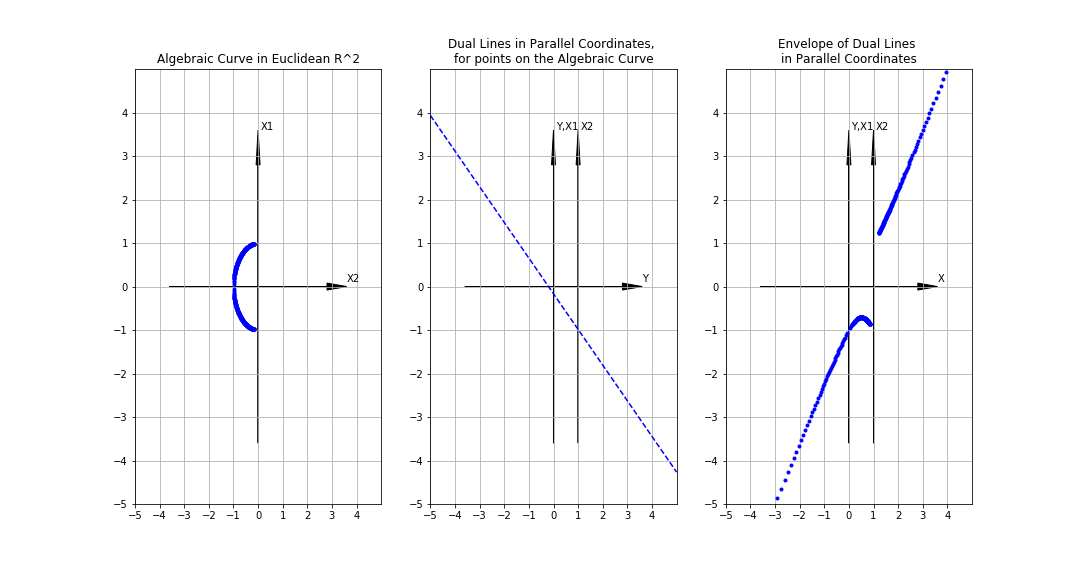
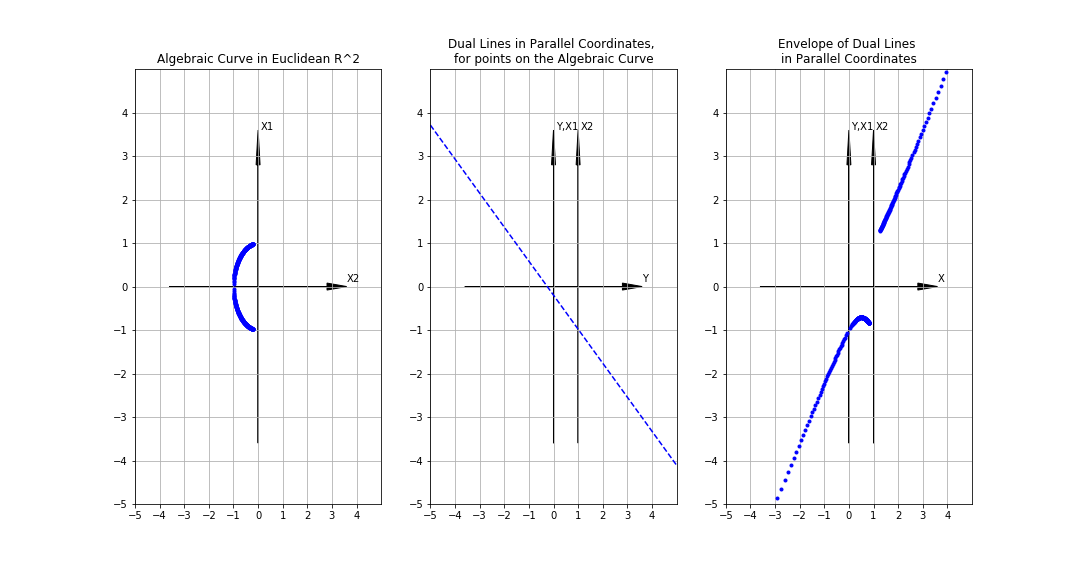
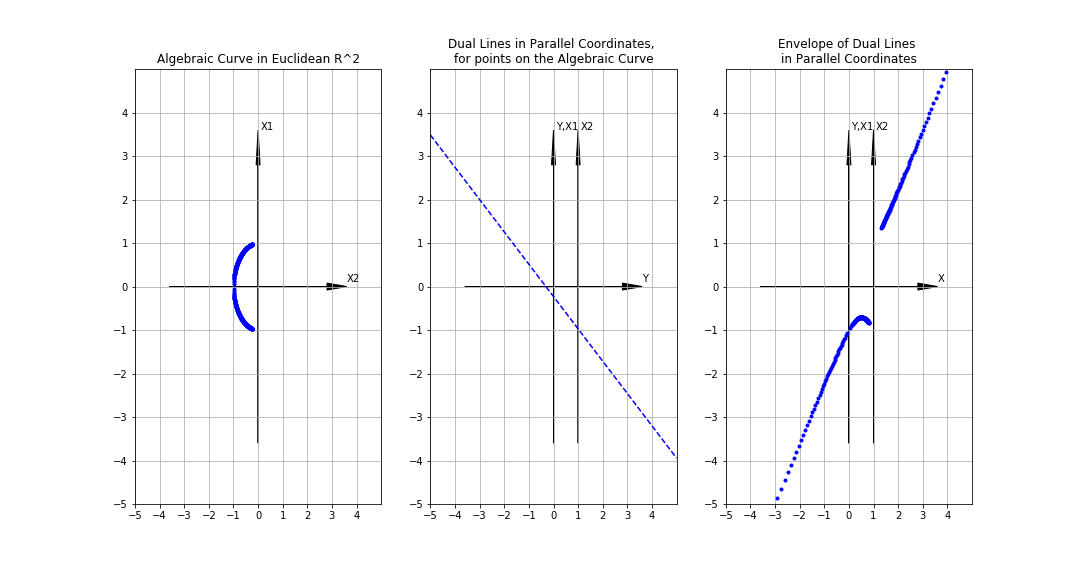
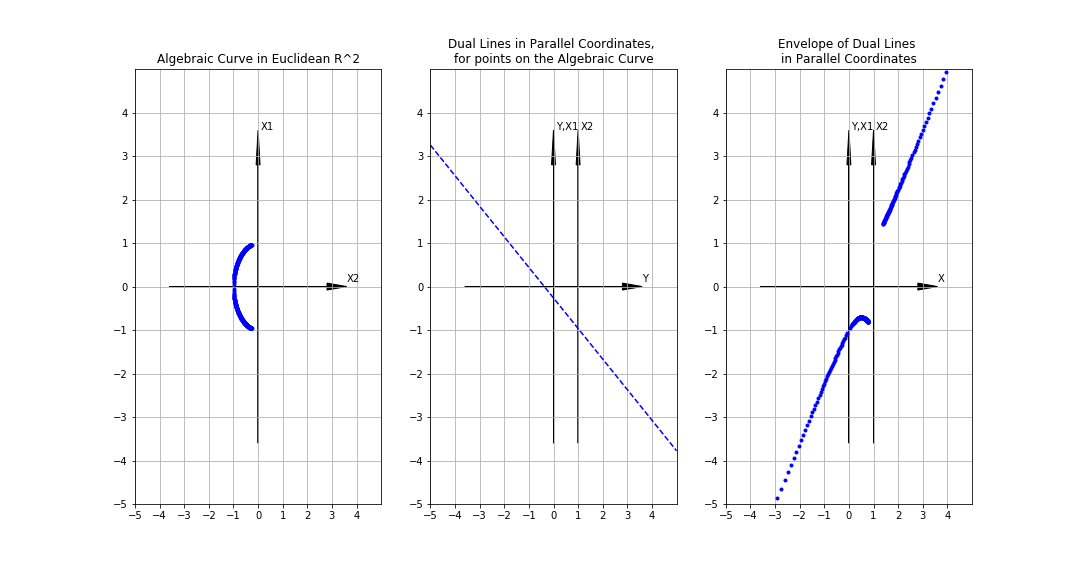
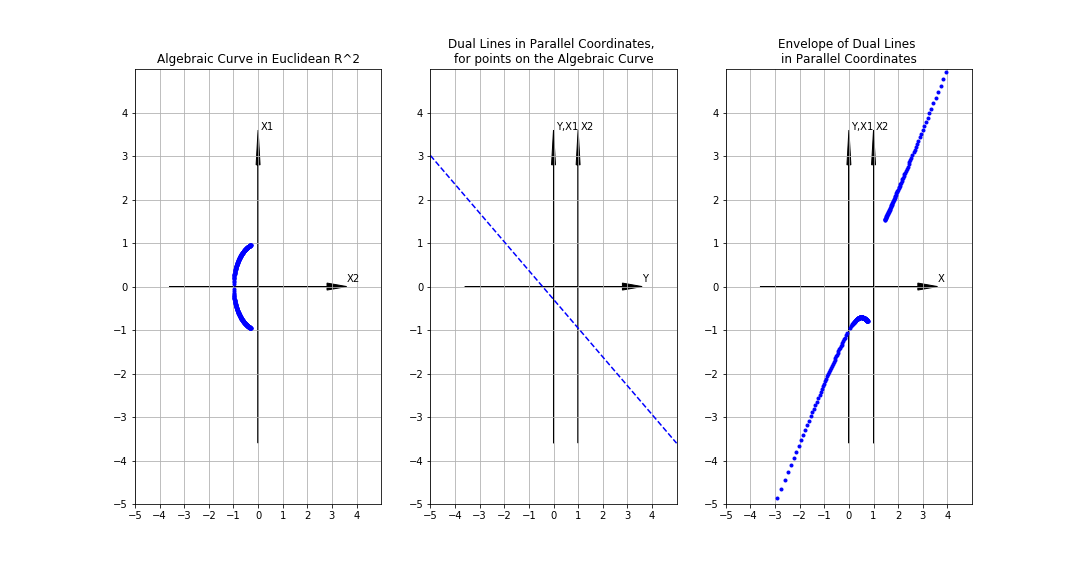
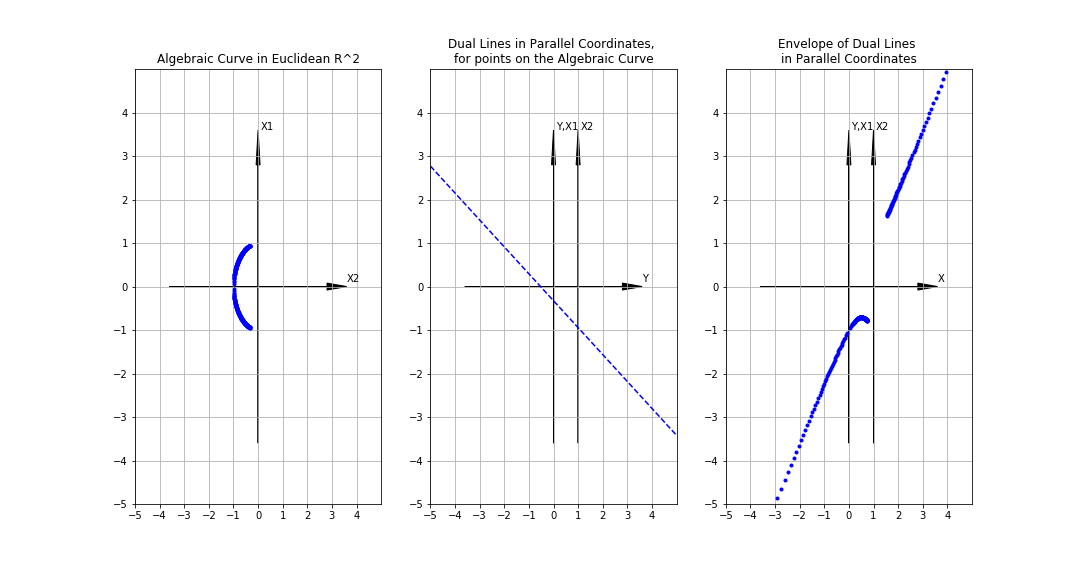
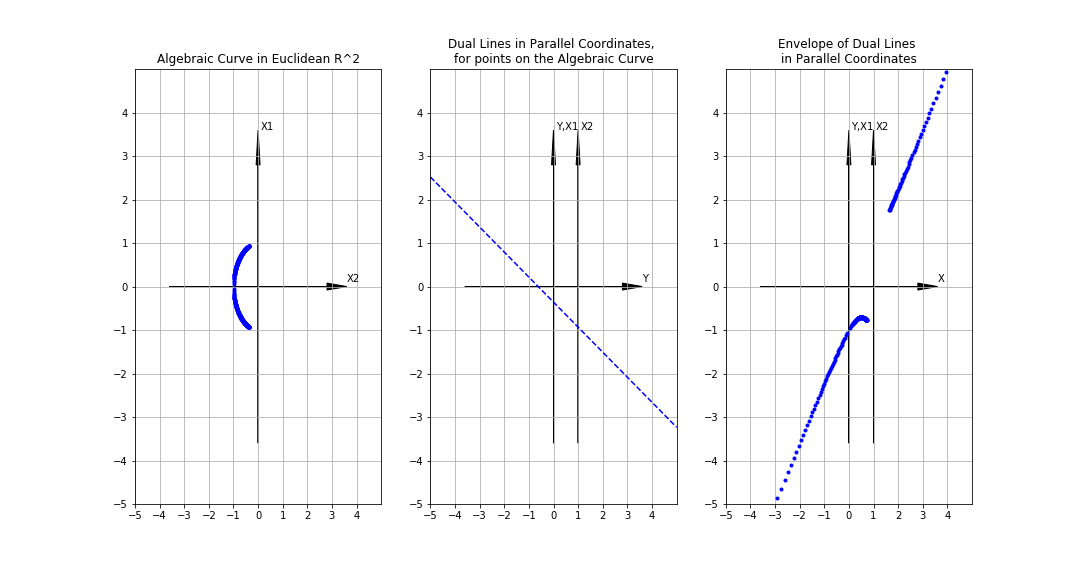
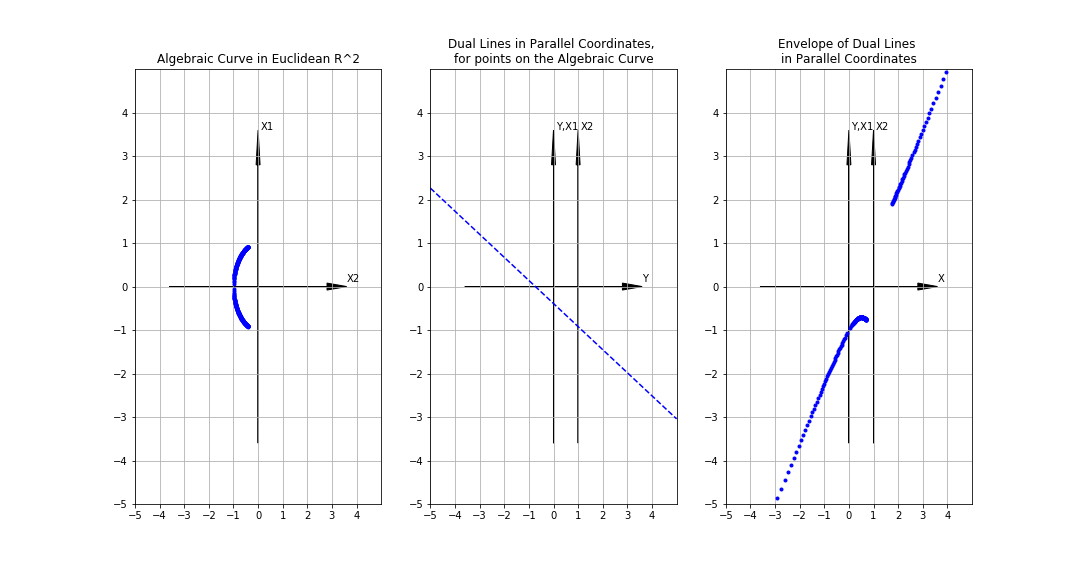
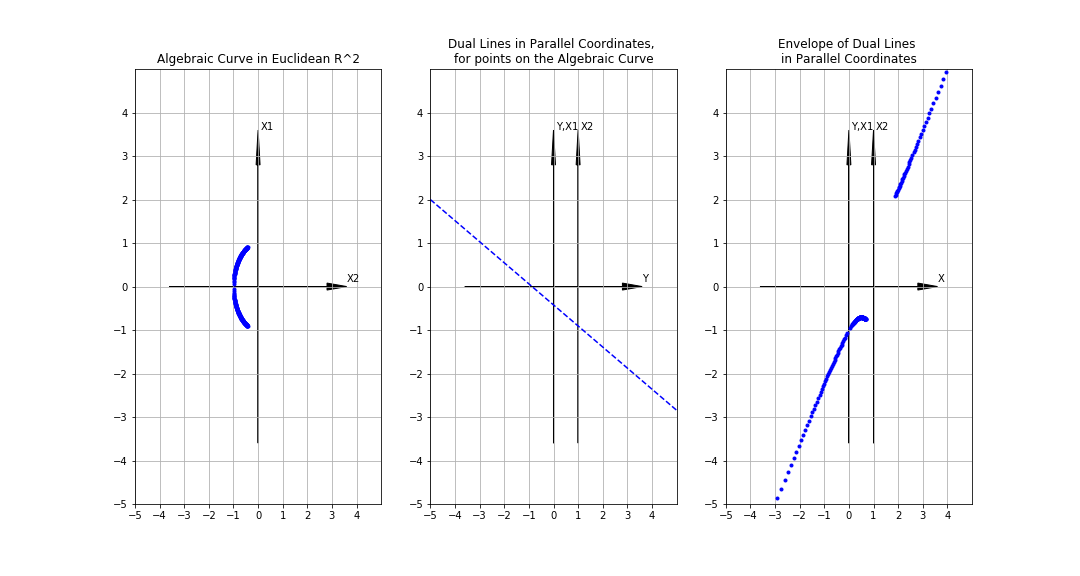
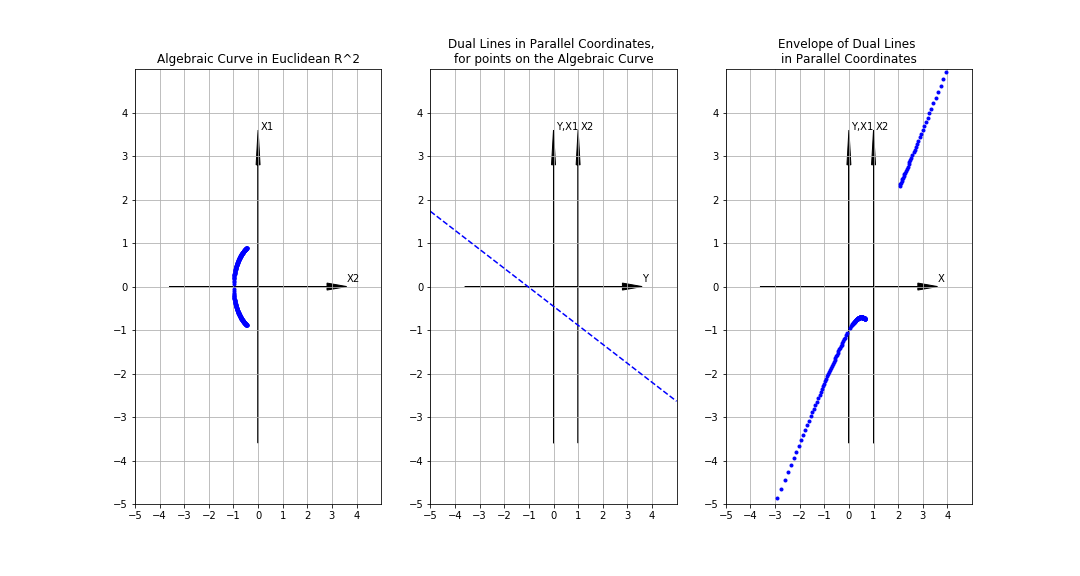
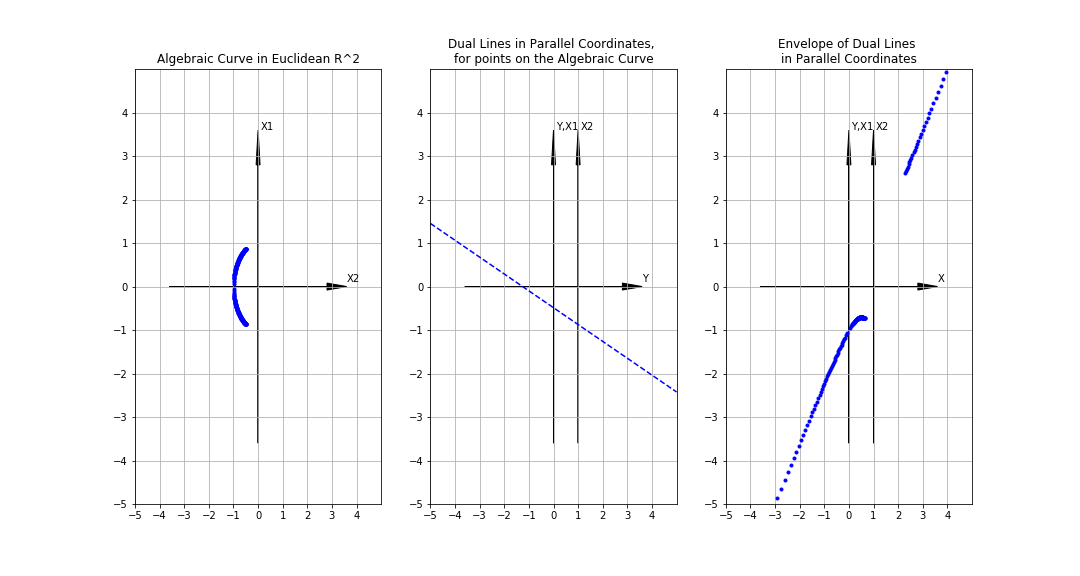
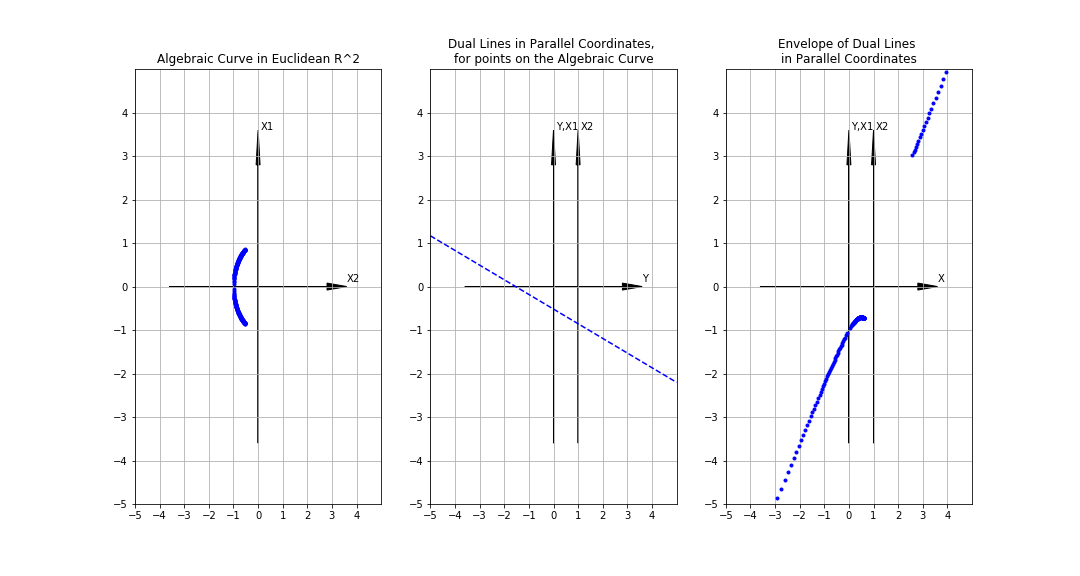
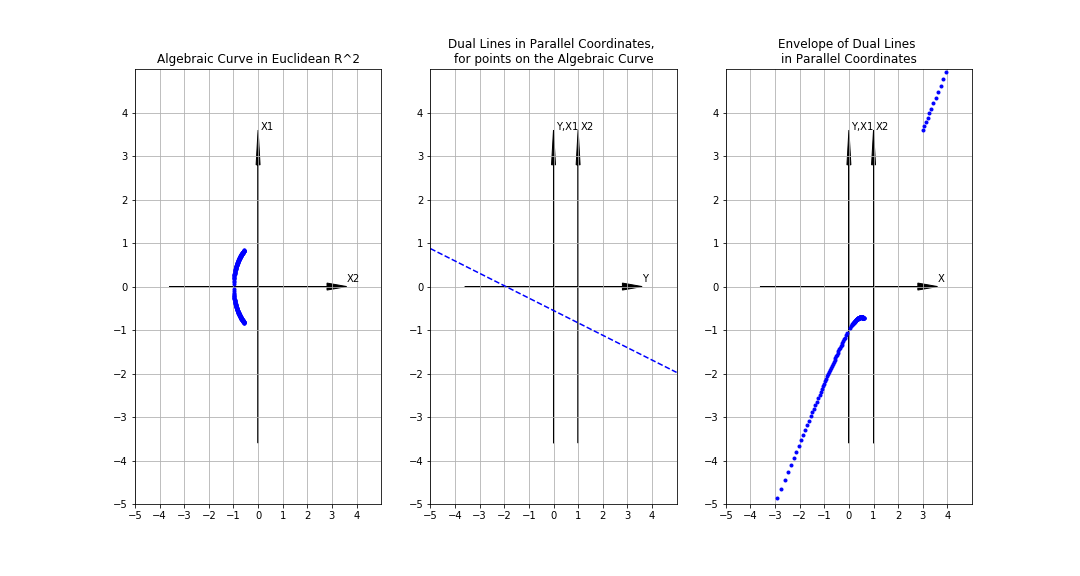
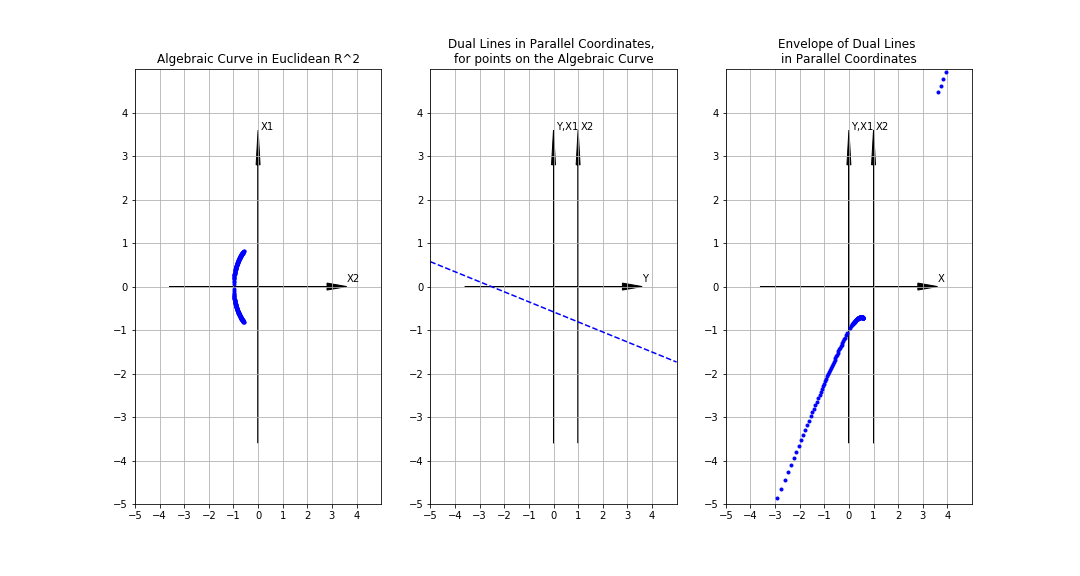
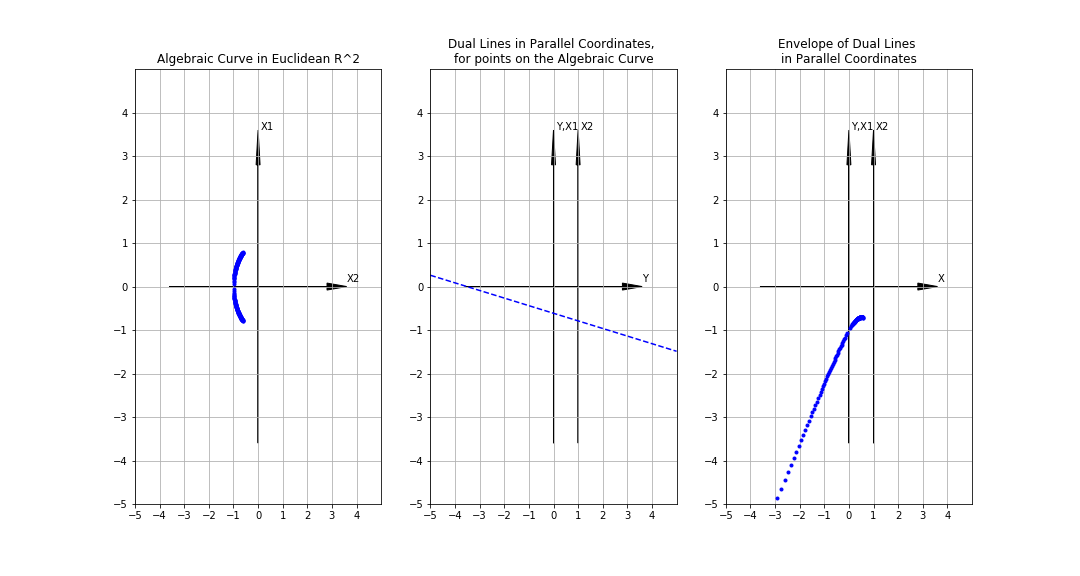
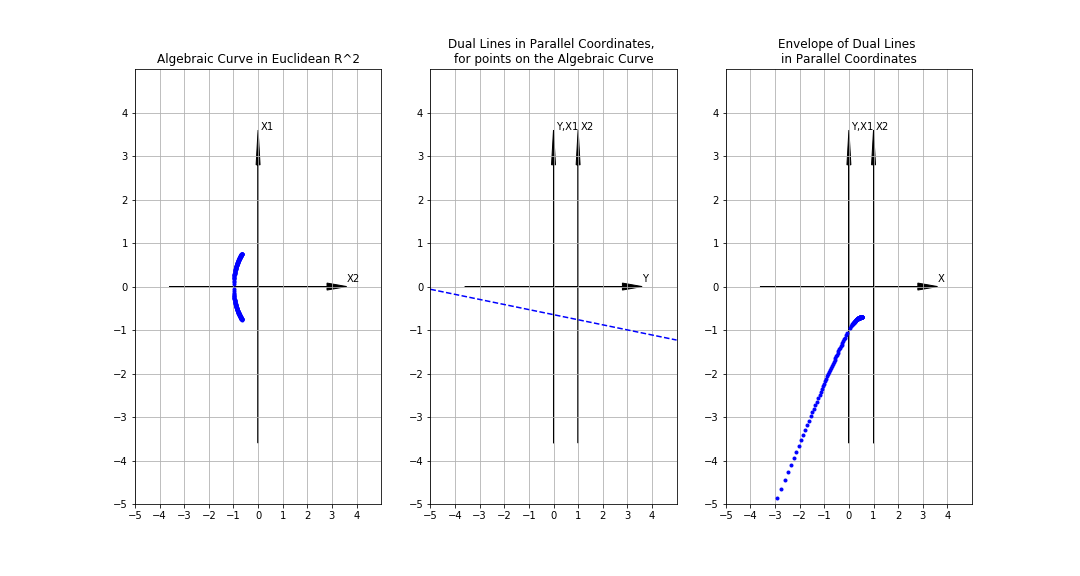
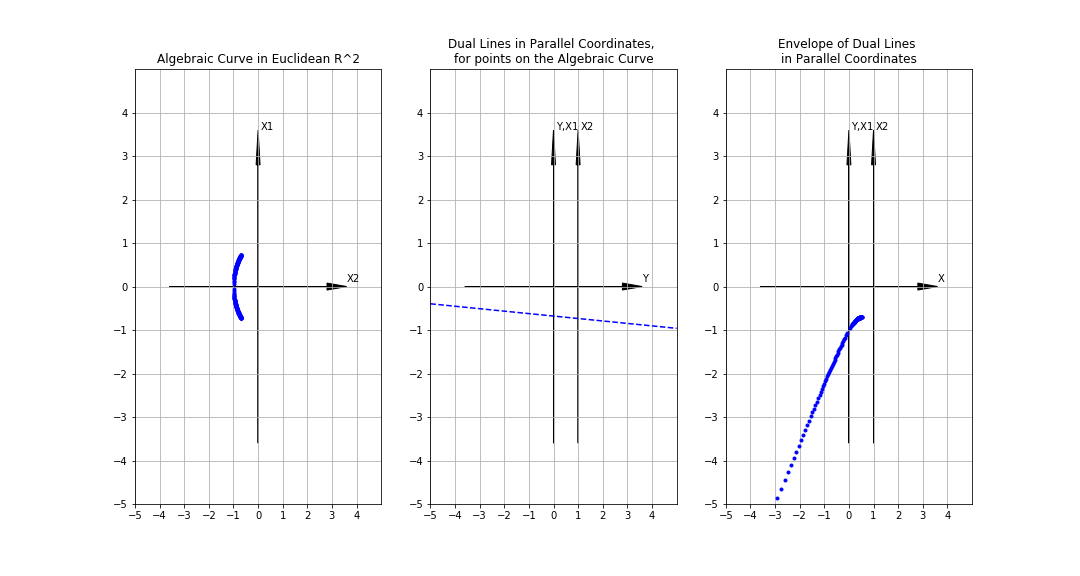
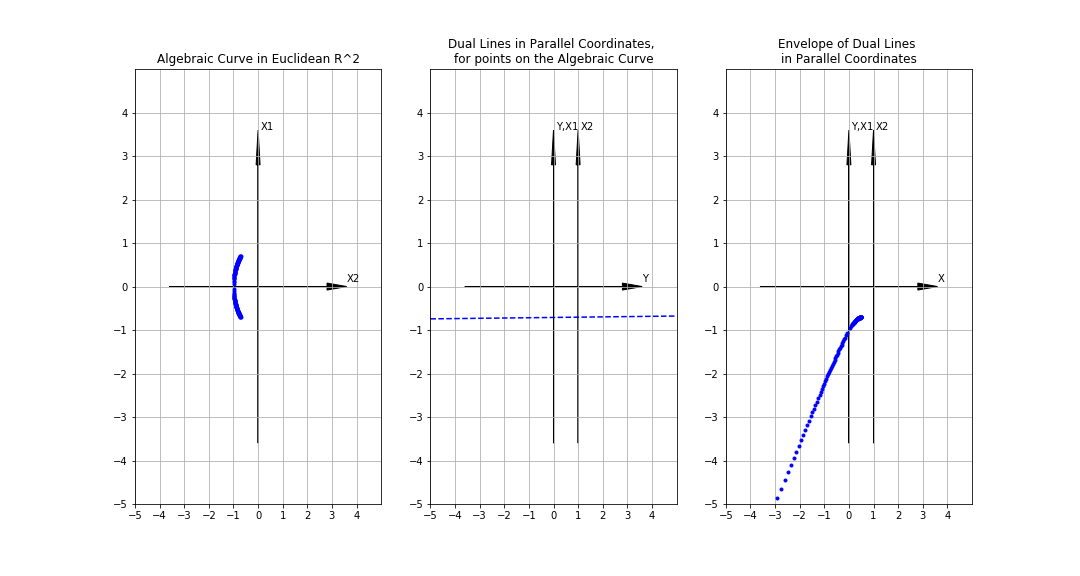
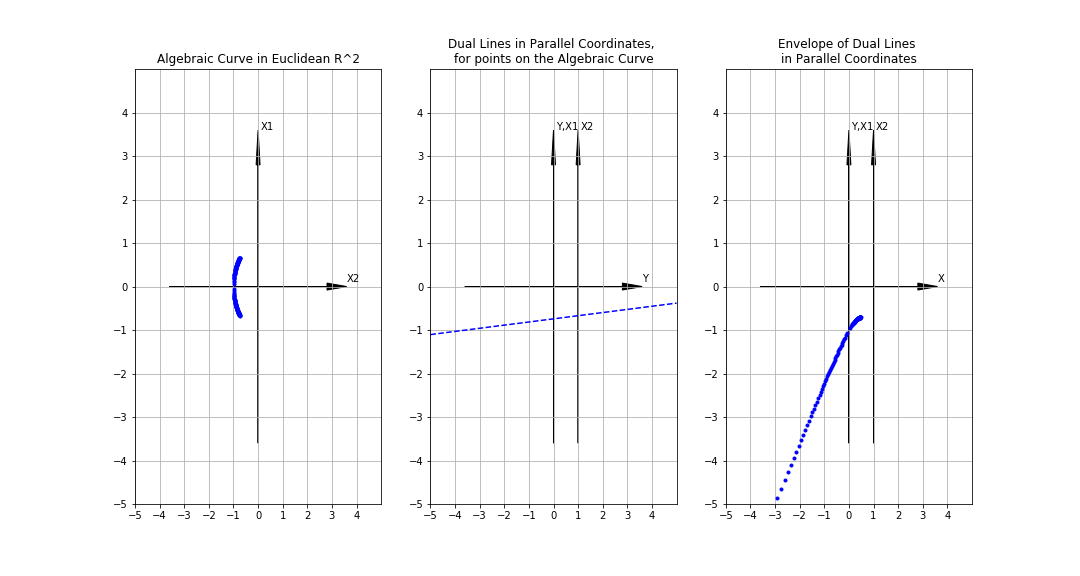
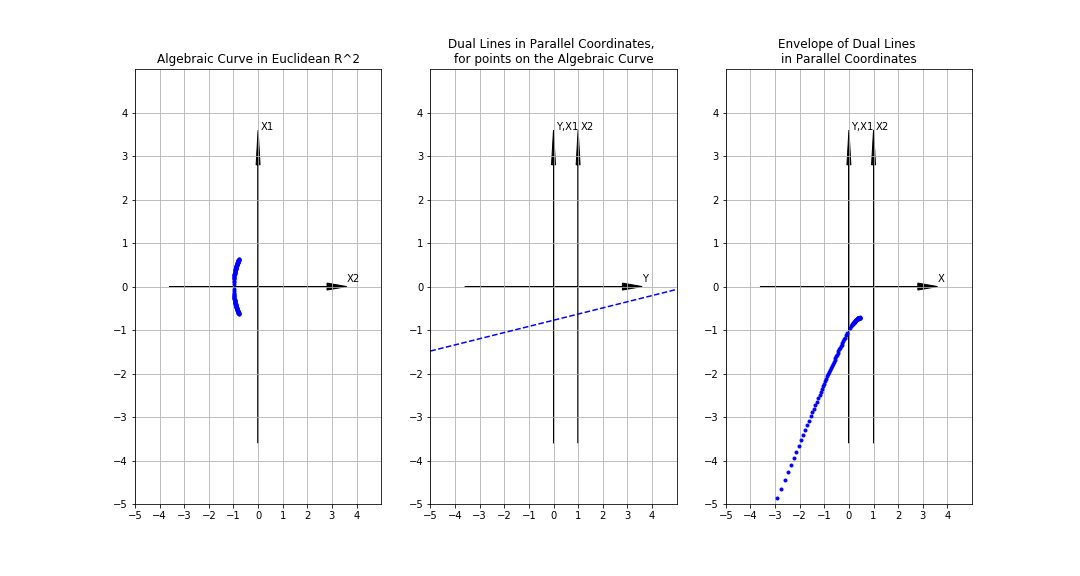
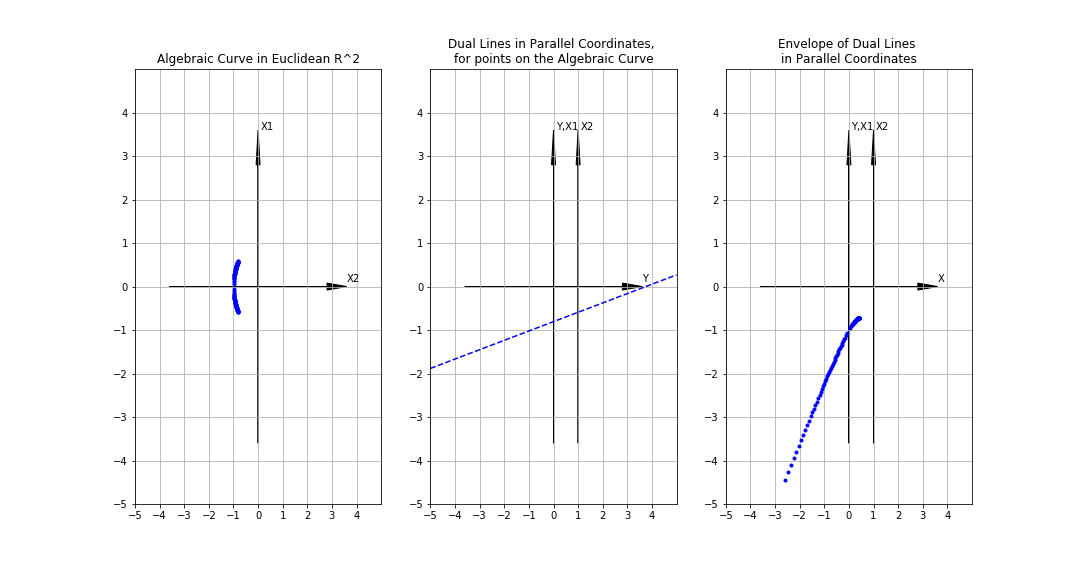
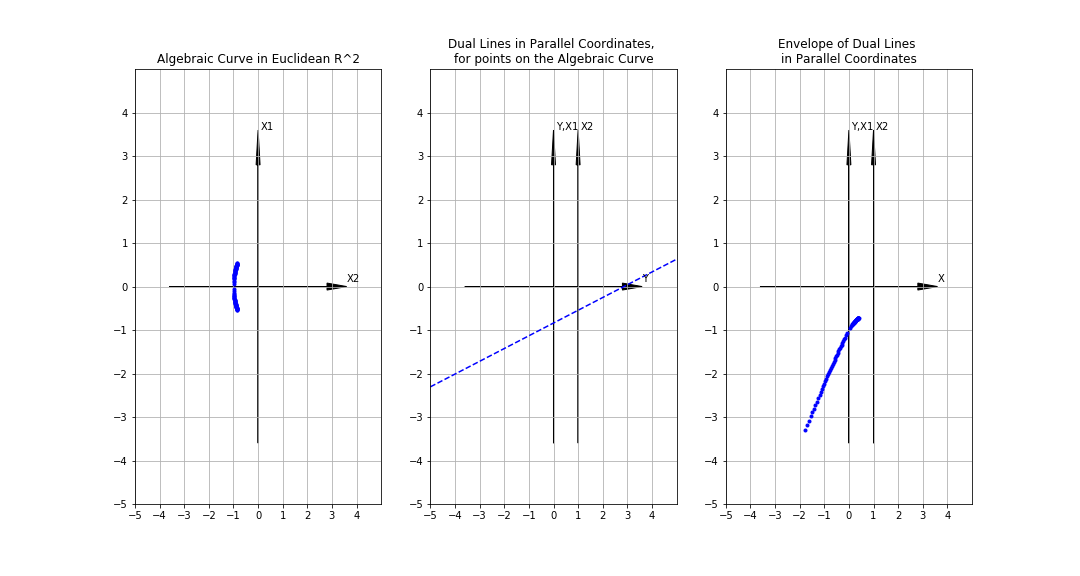
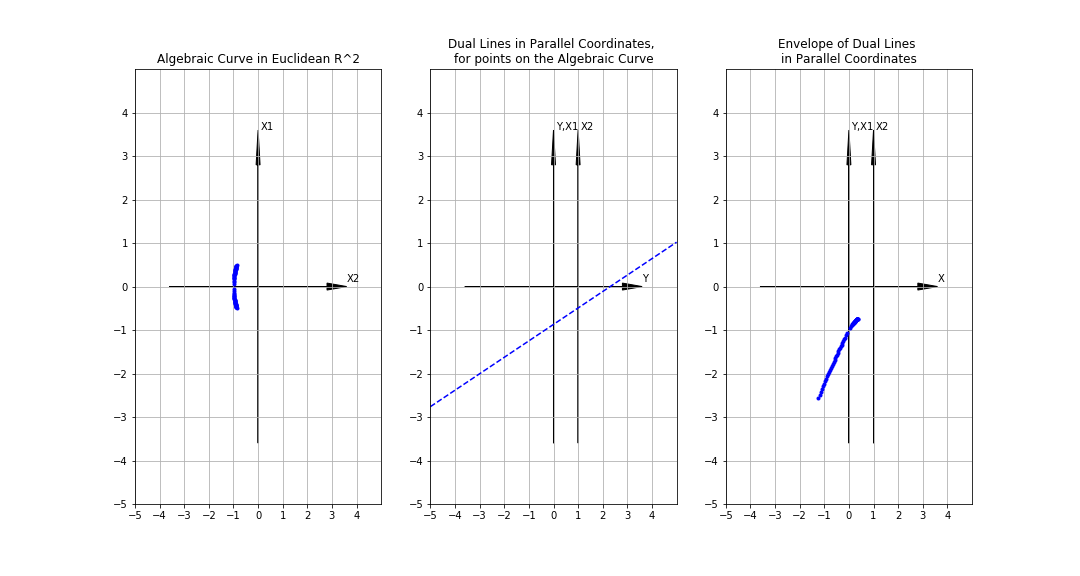
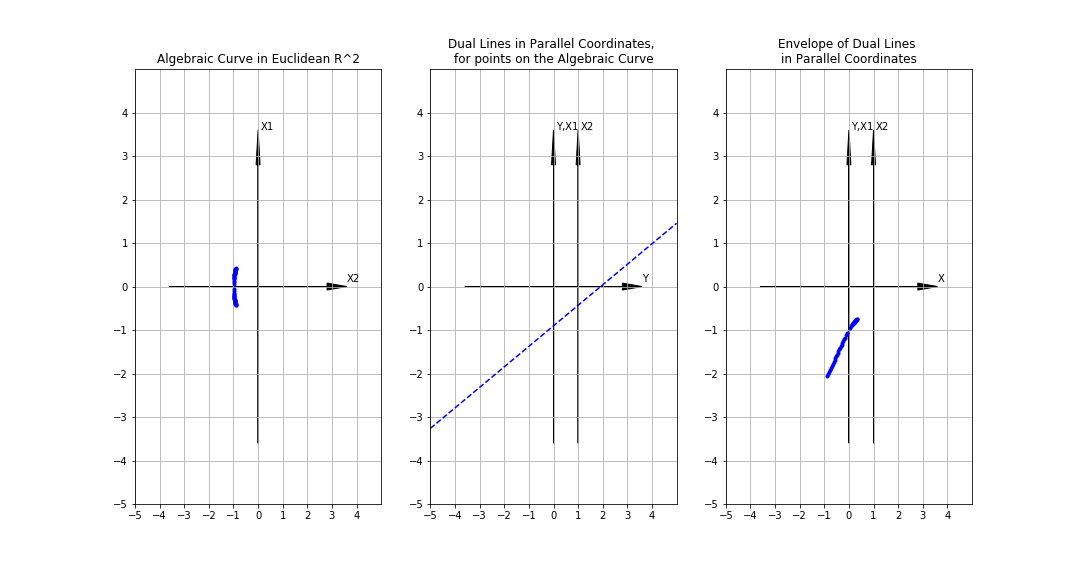
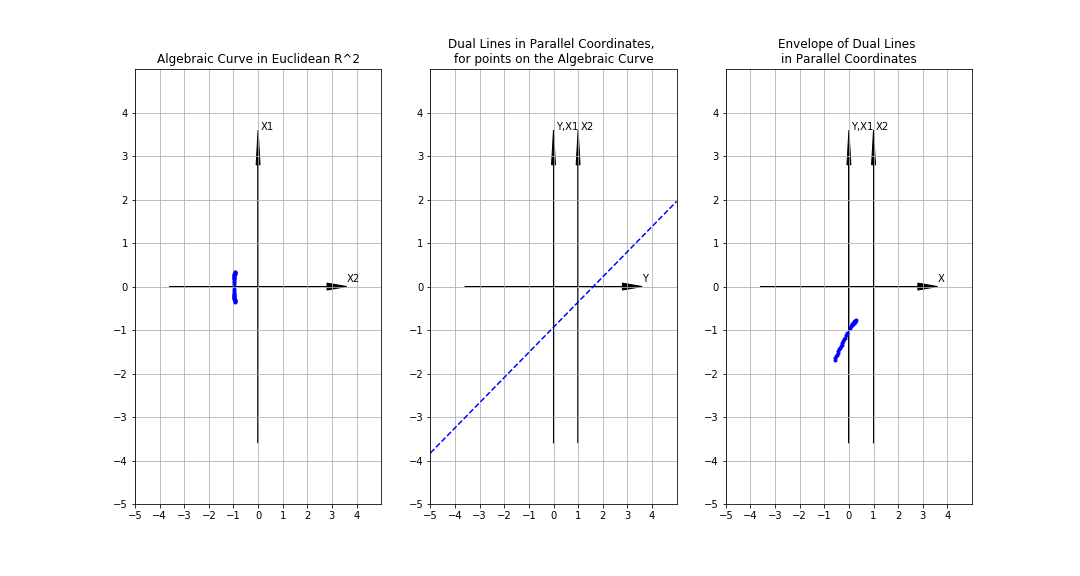
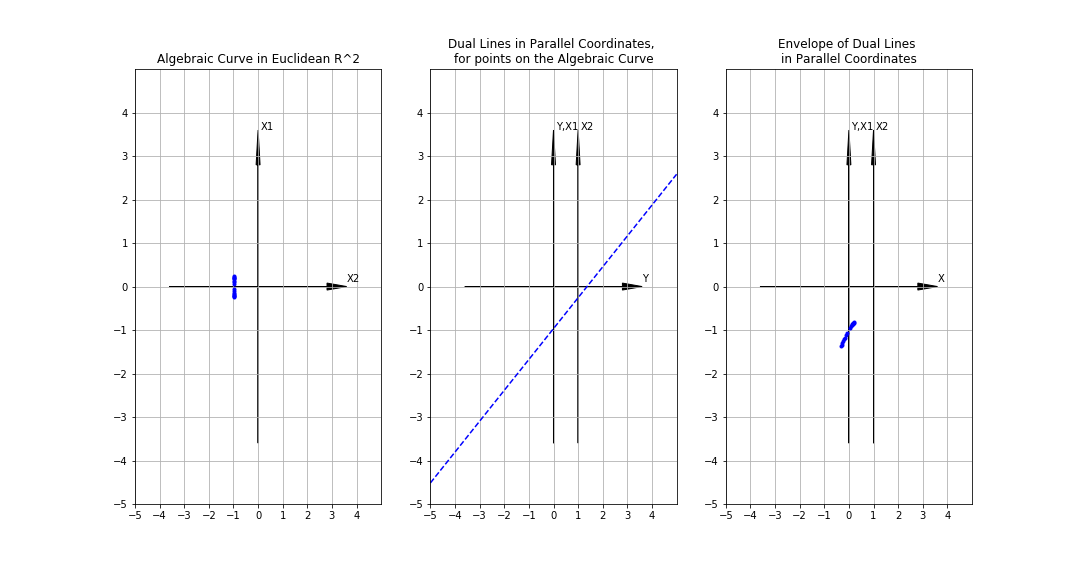
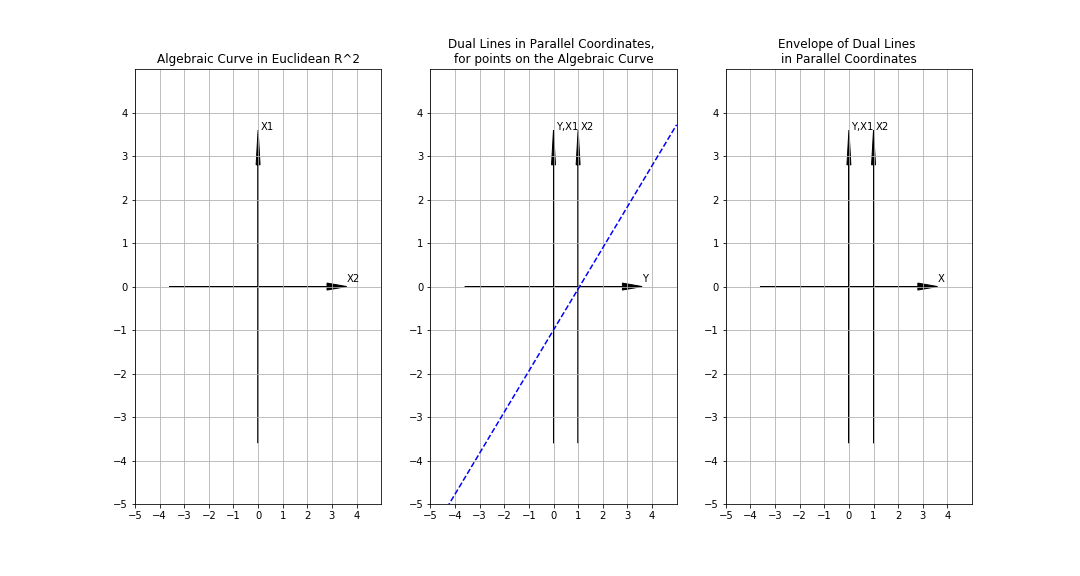

In [7]:
def update(frame):
    ln[0].set_data(X1[:frame], X2[:frame])
    if ONE_LINE:
        ln[1].set_data(L_x[frame, :], L_y[frame, :])
    else:
        ln[1].set_data(L_x_nans[:frame*3], L_y_nans[:frame*3])
    ln[2].set_data(X[:frame], Y[:frame])
    return ln

frm_chng = np.arange(0, X1.shape[0], FRAMES_PER_CHANGE)
anim = animation.FuncAnimation(fig, update, 
                               frames=np.concatenate((frm_chng, frm_chng[::-1])), 
                               interval=MSEC_FRAME_DELAY, blit=True)

if SAVE_ANIMATION:
    print('Animating curve plot, this might take a while..')
    writer = animation.ImageMagickFileWriter(fps=FPS)
    anim.save('%s.gif' % SAVE_AS, writer=writer)
    print('Animation saved to %s.gif' % join(os.getcwd(), SAVE_AS))
else:
    try:
        from JSAnimation.IPython_display import display_animation
        display_animation(anim, default_mode='loop')
    except ImportError:
        # in case JSAnimation isn't installed
        pass
    display(anim)